In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
from collections import namedtuple
from collections import defaultdict
from pprint import pprint

# Configure display options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%config InlineBackend.figure_format = 'retina'

# Add project directory to sys.path
pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))
sys.path.insert(1, pdir)
from myutils import *

# Other module imports
import ast, math, swifter, csv, json, itertools as it, portion as P

# Set plot style
# plt.style.use('ggplot')

# Functions & Methods

In [2]:
def set_data(df, mode='pcap', tz=0):
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    
    if mode == 'pcap':
        common_column_names = [
            'seq', 'rpkg', 'frame_id', 'Timestamp', 'Timestamp_epoth', 'lost', 'excl', 'latency',
            'xmit_time', 'xmit_time_epoch', 'arr_time', 'arr_time_epoch',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        date_columns = ['Timestamp', 'xmit_time', 'arr_time']
        df[date_columns] = df[date_columns].apply(pd.to_datetime)
        df[['seq', 'rpkg', 'frame_id']] = df[['seq', 'rpkg', 'frame_id']].astype('Int32')
        df[['Timestamp_epoch', 'xmit_time_epoch', 'arr_time_epoch', 'latency']] = \
            df[['Timestamp_epoch', 'xmit_time_epoch', 'arr_time_epoch', 'latency']].astype('float32')
        df[['lost', 'excl']] = df[['lost', 'excl']].astype('boolean')

    if mode in ['lte', 'nr']:
        common_column_names = [
            'Timestamp', 'type_id', 'PCI', 'RSRP', 'RSRQ', 'serv_cel_index', 'EARFCN', 'NR_ARFCN', 
            'num_cels', 'num_neigh_cels', 'serv_cel_pos', 'PCI0', 'RSRP0', 'RSRQ0',
        ]
        
        if df.empty:
            return pd.DataFrame(columns=common_column_names)
        
        if mode == 'lte':
            columns_mapping = {
                'RSRP(dBm)': 'RSRP',
                'RSRQ(dB)': 'RSRQ',
                'Serving Cell Index': 'serv_cel_index',
                'Number of Neighbor Cells': 'num_neigh_cels',
                'Number of Detected Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df['serv_cel_index'] = np.where(df['serv_cel_index'] == '(MI)Unknown', '3_SCell', df['serv_cel_index'])
            df['num_cels'] = df['num_neigh_cels'] + 1

        if mode == 'nr':
            columns_mapping = {
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
            }
            columns_order = [*common_column_names, *df.columns[df.columns.get_loc('PCI1'):].tolist()]
            
            df = df.rename(columns=columns_mapping).reindex(columns_order, axis=1)
            df[['PCI', 'RSRP', 'RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df['serv_cel_index'] = np.where(df['serv_cel_pos'] == 255, df['serv_cel_index'], 'PSCell')
            df['num_neigh_cels'] = np.where(df['serv_cel_pos'] == 255, df['num_cels'], df['num_cels'] - 1)
        
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df[['type_id', 'serv_cel_index']] = df[['type_id', 'serv_cel_index']].astype('category')
        df[['EARFCN', 'NR_ARFCN']] = df[['EARFCN', 'NR_ARFCN']].astype('Int32')
        df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']] = df[['num_cels', 'num_neigh_cels', 'serv_cel_pos']].astype('UInt8')

        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP', 'RSRQ')):
                df[tag] = df[tag].astype('float32')

    return df

def bpy_color_palette(n=50, cutoff_tails=0.1):
    """
    Generate a color palette with specific number.
    Ref. https://www.rdocumentation.org/packages/gstat/versions/0.9-22/topics/bpy.colors

    Args:
        n (int): number of colors
        cutoff_tails (float): tail fraction to be cut off. This palette runs from black to white if cutoff.tails is 0; by cutting off the tails, it runs from blue to yellow, which looks nicer.
    Returns:
        color_list (list): list of hex color code.
    """
    
    item_list = np.linspace(start=0.5 * cutoff_tails, stop=1 - 0.5 * cutoff_tails, num=n)
    color_list = []
    
    for i in item_list:
        # R
        if(i < 0.25):
            r = 0
        elif(i < 0.57):
            r =  i / .32 - .78125
        else:
            r = 1
        # G
        if(i < 0.42):
            g = 0
        elif(i < 0.92):
            g =  2 * i - .84
        else:
            g = 1
        # B
        if(i < 0.25):
            b = 4 * i
        elif(i < 0.42):
            b =  1
        elif(i < 0.92):
            b =  -2 * i + 1.84
        else:
            b = i / .08 - 11.5
        # append color
        color_list.append(matplotlib.colors.to_hex([ r, g, b ]))
        
    cmap = matplotlib.colors.ListedColormap(color_list, name='my_colormap')
    
    return cmap

def calc_loss_excl_rate(filepath):
    
    if isinstance(filepath, pd.DataFrame) and filepath.empty:
        return -1, -1, -1
    elif isinstance(filepath, str) and not os.path.isfile(filepath):
        return -1, -1, -1
    elif isinstance(filepath, pd.DataFrame) and not filepath.empty:
        df = filepath.copy()
    else:
        df = pd.read_pickle(filepath) if filepath.endswith('.pkl') else pd.read_csv(filepath)
    
    # Calculate PLR & ELR
    loss_rate = df['lost'].mean() * 100
    
    excl_threshold = 100e-3
    excl_rate = (df[~df['lost']]['latency'] > excl_threshold).mean() * 100
    
    loss_excl_rate = (df['latency'] > excl_threshold).mean() * 100
    
    return loss_rate, excl_rate, loss_excl_rate

def calc_dual_loss_excl_rate(filepath1, filepath2):
    
    if (isinstance(filepath1, pd.DataFrame) and filepath1.empty) or (isinstance(filepath2, pd.DataFrame) and filepath2.empty):
        return -1, -1, -1
    elif (isinstance(filepath1, str) and not os.path.isfile(filepath1)) or (isinstance(filepath2, str) and not os.path.isfile(filepath2)):
        return -1, -1, -1
    elif (isinstance(filepath1, pd.DataFrame) and not filepath1.empty) and (isinstance(filepath2, pd.DataFrame) and not filepath2.empty):
        df1 = filepath1.copy()
        df2 = filepath2.copy()
    else:
        df1 = pd.read_pickle(filepath1) if filepath1.endswith('.pkl') else pd.read_csv(filepath1)
        df2 = pd.read_pickle(filepath2) if filepath2.endswith('.pkl') else pd.read_csv(filepath2)

    st_seq = max([df1['seq'].array[0], df2['seq'].array[0]])
    ed_seq = min([df1['seq'].array[-1], df2['seq'].array[-1]])
    df1 = df1[(df1['seq'] >= st_seq) & (df1['seq'] <= ed_seq)].reset_index(drop=True)
    df2 = df2[(df2['seq'] >= st_seq) & (df2['seq'] <= ed_seq)].reset_index(drop=True)
    
    # Calculate system PLR & ELR
    loss_condition = df1['lost'] & df2['lost']
    system_loss_rate = loss_condition.mean() * 100

    excl_threshold = 100e-3
    excl_condition = (df1[~loss_condition]['latency'] > excl_threshold) & (df2[~loss_condition]['latency'] > excl_threshold)
    system_excl_rate = excl_condition.mean() * 100
    
    loss_excl_condition = (df1['latency'] > excl_threshold) & (df2['latency'] > excl_threshold)
    system_loss_excl_rate = loss_excl_condition.mean() * 100
    
    return system_loss_rate, system_excl_rate, system_loss_excl_rate

def add_suffix_to_duplicate_category(strings):
    # 創建一個字典來記錄每個字串符號的出現次數
    string_counts = {}
    
    # 加上后缀
    result_strings = []
    for s in strings:
        string_counts[s] = string_counts.get(s, 0) + 1
        if string_counts[s] > 1:
            result_strings.append(f"{s}_{string_counts[s] - 1}")
        else:
            result_strings.append(s)
    
    for s, count in string_counts.items():
        if count > 1:
            index = result_strings.index(s)
            result_strings[index] = f'{s}_0'

    return result_strings

my_list = ['A', 'B', 'A', 'C', 'B', 'D', 'A', 'E', 'E']
print("原始列表:", my_list)
print("加上後綴:", add_suffix_to_duplicate_category(my_list))

原始列表: ['A', 'B', 'A', 'C', 'B', 'D', 'A', 'E', 'E']
加上後綴: ['A_0', 'B_0', 'A_1', 'C', 'B_1', 'D', 'A_2', 'E_0', 'E_1']


# Main

In [3]:
class Experiment():
    ID = 0
    
    def __init__(self, dirpath, setting):
        self.id = f"{Experiment.ID:02d}"
        self.dirpath = dirpath
        self.date = os.path.basename(os.path.dirname(dirpath))
        self.name = os.path.basename(dirpath)
        self.setting = json.loads(setting)
        self.dev_traces = {}
        self.traces = []
        self.rrc_paths = {}
        self.lte_paths = {}
        self.nr_paths = {}
        self.ul_paths = {}
        self.dl_paths = {}
        self.metadata = None
        self.metadata_dual = None
        self.ranking = {}
        self.ranking_dual = {}
        Experiment.ID += 1
    
    def __repr__(self):
        return f'Experiment {self.id}: ./{self.date}/{self.name} -> {self.setting}'

def build_experiment_list(md_files):
    exp_list = []
    
    for md_file in md_files:
        with open(md_file, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        
        lines = lines[:lines.index('#endif')]
        
        for expr, sett in zip(lines[::2], lines[1::2]):
            parent_dir = os.path.dirname(md_file)
            experiment = Experiment(os.path.join(parent_dir, expr), sett)
            exp_list.append(experiment)
    
    return exp_list

# TODO: Check Root Folder
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
# root = '/home/wmnlab/D/database'

paths = [
    os.path.join(root, s)
    for s in os.listdir(root)
    if s.startswith('202') and os.path.isdir(os.path.join(root, s))
]

md_files = sorted([os.path.join(path, s) for path in paths for s in os.listdir(path) if s.endswith('.md')])

# GLOBAL VARIABLE !!!
exp_list = build_experiment_list(md_files)

pprint(exp_list)

[Experiment 00: ./2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 01: ./2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 02: ./2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 Experiment 03: ./2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 04: ./2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 Experiment 05: ./2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 06: ./2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 Experiment 07: ./2023-04-17/Bandlock_Udp_All_LTE_All_LTE_RM500Q -> {'qc00': 'All', 'qc01': 'LTE', 'qc02': 'All', 'qc03': 'LTE'},
 Experiment 08: ./2023-04-17/Bandlock_Udp_All_LTE_B1_B3_RM500Q -> {'qc00': 'All', 'qc01': 'L

In [4]:
# TODO: Select Experiments
selected_indices = [18]

exp_list = [exp_list[i] for i in selected_indices]

# GLOBAL VARIABLE !!!
look_up_table = {expr.id: i for i, expr in enumerate(exp_list)}

print(look_up_table)
print(exp_list)

{'18': 0}
[Experiment 18: ./2023-06-12/Bandlock_8_Schemes_Phone -> {'sm00': 'B3B7B8', 'sm01': 'B3', 'sm02': 'B7', 'sm03': 'B8', 'sm04': 'B3B7', 'sm05': 'B3B8', 'sm06': 'B7B8', 'sm07': 'LTE'}]


## Metadata

In [5]:
def remove_expr_element(remove_list):
    for id, dev, tr in remove_list:
        try:
            index = look_up_table[id]
        except:
            id_not_found = 1
            for i, expr in enumerate(exp_list):
                if f"{id:02d}" == expr.id:
                    id_not_found = 0
                    look_up_table[id] = i
                    index = i
                    break
            if id_not_found:
                print(f'Exp id: {id} not found!')
                continue
            
        if isinstance(tr, str):
            tr_name = tr
            tr_index = exp_list[index].traces.index(tr)
        else:
            tr_name = exp_list[index].traces[tr]
            tr_index = tr
        
        for path_list in [exp_list[index].rrc_paths[dev], exp_list[index].lte_paths[dev], exp_list[index].nr_paths[dev], exp_list[index].ul_paths[dev], exp_list[index].dl_paths[dev]]:
            path_list[tr_index] = ''
        
        exp_list[index].dev_traces[dev] = ', '.join([s for s in exp_list[index].dev_traces[dev].split(', ') if s != tr_name])
    
    for expr in exp_list:
        merged_dict = {key: (expr.setting[key], expr.dev_traces[key]) for key in expr.setting}
        expr.metadata = pd.DataFrame(merged_dict.values(), index=merged_dict.keys(), columns=['Schm', 'Traces']).reset_index().rename(columns={'index':'Device'})

# GLOBAL VARIABLE !!!
nr_check_tables = []

for expr in exp_list:
    # Feed-In Metadata
    expr.dev_traces = {
        dev: ', '.join(traces)
        for dev in expr.setting.keys()
        for traces in [[s for s in sorted(os.listdir(os.path.join(expr.dirpath, dev))) if s.startswith('#')]]
    }
    expr.traces = list(expr.dev_traces.values())[0].split(', ')
    merged_dict = {key: (expr.setting[key], expr.dev_traces[key]) for key in expr.setting}
    expr.metadata = pd.DataFrame(merged_dict.values(), index=merged_dict.keys(), columns=['Schm', 'Traces']).reset_index().rename(columns={'index':'Device'})

    # Print Out Metadata
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

    # Feed-In Data Path
    for dev in expr.setting.keys():
        expr.rrc_paths[dev], expr.lte_paths[dev], expr.nr_paths[dev], expr.ul_paths[dev], expr.dl_paths[dev] = [], [], [], [], []

        for trace in expr.traces:
            data_dir = os.path.join(expr.dirpath, dev, trace, 'data')
            expr.rrc_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.pkl')]
            expr.lte_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_ml1.pkl') and not s.endswith('_nr_ml1.pkl')]
            expr.nr_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_nr_ml1.pkl')]
            expr.ul_paths[dev] += [os.path.join(data_dir, 'udp_uplk_loss_latency.pkl')]
            expr.dl_paths[dev] += [os.path.join(data_dir, 'udp_dnlk_loss_latency.pkl')]

    # Check NR Alive
    nr_checktable_path = os.path.join(expr.dirpath, 'nr_alive_checktable.csv')
    if os.path.isfile(nr_checktable_path):
        table = pd.read_csv(nr_checktable_path)
    else:
        devices = expr.setting.keys()
        traces = expr.traces

        table = pd.DataFrame(columns=['Tr.', *devices])
        for i, trace in enumerate(tqdm(traces, ncols=1000)):
            check_list = [trace] + ['O'] * len(devices)
            for j, dev in enumerate(devices):
                rrc_data = expr.rrc_paths[dev][i]
                rrc_df, _, _ = mi_parse_ho(pd.read_pickle(rrc_data), tz=8)
                if sum(rrc_df['cause'] == 'rlc-MaxNumRetx (2)') > 0:
                    check_list[j+1] = '∆'
                nr_data = expr.nr_paths[dev][i]
                nr_df = pd.read_pickle(nr_data)
                if nr_df.empty:
                    check_list[j+1] = 'X'
            table.loc[len(table)] = check_list

        table.to_csv(nr_checktable_path, index=False)

    nr_check_tables.append(table)

    display(table)
    print('O: RF Module is always on.')
    print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
    print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
    print()

Experiment 18: 2023-06-12 | Bandlock_8_Schemes_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06', '#07', '#08', '#09', '#10']


Device    Schm                                            Traces
0   sm00  B3B7B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
1   sm01      B3  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
2   sm02      B7  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
3   sm03      B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
4   sm04    B3B7  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
5   sm05    B3B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
6   sm06    B7B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
7   sm07     LTE  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    O    O    O    O    O    O    O    O
1  #02    O    O    O    O    O    ∆    O    ∆
2  #03    O    O    O    O    O    O    O    O
3  #04    O    O    ∆    O    O    O    O    O
4  #05    O    O    ∆    O    O    O    ∆    O
5  #06    O    O    O    O    O    O    O    O
6  #07    O    O    O    O    O    O    O    O
7  #08    O    O    ∆    O    O    O    ∆    ∆
8  #09    O    O    O    O    O    O    O    ∆
9  #10    O    O    ∆    O    O    O    O    ∆

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.



In [289]:
# TODO: Remove Abnormal Data
# remove_expr_element([(22, 'sm05', 1), (22, 'sm06', '#02')])


In [8]:
my_list = [(22, dev, '#05') for dev in ['sm00', 'sm01', 'sm02', 'sm03', 'sm04', 'sm05', 'sm06', 'sm07']]
remove_expr_element(my_list)

## Selected Data Preview

In [6]:
for expr, nr_table in zip(exp_list, nr_check_tables):
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

    path_list = [
        # ('rrc_paths', expr.rrc_paths),
        # ('lte_paths', expr.lte_paths),
        # ('nr_paths', expr.nr_paths),
        # ('ul_paths', expr.ul_paths),
        # ('dl_paths', expr.dl_paths),
    ]
    for path_type, paths in path_list:
        print(path_type)
        pprint(paths)

    display(nr_table)
    print('O: RF Module is always on.')
    print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
    print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
    print()

Experiment 18: 2023-06-12 | Bandlock_8_Schemes_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06', '#07', '#08', '#09', '#10']


Device    Schm                                            Traces
0   sm00  B3B7B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
1   sm01      B3  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
2   sm02      B7  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
3   sm03      B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
4   sm04    B3B7  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
5   sm05    B3B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
6   sm06    B7B8  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10
7   sm07     LTE  #01, #02, #03, #04, #05, #06, #07, #08, #09, #10

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    O    O    O    O    O    O    O    O
1  #02    O    O    O    O    O    ∆    O    ∆
2  #03    O    O    O    O    O    O    O    O
3  #04    O    O    ∆    O    O    O    O    O
4  #05    O    O    ∆    O    O    O    ∆    O
5  #06    O    O    O    O    O    O    O    O
6  #07    O    O    O    O    O    O    O    O
7  #08    O    O    ∆    O    O    O    ∆    ∆
8  #09    O    O    O    O    O    O    O    ∆
9  #10    O    O    ∆    O    O    O    O    ∆

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.



# Single Radio

In [10]:
my_list = [9, 3, 7, 1, 5]
print("原始列表:", my_list)
print()

# 獲取按值升冪排序的索引列表
sorted_list = list(np.sort(my_list))
sorted_indices = list(np.argsort(my_list))
print("升冪排序:", sorted_list)
print("按值進行升冪排序的索引列表:", sorted_indices)

# 利用索引列表計算ranking
ranking = list(np.argsort(sorted_indices) + 1)
print("升冪排名:", ranking)
print()

# 獲取按值降冪排序的索引列表
sorted_list = list(np.sort(my_list)[::-1])
sorted_indices = list(np.argsort(my_list)[::-1])
print("降冪排序:", sorted_list)
print("按值進行降冪排序的索引列表:", sorted_indices)

# 利用索引列表計算ranking
ranking = list(np.argsort(sorted_indices) + 1)
print("降冪排名:", ranking)

原始列表: [9, 3, 7, 1, 5]

升冪排序: [1, 3, 5, 7, 9]
按值進行升冪排序的索引列表: [3, 1, 4, 2, 0]
升冪排名: [5, 2, 4, 1, 3]

降冪排序: [9, 7, 5, 3, 1]
按值進行降冪排序的索引列表: [0, 2, 4, 1, 3]
降冪排名: [1, 4, 2, 5, 3]


In [11]:
# GLOBAL VARIABLE !!!
single_metrics_list = []

for expr in exp_list:
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    metrics_dict = {}
    
    for (dev, ul_paths), dl_paths in tqdm(zip(expr.ul_paths.items(), expr.dl_paths.values()), ncols=1000):
        metrics_dict[dev] = {'ul_loss': [], 'ul_excl': [], 'ul_loss_excl': [], 'dl_loss': [], 'dl_excl': [], 'dl_loss_excl': []}
        
        for ul_path, dl_path in zip(ul_paths, dl_paths):
            ul_loss_rate, ul_excl_rate, ul_loss_excl_rate = calc_loss_excl_rate(ul_path)
            dl_loss_rate, dl_excl_rate, dl_loss_excl_rate = calc_loss_excl_rate(dl_path)
            
            metrics_dict[dev]['ul_loss'].append(ul_loss_rate)
            metrics_dict[dev]['ul_excl'].append(ul_excl_rate)
            metrics_dict[dev]['ul_loss_excl'].append(ul_loss_excl_rate)
            metrics_dict[dev]['dl_loss'].append(dl_loss_rate)
            metrics_dict[dev]['dl_excl'].append(dl_excl_rate)
            metrics_dict[dev]['dl_loss_excl'].append(dl_loss_excl_rate)
    
    single_metrics_list.append(metrics_dict)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl', 'ul_loss_excl', 'dl_loss_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR']

    # Display Table
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])

    # Ranking
    for tag in tags:
        data = [np.mean([num for num in v[tag] if num >= 0]) for v in metrics_dict.values()]
        ranking = np.argsort(np.argsort(data)) + 1
        
        expr.metadata[f'avg_{tag}'] = data
        expr.metadata[f'{tag}_rank'] = ranking
    
    print('Single Radio Ranking:')
    display(expr.metadata.iloc[:, :-4])

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


0it [00:00, ?it/s]

Single Radio Ranking:


Device Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #06     0.213181             1   
1   sm01  LTE  #01, #02, #03, #04, #06     0.313677             7   
2   sm02   B3  #01, #02, #03, #04, #06     0.261117             3   
3   sm03   B3  #01, #02, #03, #04, #06     0.288008             5   
4   sm04   B7  #01, #02, #03, #04, #06     0.600796             8   
5   sm05   B7  #01, #02, #03, #04, #06     0.311095             6   
6   sm06   B8  #01, #02, #03, #04, #06     0.225455             2   
7   sm07   B8  #01, #02, #03, #04, #06     0.277170             4   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.000000             1     1.208966             2     0.919915   
1     0.199828             2     0.768861             1     1.259045   
2     1.081235             6     5.980799             8     0.784830   
3     1.007013             5     4.308118             7     0.437925   
4     1.350004             7     3.147926             5     0.827589   
5     1.609289             8     3.756195             6     0.715994   
6     0.210307             3     3.037986             4     0.494916   
7     0.760469             4     2.889163             3     0.614197   

   dl_excl_rank  
0             7  
1             8  
2             5  
3             1  
4             6  
5             4  
6             2  
7             3

## Box Plot

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #06     0.213181             1   
1   sm01  LTE  #01, #02, #03, #04, #06     0.313677             7   
2   sm02   B3  #01, #02, #03, #04, #06     0.261117             3   
3   sm03   B3  #01, #02, #03, #04, #06     0.288008             5   
4   sm04   B7  #01, #02, #03, #04, #06     0.600796             8   
5   sm05   B7  #01, #02, #03, #04, #06     0.311095             6   
6   sm06   B8  #01, #02, #03, #04, #06     0.225455             2   
7   sm07   B8  #01, #02, #03, #04, #06     0.277170             4   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.000000             1     1.208966             2     0.919915   
1     0.199828             2     0.768861             1     1.259045   
2     1.081235             6     5.980799             8     0.784830   
3     1.007013             5     4.308118             7     0.437925   
4     1.350004             7     3.147926             5     0.827589   
5     1.609289             8     3.756195             6     0.715994   
6     0.210307             3     3.037986             4     0.494916   
7     0.760469             4     2.889163             3     0.614197   

   dl_excl_rank  
0             7  
1             8  
2             5  
3             1  
4             6  
5             4  
6             2  
7             3

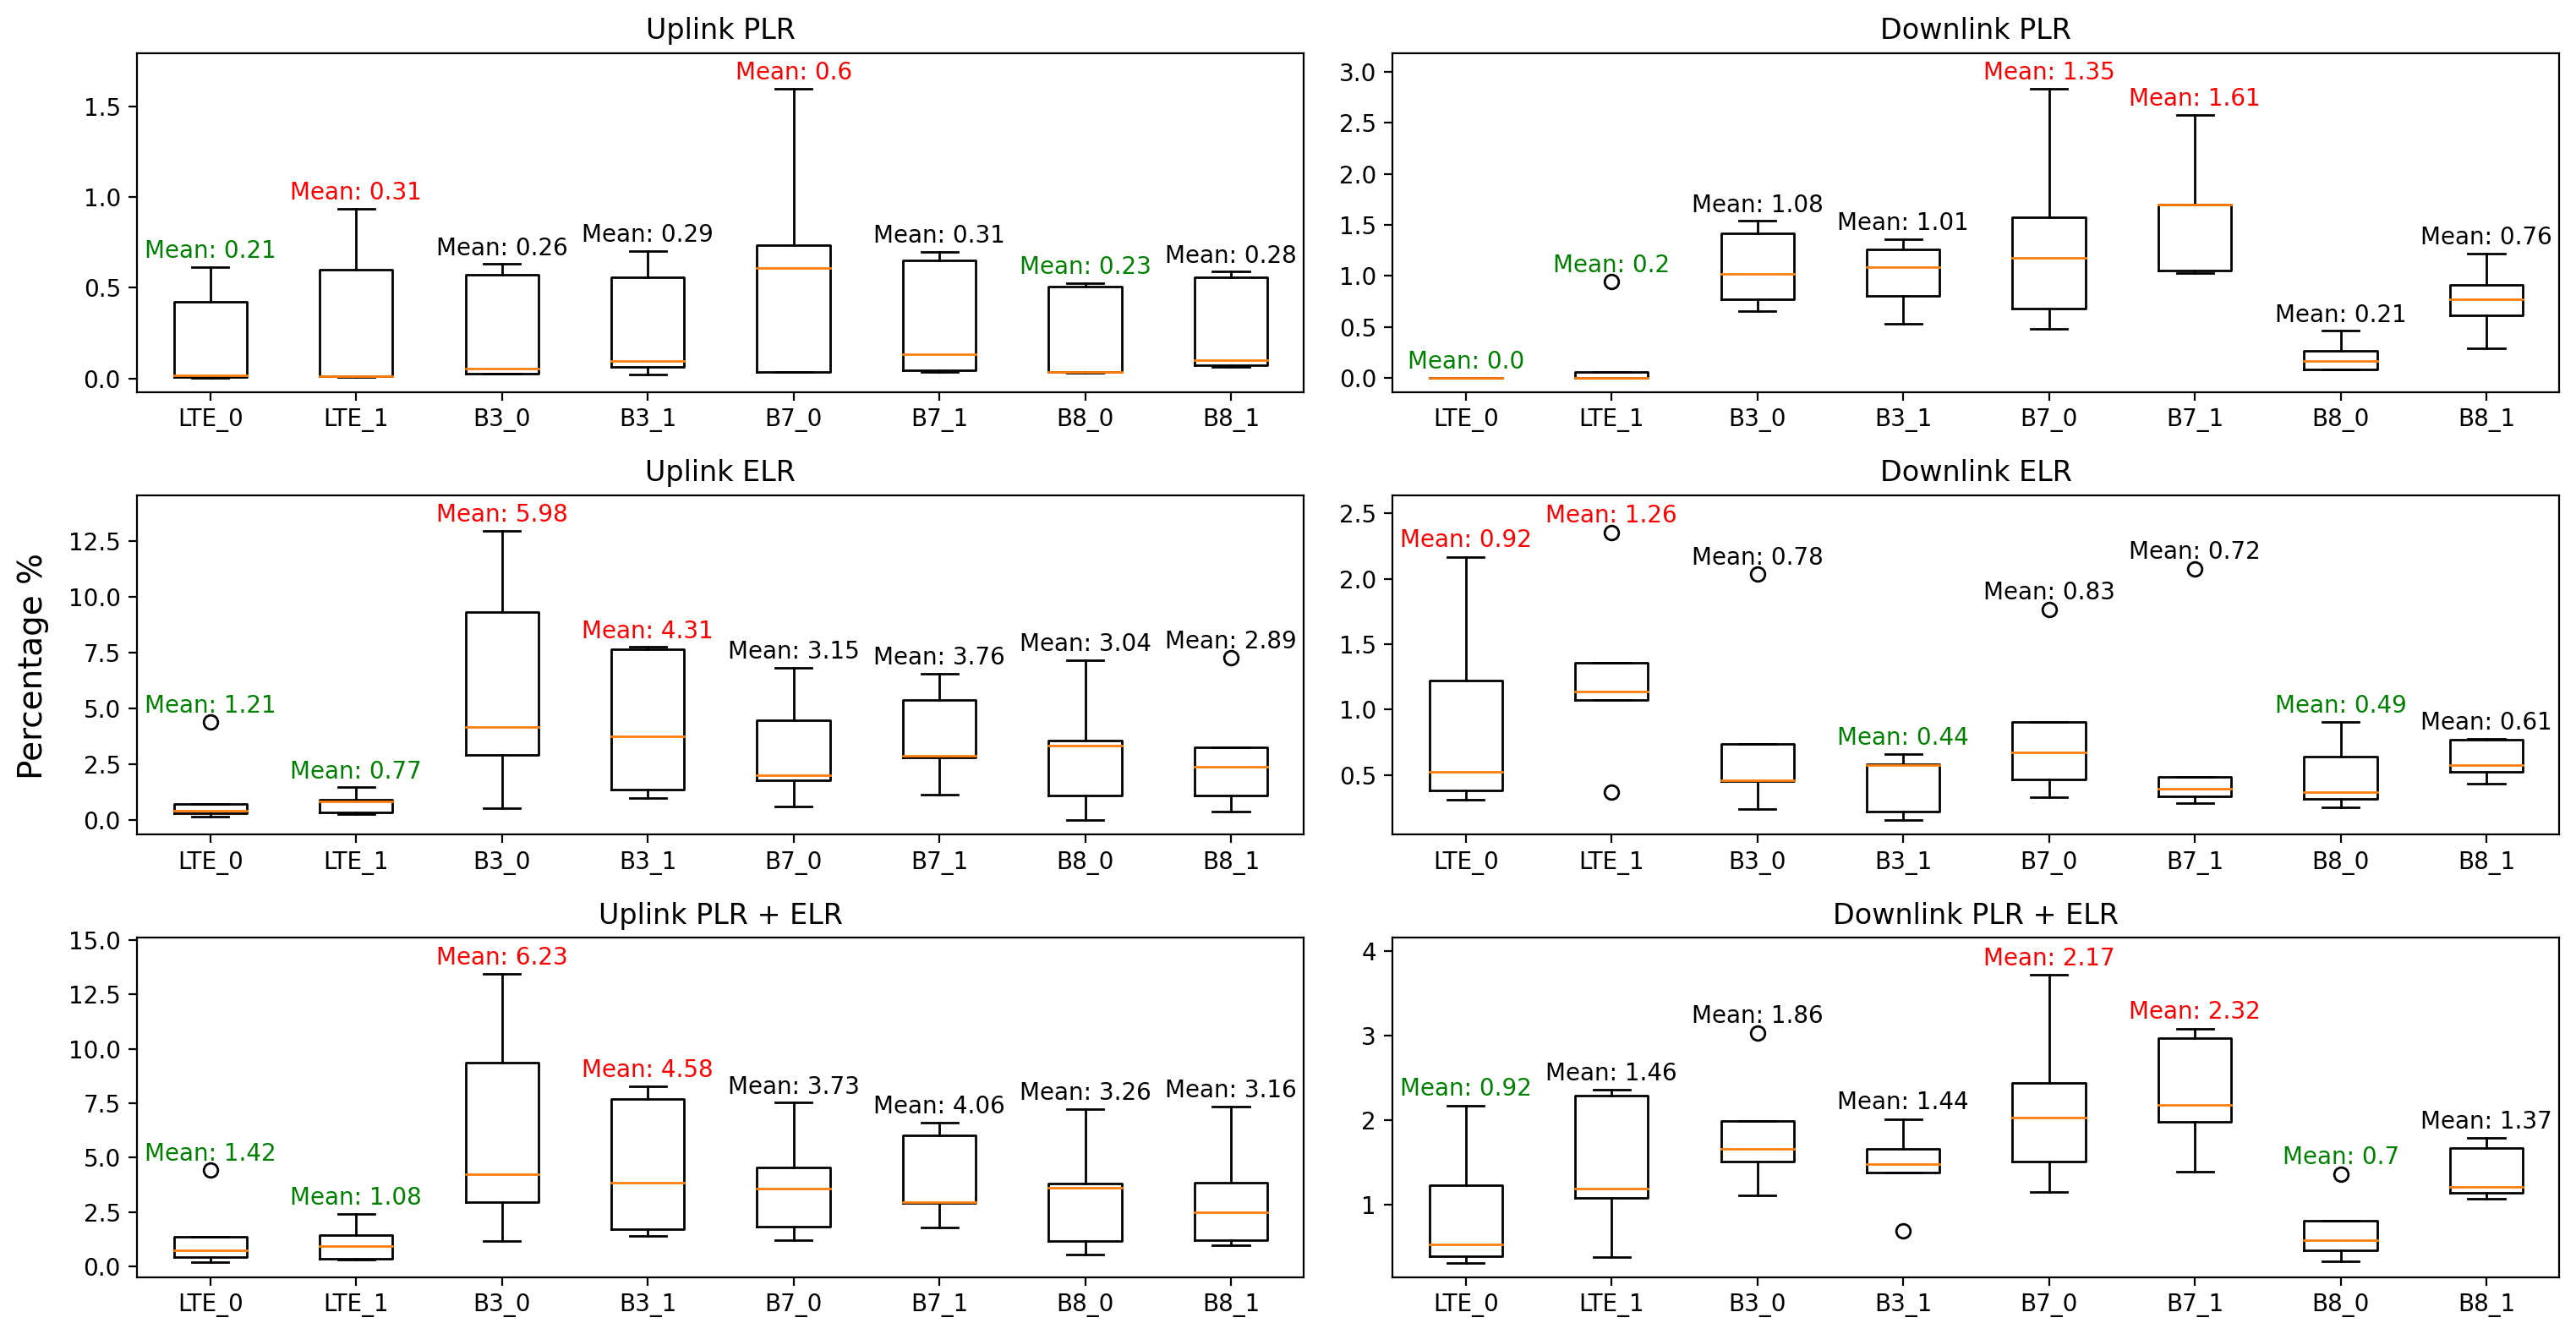

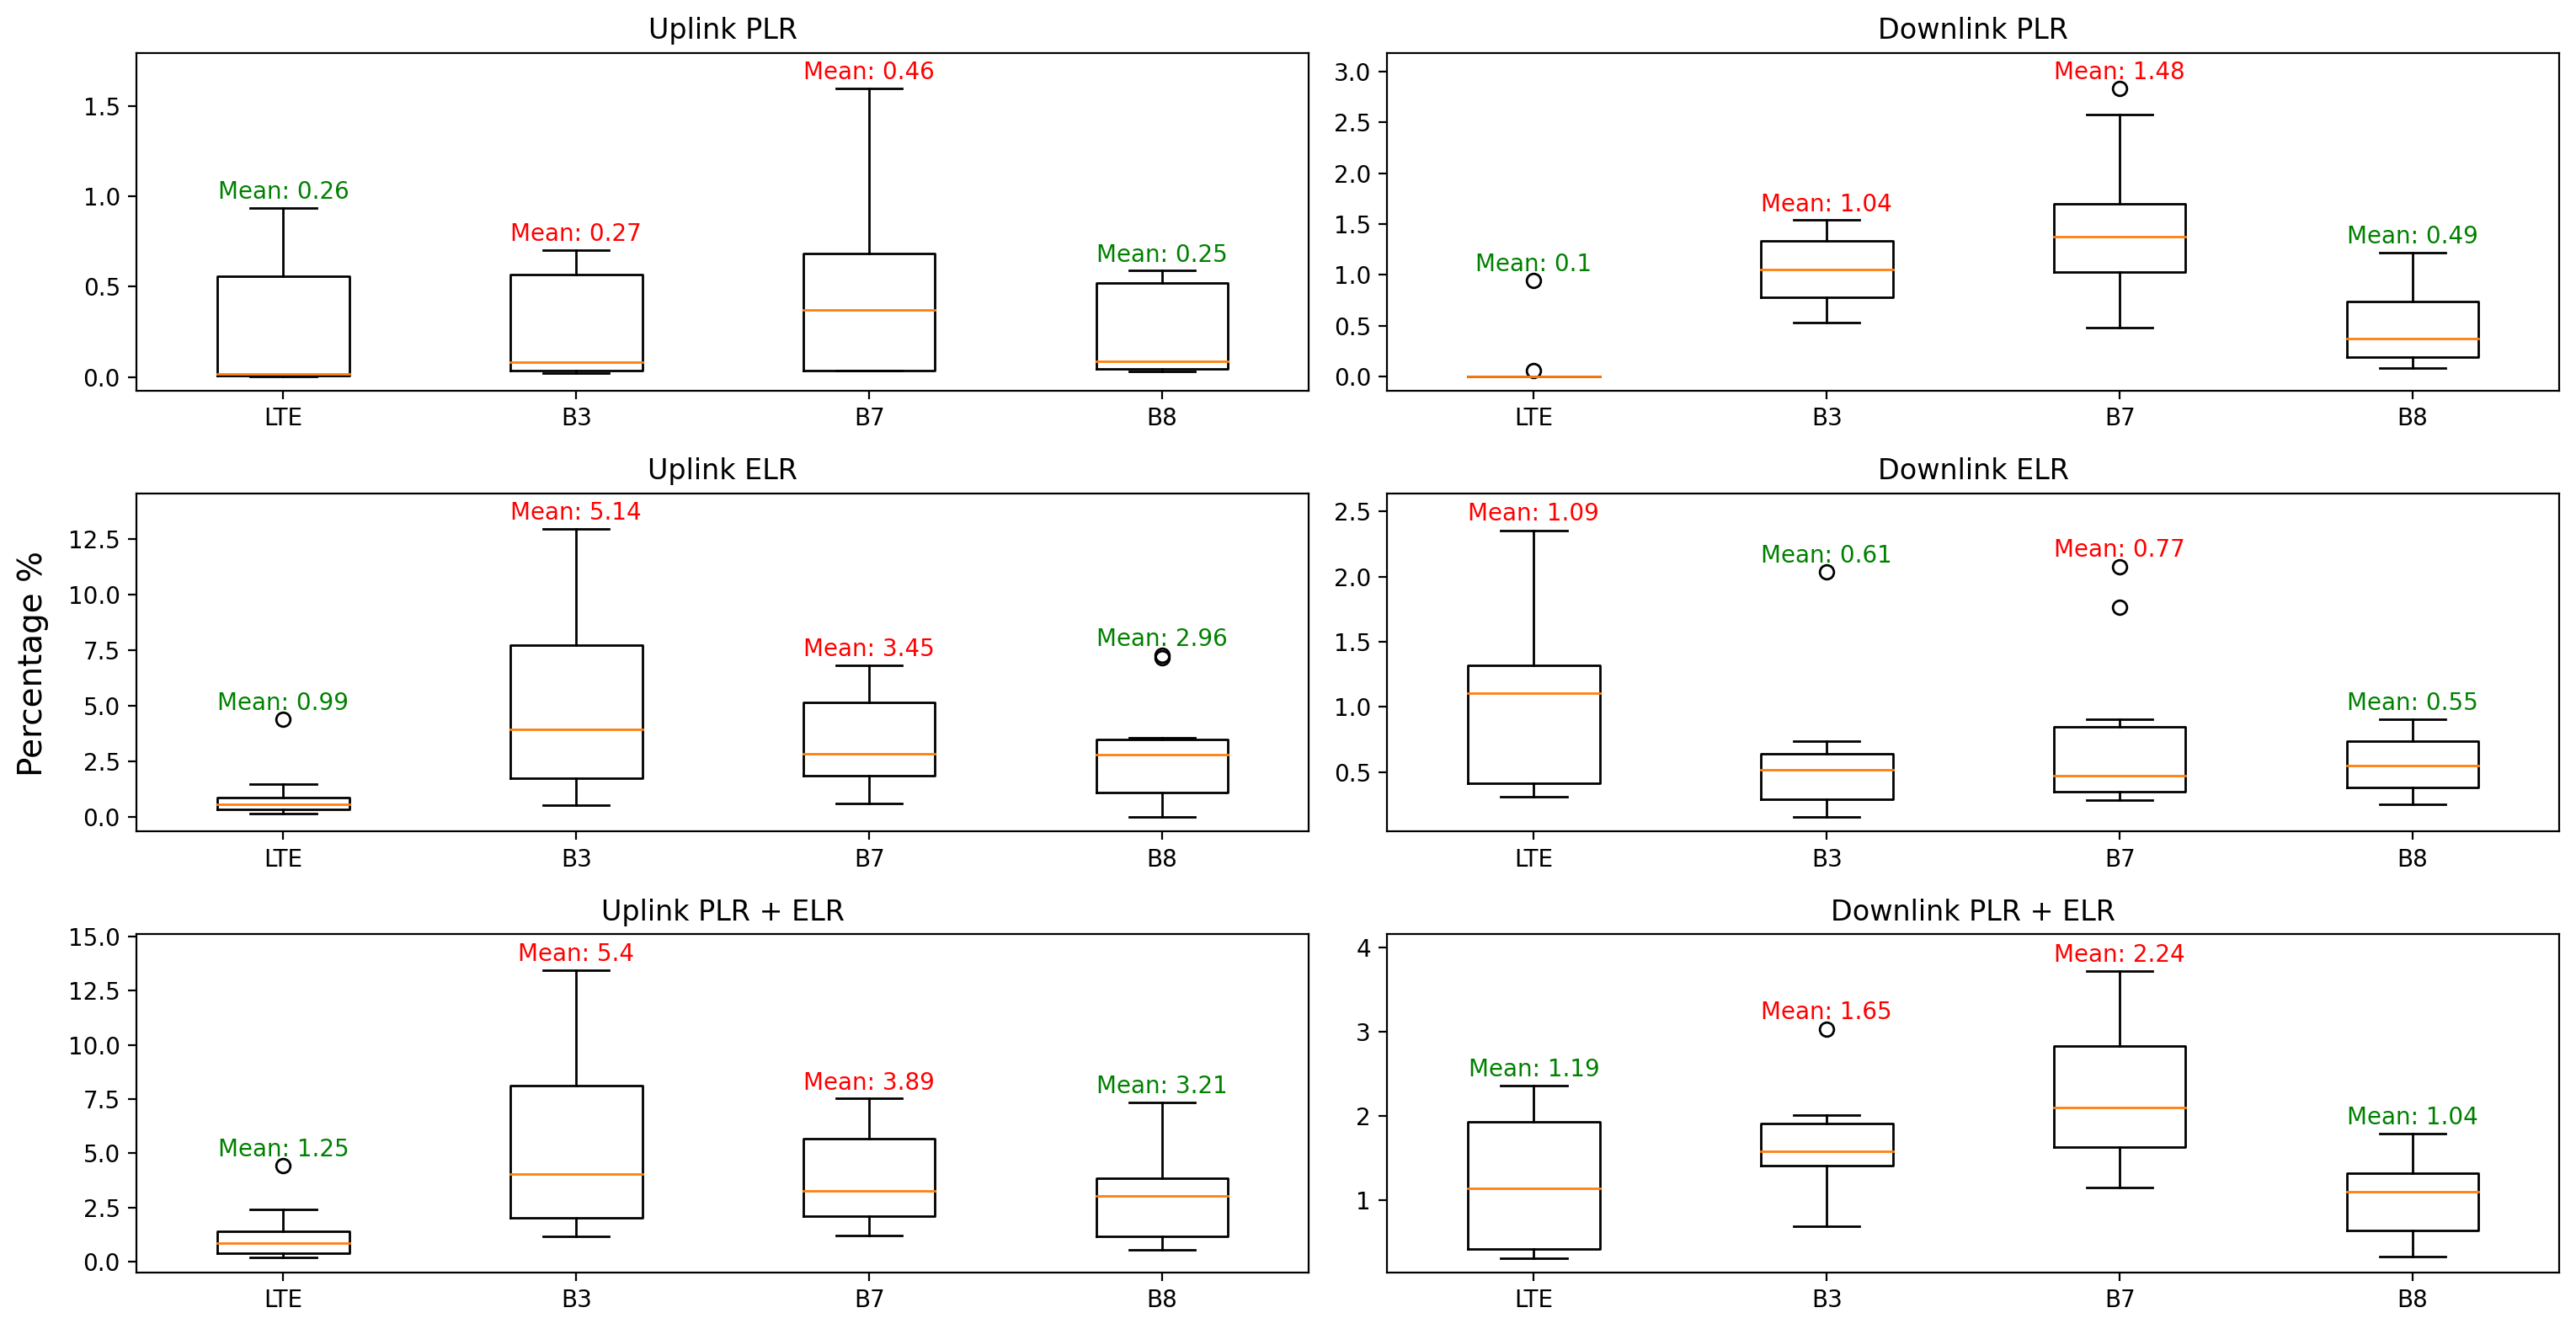

In [12]:
def remove_outliers(data_list):
    # 計算四分位數和四分位距
    Q1, Q3 = np.percentile(data_list, [25, 75])
    IQR = Q3 - Q1
    
    # 計算上下限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 去除異常值
    cleaned_list = [x for x in data_list if lower_bound <= x <= upper_bound]
    
    return cleaned_list

def plot_box_plot(ax, title, boxes, labels, top_n=2):
    
    ax.boxplot(boxes, labels=labels)
    ax.set_title(title)
    
    offset = ax.get_ylim()[1] * 0.03
    box_maximals = [max(sub_list) for sub_list in boxes]
    # TODO: remove outliers or not?
    # boxes = [remove_outliers(box_data) for box_data in boxes]
    
    box_means = [np.mean(sub_list) for sub_list in boxes]
    sorted_indices = np.argsort(box_means)
    for k, (mean_value, max_value) in enumerate(zip(box_means, box_maximals)):
        mean_value = round(mean_value, 2)
        
        if k in sorted_indices[:top_n]: # the smallest two schemes
            text_color = 'green'
        elif k in sorted_indices[-top_n:]: # the largest two schemes
            text_color = 'red'
        else:
            text_color = 'black'
            
        ax.text(k + 1, max_value + offset, f'Mean: {mean_value}', ha='center', fontsize=10, color=text_color)
        
    ax.set_ylim(top=ax.get_ylim()[1] * 1.07)

for expr, metrics_dict in zip(exp_list, single_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata.iloc[:, :-4])
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl', 'ul_loss_excl', 'dl_loss_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR']
    
    ### 繪製 Box Plot (1) 對每個 “device” 的數據繪圖
    fig, axes = plt.subplots(3, 2, figsize=(15, 8))
    
    for ax, tag, title in zip(axes.flatten(), tags, titles):
        boxes = [[num for num in v[tag] if num >= 0] for v in metrics_dict.values()]
        labels = add_suffix_to_duplicate_category([expr.setting[k] for k in metrics_dict.keys()])
        
        plot_box_plot(ax, title, boxes, labels)

    fig.text(-0.01, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    ### 繪製 Box Plot (2) 將相同 “設定” 不同 “device” 的數據合併繪圖
    fig, axes = plt.subplots(3, 2, figsize=(15, 8))
    
    for ax, tag, title in zip(axes.flatten(), tags, titles):
        new_dict = defaultdict(list)
        for dev, val in metrics_dict.items():
            schm = expr.setting[dev]
            new_dict[schm] += [num for num in val[tag] if num >= 0]

        boxes = list(new_dict.values())
        labels = new_dict.keys()
        
        plot_box_plot(ax, title, boxes, labels)

    fig.text(-0.01, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.show()

## Bar Chart: Per Round

In [13]:
data = {'#01': {'sm00': 8.0, 'sm01': 7.0, 'sm02': 5.0, 'sm03': 1.0, 'sm04': 3.0, 'sm05': 6.0, 'sm06': 2.0, 'sm07': 4.0}, 
 '#02': {'sm00': 5.0, 'sm01': 6.0, 'sm02': 1.0, 'sm03': 3.0, 'sm04': 4.0, 'sm05':  np.nan, 'sm06':  np.nan, 'sm07': 2.0}, 
 '#03': {'sm00': 2.0, 'sm01': 6.0, 'sm02': 8.0, 'sm03': 1.0, 'sm04': 7.0, 'sm05': 3.0, 'sm06': 5.0, 'sm07': 4.0}, 
 '#04': {'sm00': 2.0, 'sm01': 8.0, 'sm02': 7.0, 'sm03': 6.0, 'sm04': 4.0, 'sm05': 3.0, 'sm06': 1.0, 'sm07': 5.0}, 
 '#05': {'sm00': 8.0, 'sm01': 1.0, 'sm02': 4.0, 'sm03': 5.0, 'sm04': 7.0, 'sm05': 6.0, 'sm06': 2.0, 'sm07': 3.0}, 
 '#06': {'sm00': 4.0, 'sm01': 2.0, 'sm02': 3.0, 'sm03': 5.0, 'sm04': 7.0, 'sm05': 1.0, 'sm06': 6.0, 'sm07': 8.0}, 
 'Score': {'sm00': -3, 'sm01': -2, 'sm02': -1, 'sm03': 4, 'sm04': -3, 'sm05': 2, 'sm06': 4, 'sm07': -1}, 
 'Ranking': {'sm00': 7, 'sm01': 6, 'sm02': 4, 'sm03': 1, 'sm04': 8, 'sm05': 3, 'sm06': 2, 'sm07': 5}}

devices = ['sm00', 'sm01', 'sm02', 'sm03', 'sm04', 'sm05', 'sm06', 'sm07']
schemes = ['LTE_0', 'LTE_1', 'B3_0', 'B3_1', 'B7_0', 'B7_1', 'B8_0', 'B8_1']

updated_data = {k: {(dev, schm): v[dev] for dev, schm in zip(devices, schemes)}
                for k, v in data.items()}

# 轉換成 DataFrame 並設置兩層標頭
df = pd.DataFrame(updated_data).T
display(df)

sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   7.0  5.0  1.0  3.0  6.0  2.0  4.0
#02       5.0   6.0  1.0  3.0  4.0  NaN  NaN  2.0
#03       2.0   6.0  8.0  1.0  7.0  3.0  5.0  4.0
#04       2.0   8.0  7.0  6.0  4.0  3.0  1.0  5.0
#05       8.0   1.0  4.0  5.0  7.0  6.0  2.0  3.0
#06       4.0   2.0  3.0  5.0  7.0  1.0  6.0  8.0
Score    -3.0  -2.0 -1.0  4.0 -3.0  2.0  4.0 -1.0
Ranking   7.0   6.0  4.0  1.0  8.0  3.0  2.0  5.0

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #06     0.213181             1   
1   sm01  LTE  #01, #02, #03, #04, #06     0.313677             7   
2   sm02   B3  #01, #02, #03, #04, #06     0.261117             3   
3   sm03   B3  #01, #02, #03, #04, #06     0.288008             5   
4   sm04   B7  #01, #02, #03, #04, #06     0.600796             8   
5   sm05   B7  #01, #02, #03, #04, #06     0.311095             6   
6   sm06   B8  #01, #02, #03, #04, #06     0.225455             2   
7   sm07   B8  #01, #02, #03, #04, #06     0.277170             4   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.000000             1     1.208966             2     0.919915   
1     0.199828             2     0.768861             1     1.259045   
2     1.081235             6     5.980799             8     0.784830   
3     1.007013             5     4.308118             7     0.437925   
4     1.350004             7     3.147926             5     0.827589   
5     1.609289             8     3.756195             6     0.715994   
6     0.210307             3     3.037986             4     0.494916   
7     0.760469             4     2.889163             3     0.614197   

   dl_excl_rank  
0             7  
1             8  
2             5  
3             1  
4             6  
5             4  
6             2  
7             3

Uplink PLR Ranking:


sm00  sm01  sm02  sm03  sm04  sm05  sm06  sm07
        LTE_0 LTE_1  B3_0  B3_1  B7_0  B7_1  B8_0  B8_1
#01         5     3     6     8     4     7     1     2
#02         2     1     3     6     8     5     4     7
#03         1     2     7     3     5     4     6     8
#04         1     7     4     3     8     6     2     5
#05      <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
#06         2     1     3     7     4     8     5     6
Score       8     6     1    -1    -2    -1     5     0
Ranking     1     2     4     7     8     6     3     5

Downlink PLR Ranking:


sm00  sm01  sm02  sm03  sm04  sm05  sm06  sm07
        LTE_0 LTE_1  B3_0  B3_1  B7_0  B7_1  B8_0  B8_1
#01         1     2     4     7     6     8     3     5
#02         1     2     7     4     8     5     3     6
#03         1     2     7     5     6     8     4     3
#04         1     5     4     6     7     8     2     3
#05      <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
#06         1     2     7     6     4     8     3     5
Score      12     6    -1     1    -1    -6     3     2
Ranking     1     2     7     5     6     8     3     4

Uplink ELR Ranking:


sm00  sm01  sm02  sm03  sm04  sm05  sm06  sm07
        LTE_0 LTE_1  B3_0  B3_1  B7_0  B7_1  B8_0  B8_1
#01         5     6     3     7     4     8     1     2
#02         1     2     8     7     4     3     5     6
#03         1     2     7     5     8     6     4     3
#04         1     2     8     7     3     6     5     4
#05      <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
#06         8     1     5     7     2     4     6     3
Score       6     7    -3    -2     1     0     4     3
Ranking     2     1     8     7     5     6     3     4

Downlink ELR Ranking:


sm00  sm01  sm02  sm03  sm04  sm05  sm06  sm07
        LTE_0 LTE_1  B3_0  B3_1  B7_0  B7_1  B8_0  B8_1
#01         8     7     5     1     3     6     2     4
#02         7     8     1     4     5     6     2     3
#03         2     6     8     1     7     3     5     4
#04         2     8     7     6     4     3     1     5
#05      <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
#06         4     2     3     5     7     1     6     8
Score       1    -2     1     6     0     4     6     0
Ranking     5     8     4     2     7     3     1     6

Uplink PLR + ELR Ranking:


sm00  sm01  sm02  sm03  sm04  sm05  sm06  sm07
        LTE_0 LTE_1  B3_0  B3_1  B7_0  B7_1  B8_0  B8_1
#01         5     6     3     7     4     8     1     2
#02         1     2     8     7     6     3     4     5
#03         1     2     7     5     8     6     3     4
#04         1     2     8     7     3     6     4     5
#05      <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
#06         8     1     4     7     2     5     6     3
Score       6     7    -3    -2     1     0     4     3
Ranking     2     1     8     7     5     6     3     4

Downlink PLR + ELR Ranking:


sm00  sm01  sm02  sm03  sm04  sm05  sm06  sm07
        LTE_0 LTE_1  B3_0  B3_1  B7_0  B7_1  B8_0  B8_1
#01         5     2     3     6     7     8     1     4
#02         5     6     3     2     8     7     1     4
#03         1     4     8     2     7     6     5     3
#04         1     7     4     5     6     8     2     3
#05      <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>
#06         2     1     8     5     4     7     3     6
Score       7     4    -2     4    -2    -4     7     2
Ranking     2     4     7     3     6     8     1     5

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #01


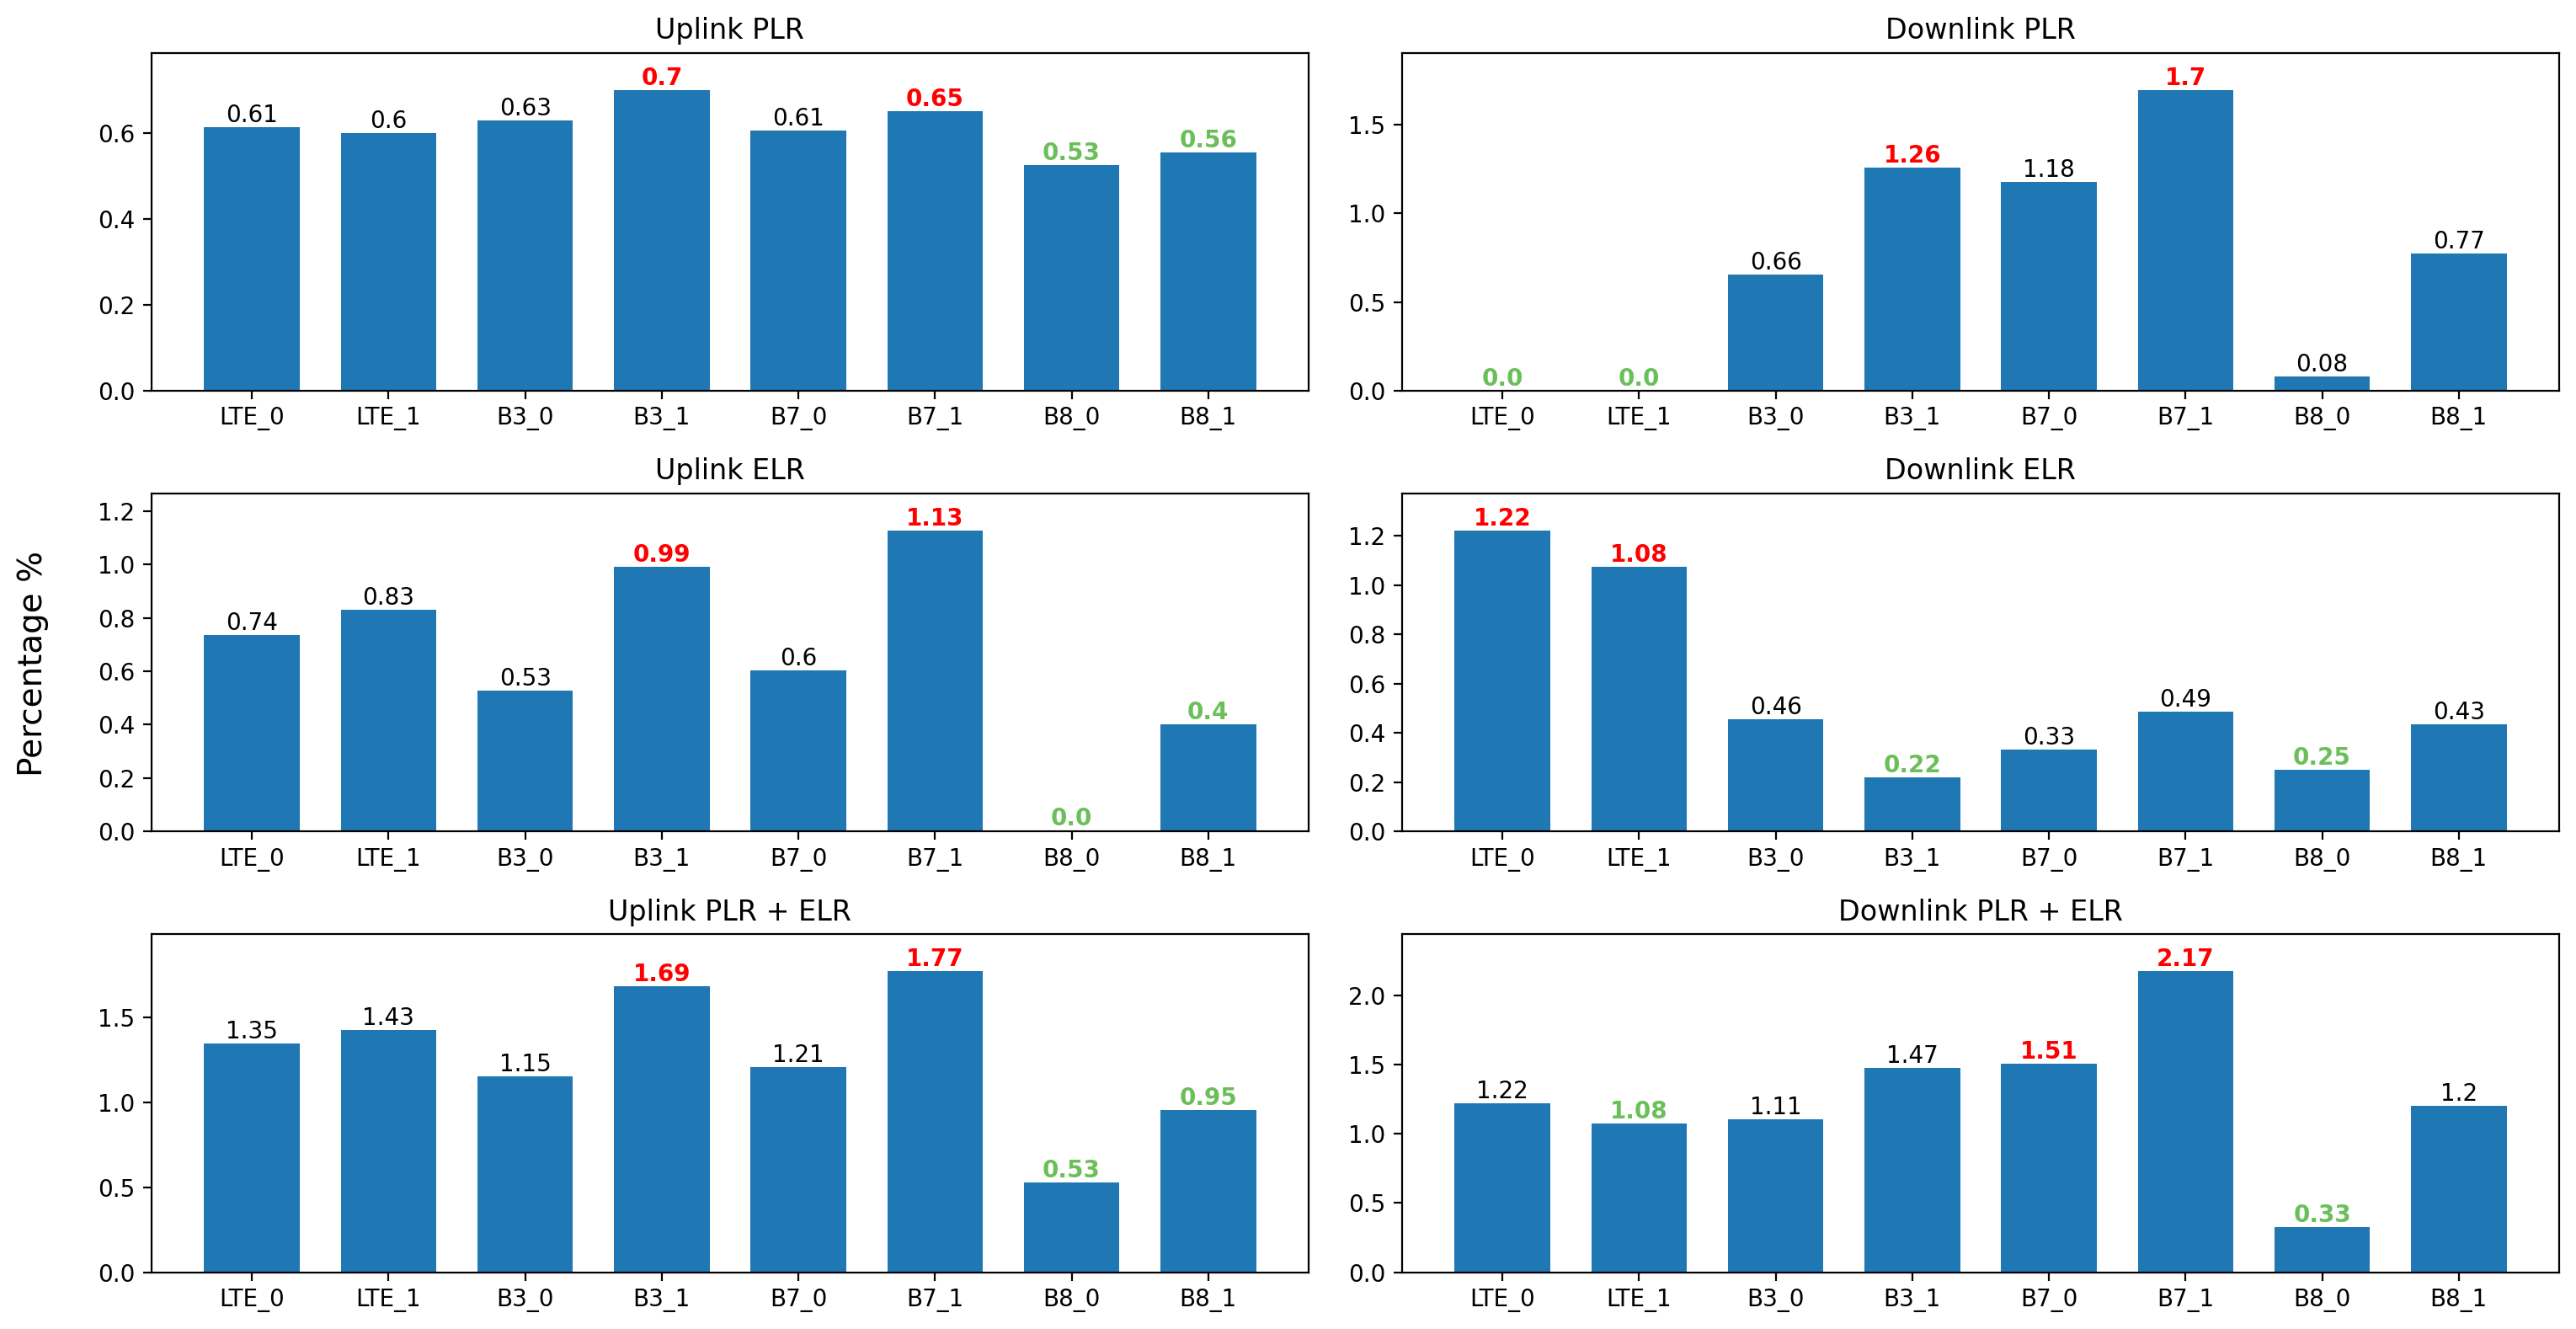

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #02


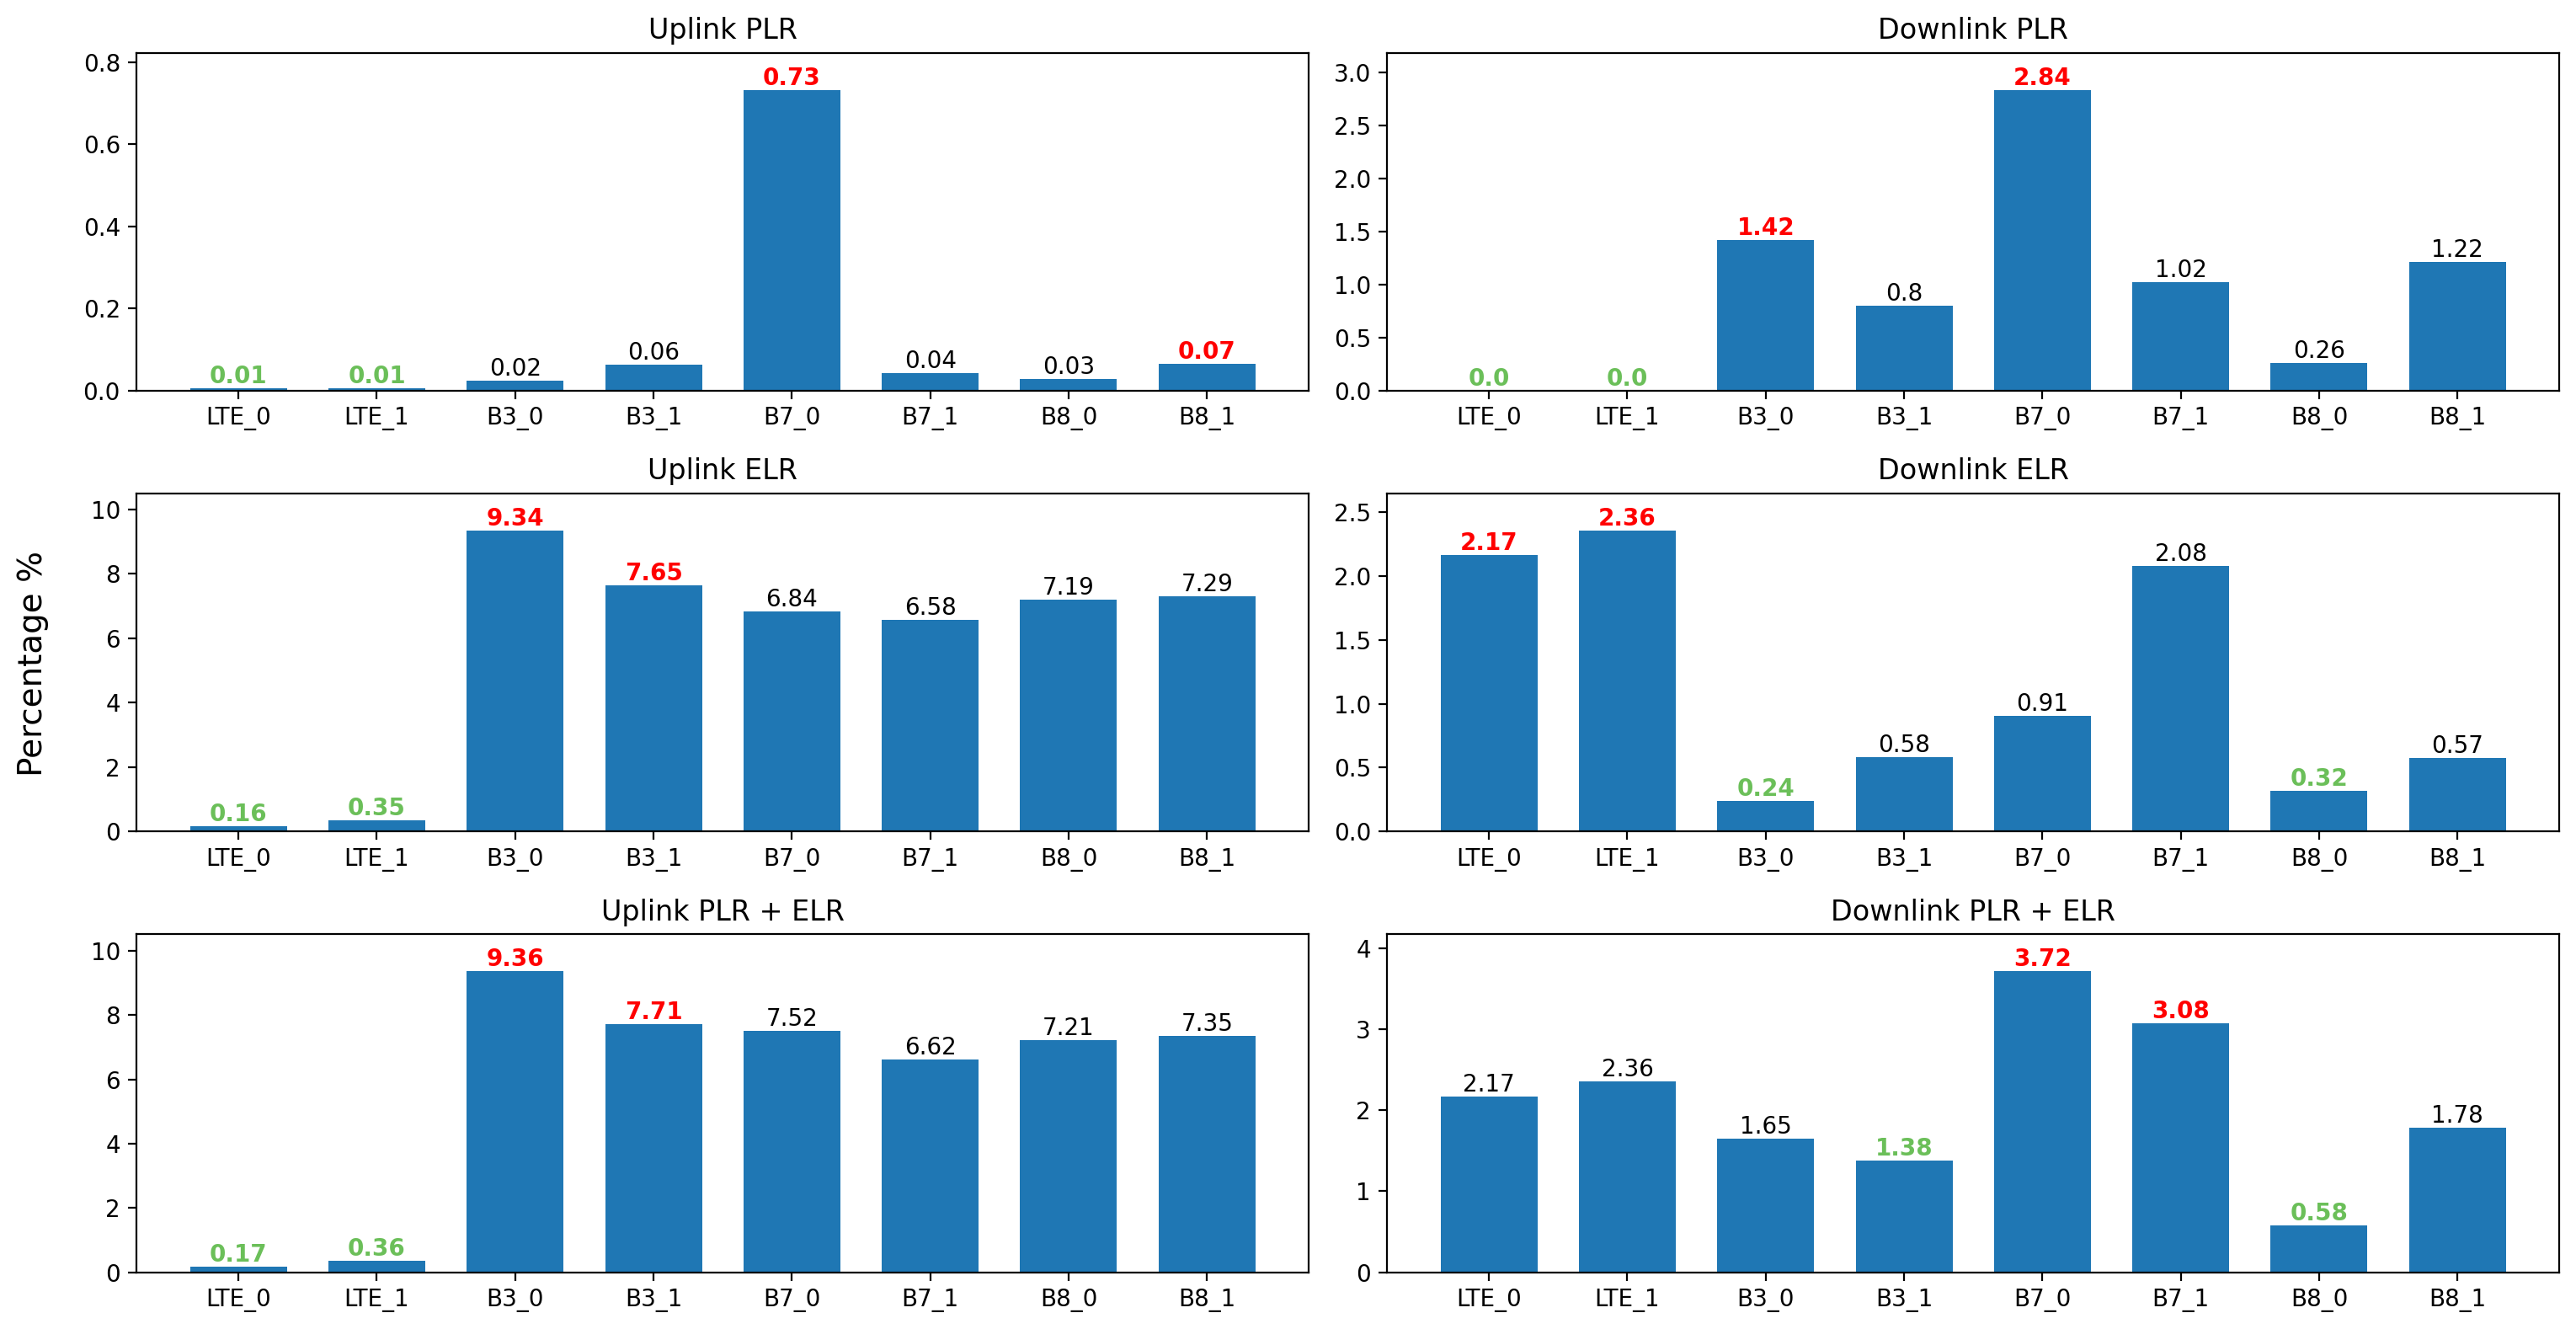

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #03


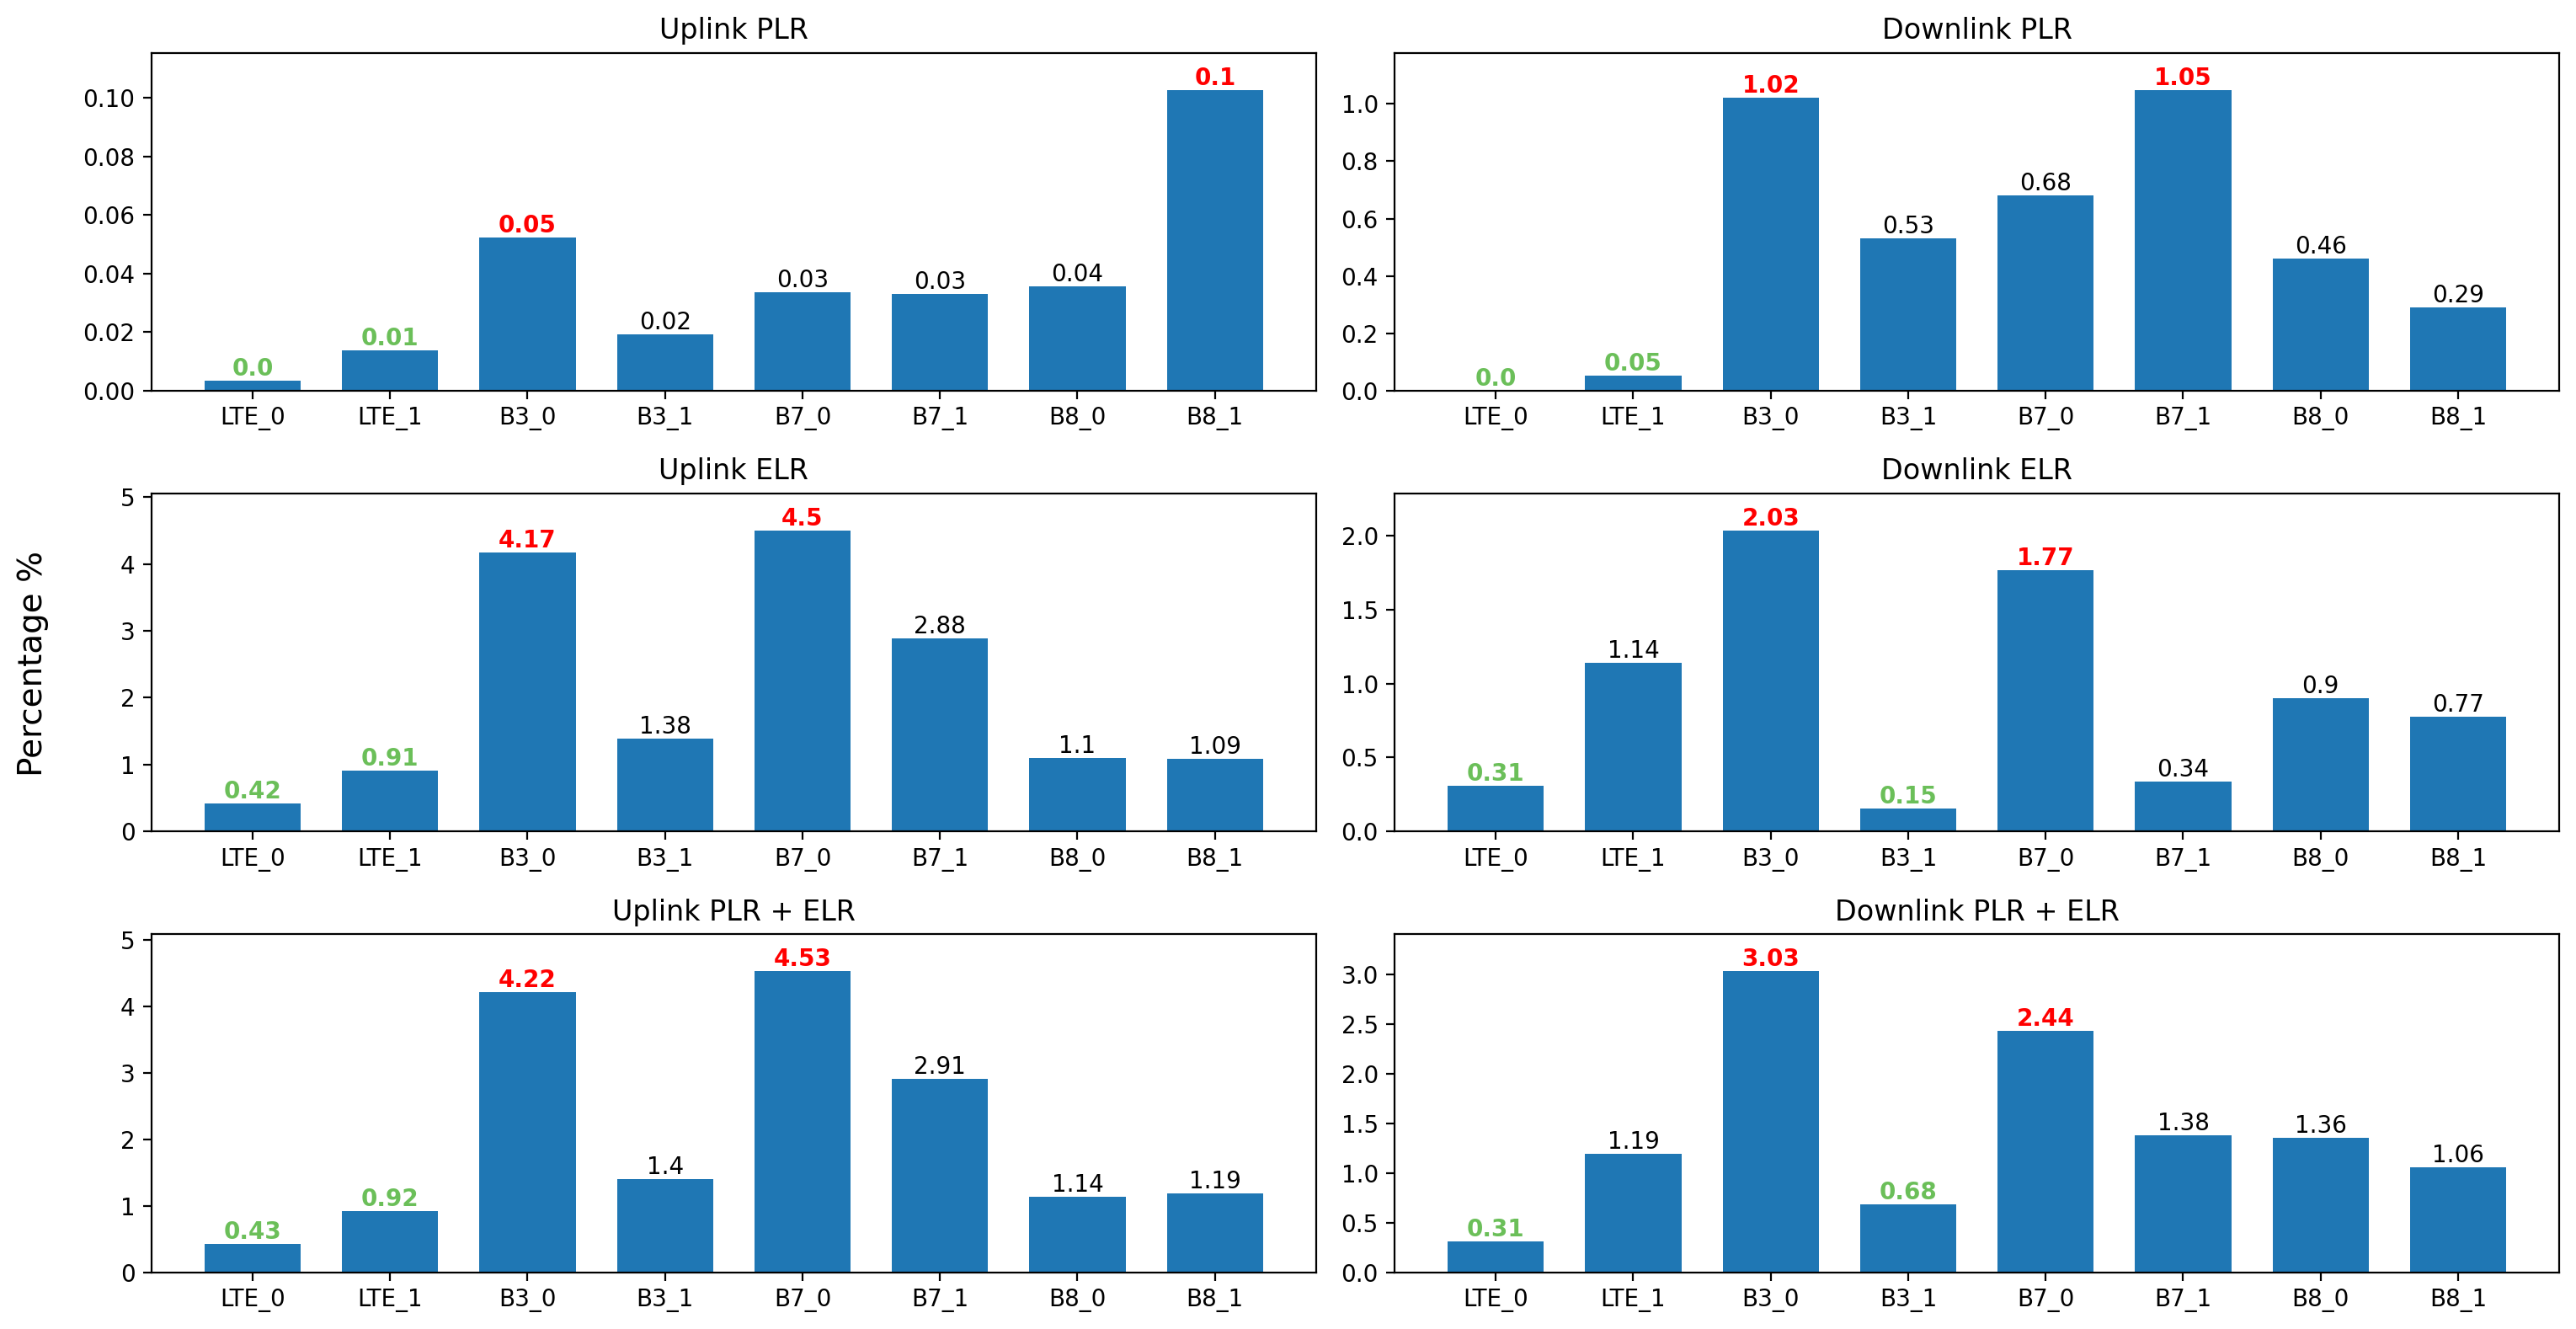

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #04


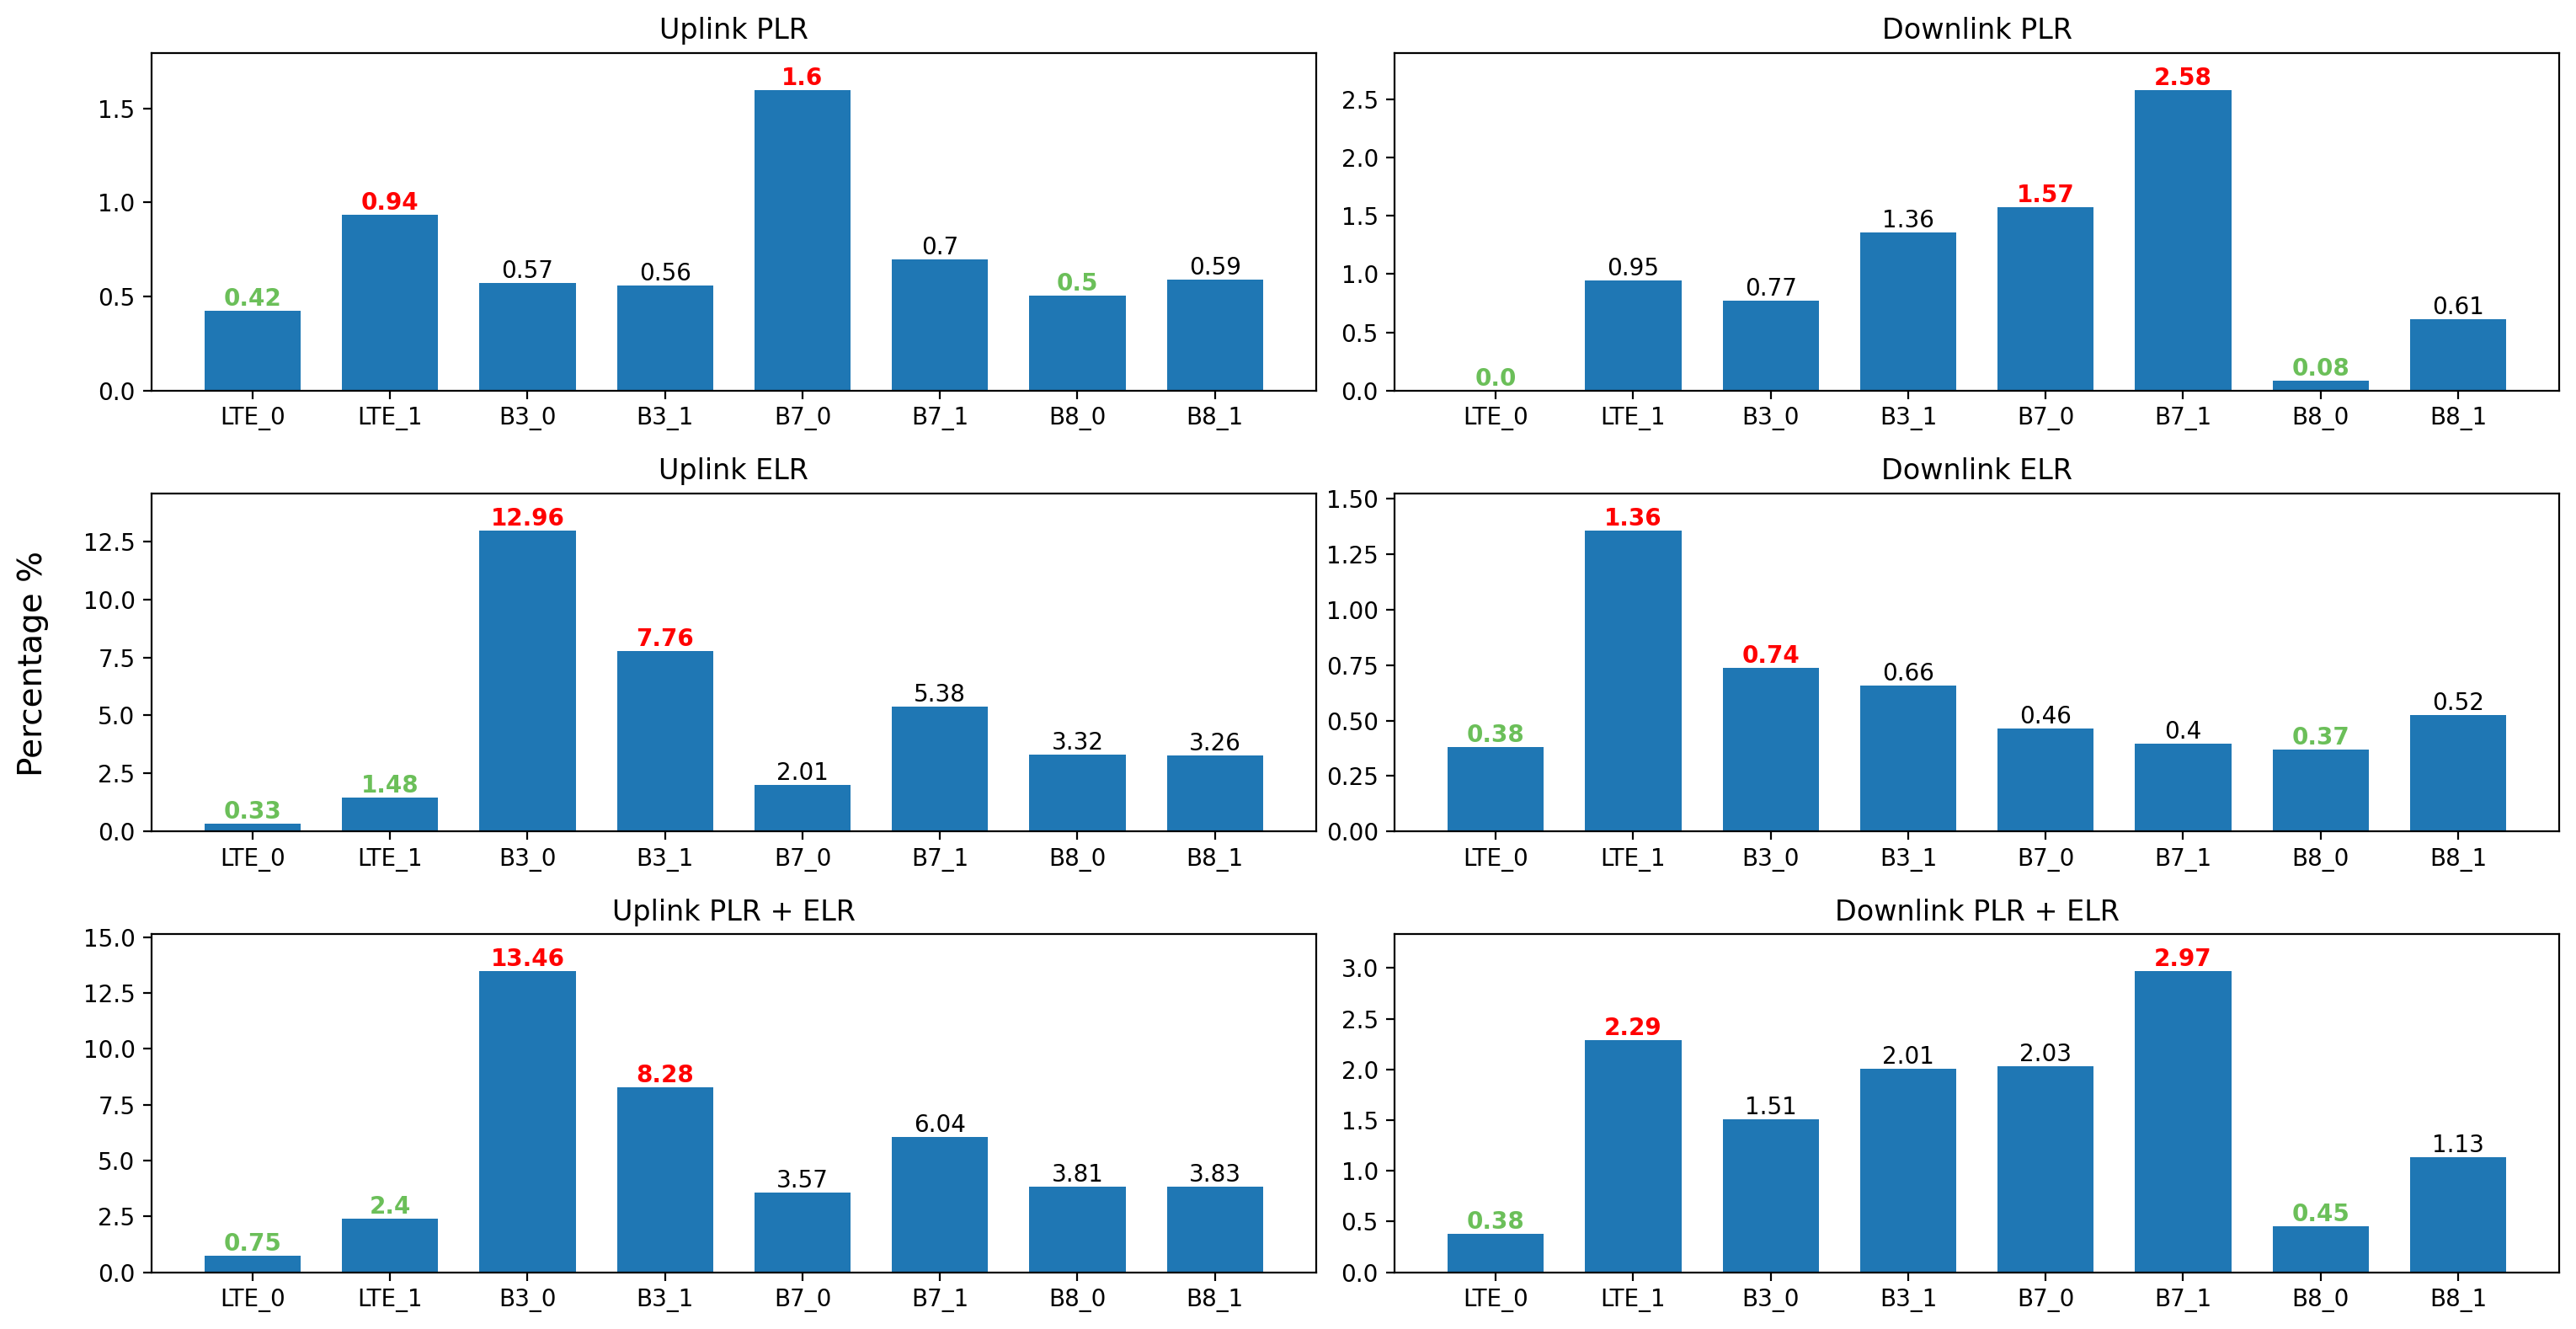

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #05


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_7815/1906784225.py:100: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 69540x1362 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x800 with 6 Axes>

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #06


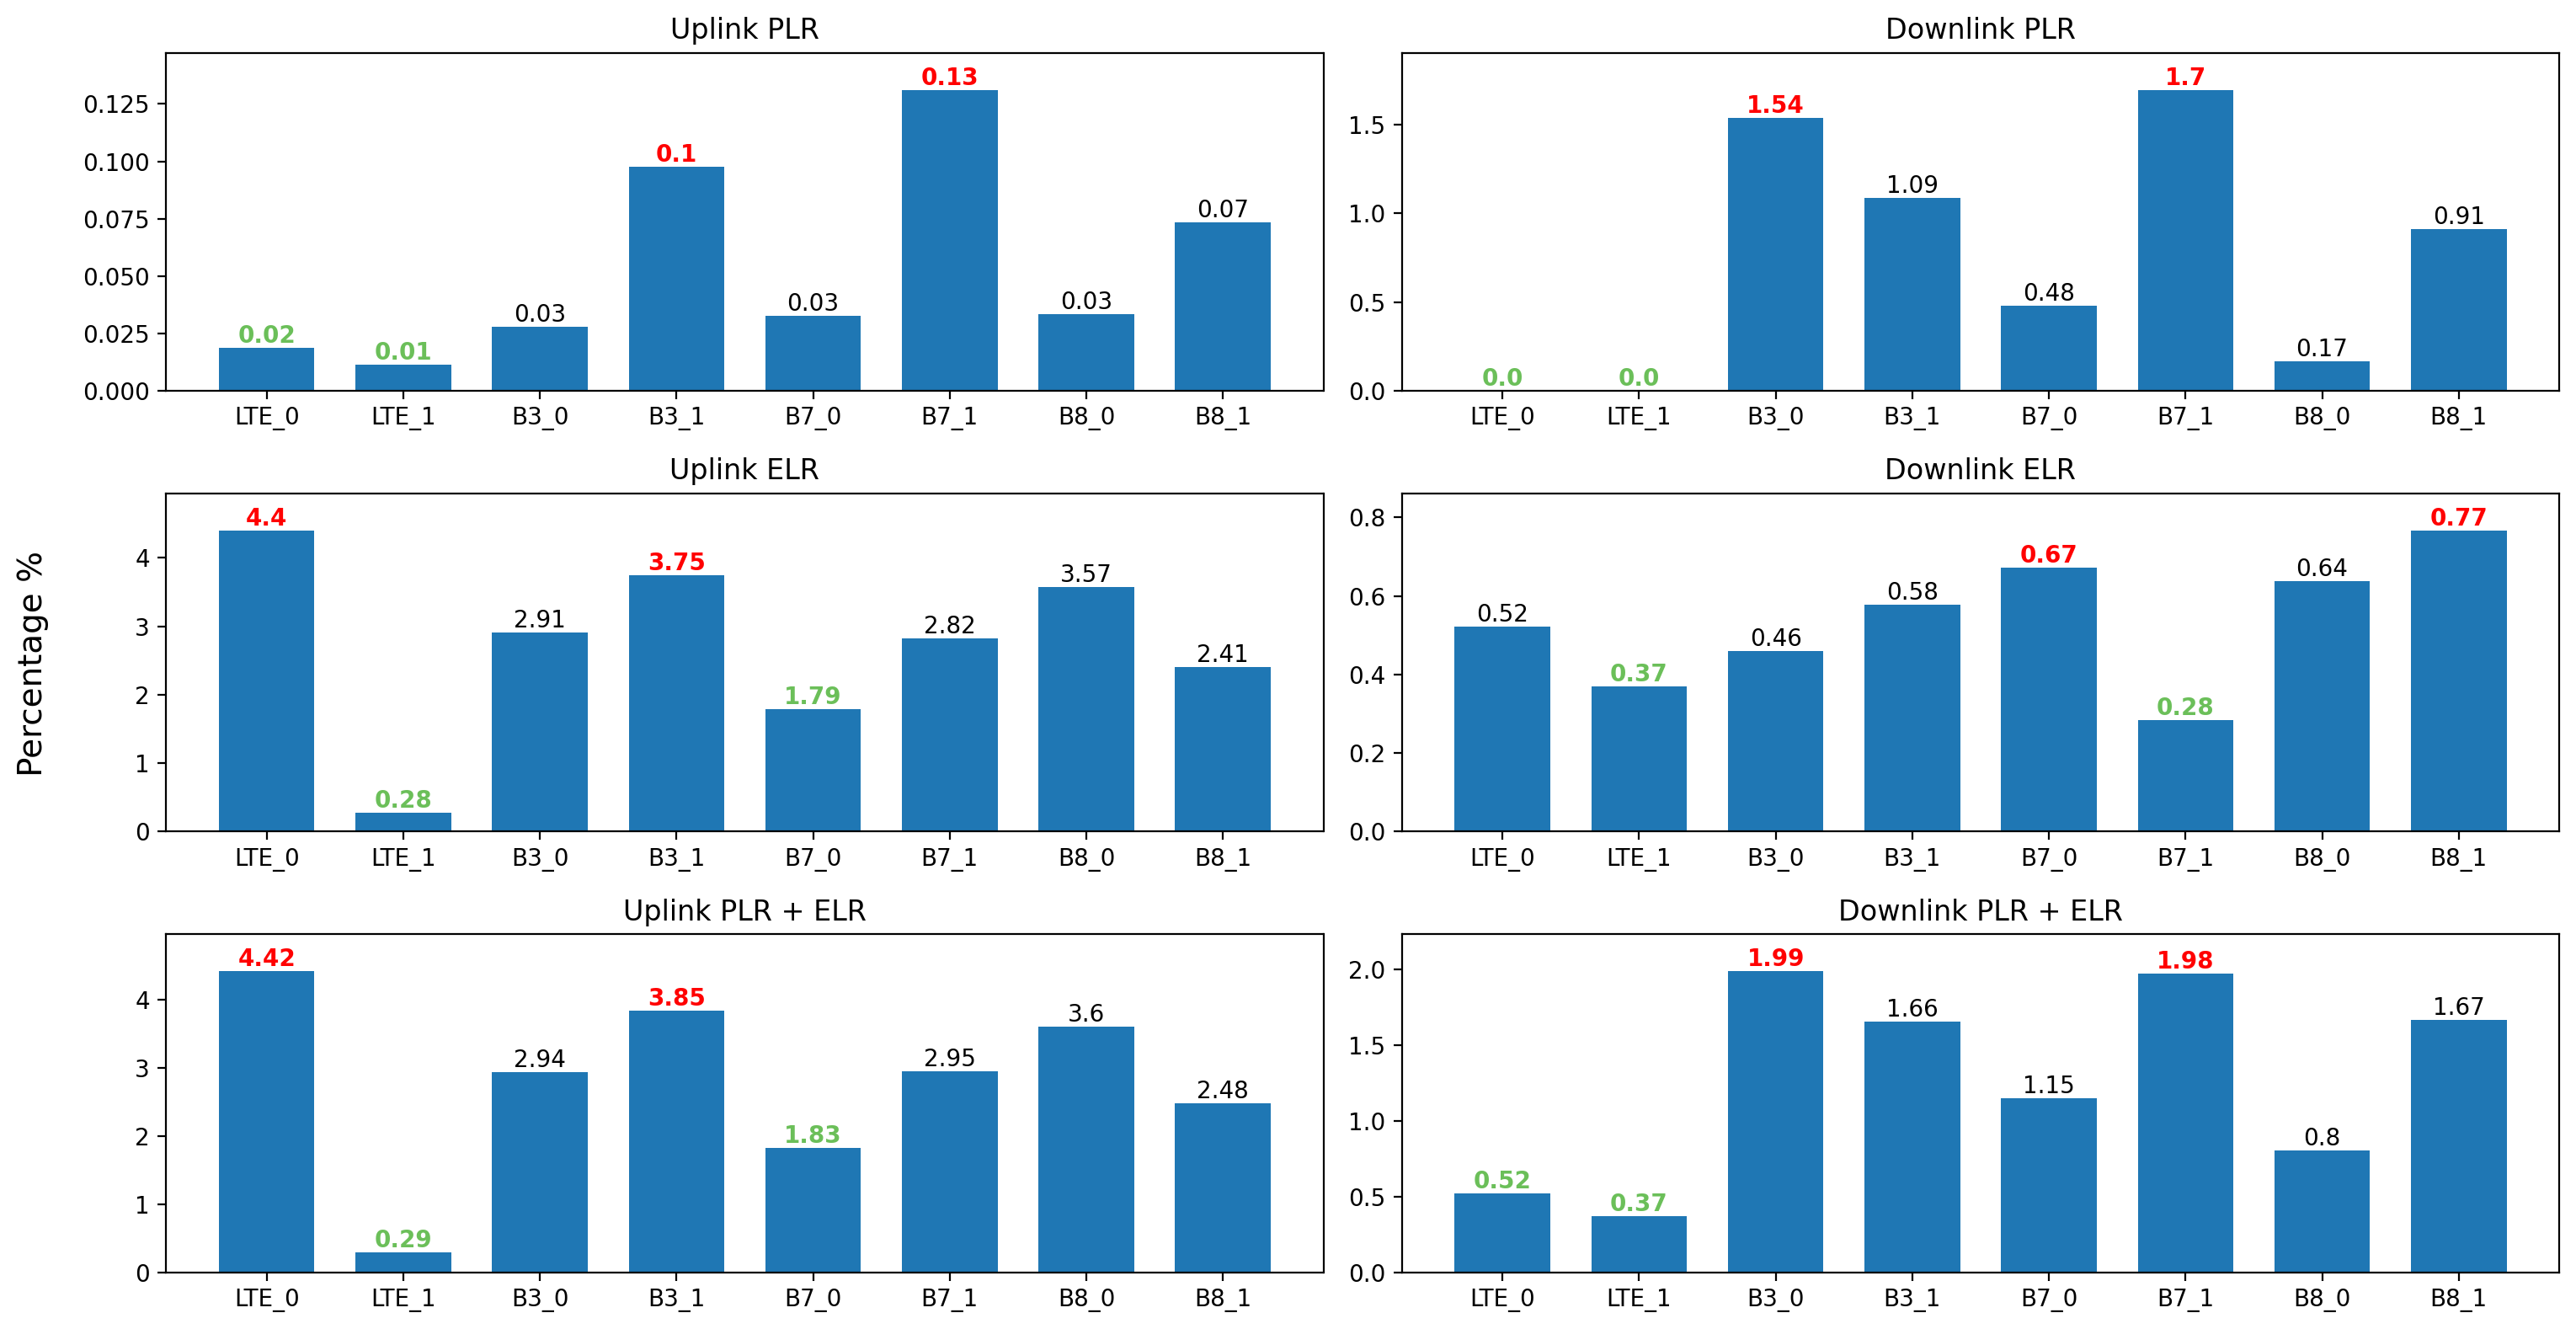

In [16]:
for expr, metrics_dict in zip(exp_list, single_metrics_list):
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata.iloc[:, :-4])
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl', 'ul_loss_excl', 'dl_loss_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR']

    # Score & Ranking
    devices = expr.setting.keys()
    for tag, title in zip(tags, titles):
        print(f'{title} Ranking:')
        
        data_dict = {k: v[tag] for k, v in metrics_dict.items()}
        ranking_dict = {}
        score_dict = {k: [] for k in devices}
        
        for i, tr in enumerate(expr.traces):
            # print(i, tr)
            data = [v[i] for v in data_dict.values()]
            data = [num if num >= 0 else np.inf for num in data]
            na_indices = [i for i, num in enumerate(data) if np.isinf(num)]
            
            ranking = np.argsort(np.argsort(data)) + 1
            ranking[na_indices] = -1
            ranking_dict[tr] = {k: v for k, v in zip(devices, ranking)}
            
            _ranking = [num for num in ranking if num != -1]
            _max = max(_ranking) if len(_ranking) != 0 else -1; _min = min(_ranking) if len(_ranking) != 0 else -1
            for k, rank in zip(devices, ranking):
                if rank == _min: score_dict[k].append(2)
                elif rank == _min + 1: score_dict[k].append(1)
                elif rank == _max - 1: score_dict[k].append(-1)
                elif rank == _max: score_dict[k].append(-2)
                else: score_dict[k].append(0)
        
        score = [sum(v) for v in score_dict.values()]
        ranking_dict['Score'] = {k: v for k, v in zip(devices, score)}
        
        # 降冪排列
        score_ranking = np.argsort(np.argsort(score)[::-1]) + 1
        ranking_dict['Ranking'] = {k: v for k, v in zip(devices, score_ranking)}
        
        # 轉換成兩層標頭的 DataFrame
        devices = expr.setting.keys()
        schemes = add_suffix_to_duplicate_category(expr.setting.values())
        updated_data = {k: {(dev, schm): v[dev] for dev, schm in zip(devices, schemes)}
                        for k, v in ranking_dict.items()}
        ranking_table = pd.DataFrame(updated_data).T
        
        # 將 -1 改成 pd.NA
        rows_to_check = ranking_table.index[:-2]
        ranking_table.loc[rows_to_check] = ranking_table.loc[rows_to_check].applymap(lambda x: pd.NA if x == -1 else x)
        
        expr.ranking[tag] = ranking_table
        display(ranking_table)
    
    # 建立表格方便製圖
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
        
    # 繪製 Bar Charts
    for idx, tr in enumerate(expr.traces):
        print(f'{expr.date} | {expr.name} -> {tr}')
        
        fig, axes = plt.subplots(3, 2, figsize=(15, 8))
        for ax, tag, title in zip(axes.flatten(), tags, titles):
            
            # Sample data including N/A values
            categories = add_suffix_to_duplicate_category([expr.setting[k] for k in metrics_dict.keys()])
            values = [num if num != '-' else np.nan for num in metrics_table[tag].iloc[idx].tolist()[1:]]
            
            # Create a bar chart using ax.bar()
            ax.bar(categories, values, width=0.7)
            ax.set_title(title)
            
            top_n = 2
            min_values = sorted([v for v in values if not np.isnan(v)])[:top_n]
            max_values = sorted([v for v in values if not np.isnan(v)], reverse=True)[:top_n]
            
            for k, v in enumerate(values):
                if not np.isnan(v):
                    label_color = '#6BBF59' if v in min_values else ('red' if v in max_values else 'black')  # '#6BBF59' is green
                    label_fontweight = 'bold' if v in min_values else ('bold' if v in max_values else 'normal')
                    
                    ax.text(k, v, str(round(v, 2)), ha='center', va='bottom', color=label_color, fontweight=label_fontweight)

                if np.isnan(v):
                    ax.text(k, 0, "N/A", ha='center', va='bottom', color='blue', fontweight='bold')
            
            ax.set_ylim(top=ax.get_ylim()[1]*1.07)
        
        fig.text(-0.01, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
    
        plt.tight_layout()
        plt.show()

# Dual Radio

In [17]:
# GLOBAL VARIABLE !!!
dual_metrics_list = []

for expr in exp_list:
    metrics_dict = {}
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    
    # Single Radio
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    for (dev, ul_paths), dl_paths, schm in tqdm(zip(expr.ul_paths.items(), expr.dl_paths.values(), schemes), ncols=1000):
        # print(dev)
        
        metrics_dict[schm] = {}
        ul_loss_rates, ul_excl_rates, ul_loss_excl_rates = [], [], []
        dl_loss_rates, dl_excl_rates, dl_loss_excl_rates = [], [], []
        
        for ul_path, dl_path in zip(ul_paths, dl_paths):
            ul_loss_rate, ul_excl_rate, ul_loss_excl_rate = calc_loss_excl_rate(ul_path)
            dl_loss_rate, dl_excl_rate, dl_loss_excl_rate = calc_loss_excl_rate(dl_path)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate); ul_loss_excl_rates.append(ul_loss_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate); dl_loss_excl_rates.append(dl_loss_excl_rate)
            
        metrics_dict[schm]['ul_loss'] = ul_loss_rates
        metrics_dict[schm]['ul_excl'] = ul_excl_rates
        metrics_dict[schm]['ul_loss_excl'] = ul_loss_excl_rates
        metrics_dict[schm]['dl_loss'] = dl_loss_rates
        metrics_dict[schm]['dl_excl'] = dl_excl_rates
        metrics_dict[schm]['dl_loss_excl'] = dl_loss_excl_rates
    
    # Dual Radio
    devices = list(it.combinations(expr.setting.keys(), 2))
    schemes = list(it.combinations(add_suffix_to_duplicate_category(expr.setting.values()), 2))
    for (dev1, dev2), schm in tqdm(zip(devices, schemes), ncols=1000):
        # print(dev1, dev2)
        schm = '+'.join(schm)
        
        ul_paths1 = expr.ul_paths[dev1]; ul_paths2 = expr.ul_paths[dev2]
        dl_paths1 = expr.dl_paths[dev1]; dl_paths2 = expr.dl_paths[dev2]
        
        metrics_dict[schm] = {}
        ul_loss_rates, ul_excl_rates, ul_loss_excl_rates = [], [], []
        dl_loss_rates, dl_excl_rates, dl_loss_excl_rates = [], [], []
        
        for ul_path1, ul_path2, dl_path1, dl_path2 in zip(ul_paths1, ul_paths2, dl_paths1, dl_paths2):
            ul_loss_rate, ul_excl_rate, ul_loss_excl_rate = calc_dual_loss_excl_rate(ul_path1, ul_path2)
            dl_loss_rate, dl_excl_rate, dl_loss_excl_rate = calc_dual_loss_excl_rate(dl_path1, dl_path2)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate); ul_loss_excl_rates.append(ul_loss_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate); dl_loss_excl_rates.append(dl_loss_excl_rate)
        
        metrics_dict[schm]['ul_loss'] = ul_loss_rates
        metrics_dict[schm]['ul_excl'] = ul_excl_rates
        metrics_dict[schm]['ul_loss_excl'] = ul_loss_excl_rates
        metrics_dict[schm]['dl_loss'] = dl_loss_rates
        metrics_dict[schm]['dl_excl'] = dl_excl_rates
        metrics_dict[schm]['dl_loss_excl'] = dl_loss_excl_rates
    
    dual_metrics_list.append(metrics_dict)
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl', 'ul_loss_excl', 'dl_loss_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR']
    
    # Display Table
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    # Single Ranking
    print('Single Radio Ranking')
    display(expr.metadata.iloc[:, :-4])
    
    # Dual Ranking
    size = len(expr.setting)
    expr.metadata_dual = None
    
    for tag in tags:
        data = [np.mean([num for num in v[tag] if num >= 0]) for v in metrics_dict.values()][size:]
        ranking = np.argsort(np.argsort(data)) + 1

        if expr.metadata_dual is None:
            schemes = metrics_table[tag].columns[1:size+1]
            schm_list = metrics_table[tag].columns[size+1:]
            
            traces = []
            traces_dict = {k: v.split(', ') for k, v in zip(schemes, expr.dev_traces.values())}
            for schms in schm_list:
                schm1 = schms.split('+')[0]; schm2 = schms.split('+')[1]
                traces.append(', '.join(sorted(list(set(traces_dict[schm1]) & set(traces_dict[schm2])))))
            
            expr.metadata_dual = pd.DataFrame({'Schm': schm_list, 'Traces': traces})
        
        expr.metadata_dual[f'avg_{tag}'] = data
        expr.metadata_dual[f'{tag}_rank'] = ranking

    print('Dual Radio Ranking:')
    display(expr.metadata_dual.iloc[:, :-4])

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Single Radio Ranking


Device Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #06     0.213181             1   
1   sm01  LTE  #01, #02, #03, #04, #06     0.313677             7   
2   sm02   B3  #01, #02, #03, #04, #06     0.261117             3   
3   sm03   B3  #01, #02, #03, #04, #06     0.288008             5   
4   sm04   B7  #01, #02, #03, #04, #06     0.600796             8   
5   sm05   B7  #01, #02, #03, #04, #06     0.311095             6   
6   sm06   B8  #01, #02, #03, #04, #06     0.225455             2   
7   sm07   B8  #01, #02, #03, #04, #06     0.277170             4   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.000000             1     1.208966             2     0.919915   
1     0.199828             2     0.768861             1     1.259045   
2     1.081235             6     5.980799             8     0.784830   
3     1.007013             5     4.308118             7     0.437925   
4     1.350004             7     3.147926             5     0.827589   
5     1.609289             8     3.756195             6     0.715994   
6     0.210307             3     3.037986             4     0.494916   
7     0.760469             4     2.889163             3     0.614197   

   dl_excl_rank  
0             7  
1             8  
2             5  
3             1  
4             6  
5             4  
6             2  
7             3

Dual Radio Ranking:


Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #06     0.020577            22   
1    LTE_0+B3_0  #01, #02, #03, #04, #06     0.014504            12   
2    LTE_0+B3_1  #01, #02, #03, #04, #06     0.015193            14   
3    LTE_0+B7_0  #01, #02, #03, #04, #06     0.014502            11   
4    LTE_0+B7_1  #01, #02, #03, #04, #06     0.013901             8   
5    LTE_0+B8_0  #01, #02, #03, #04, #06     0.013805             7   
6    LTE_0+B8_1  #01, #02, #03, #04, #06     0.013586             5   
7    LTE_1+B3_0  #01, #02, #03, #04, #06     0.019779            21   
8    LTE_1+B3_1  #01, #02, #03, #04, #06     0.019222            20   
9    LTE_1+B7_0  #01, #02, #03, #04, #06     0.033585            26   
10   LTE_1+B7_1  #01, #02, #03, #04, #06     0.021072            23   
11   LTE_1+B8_0  #01, #02, #03, #04, #06     0.021254            24   
12   LTE_1+B8_1  #01, #02, #03, #04, #06     0.017283            19   
13    B3_0+B3_1  #01, #02, #03, #04, #06     0.016744            17   
14    B3_0+B7_0  #01, #02, #03, #04, #06     0.032541            25   
15    B3_0+B7_1  #01, #02, #03, #04, #06     0.017160            18   
16    B3_0+B8_0  #01, #02, #03, #04, #06     0.011158             2   
17    B3_0+B8_1  #01, #02, #03, #04, #06     0.014297             9   
18    B3_1+B7_0  #01, #02, #03, #04, #06     0.014359            10   
19    B3_1+B7_1  #01, #02, #03, #04, #06     0.013638             6   
20    B3_1+B8_0  #01, #02, #03, #04, #06     0.011813             3   
21    B3_1+B8_1  #01, #02, #03, #04, #06     0.012405             4   
22    B7_0+B7_1  #01, #02, #03, #04, #06     0.051701            28   
23    B7_0+B8_0  #01, #02, #03, #04, #06     0.015643            16   
24    B7_0+B8_1  #01, #02, #03, #04, #06     0.033694            27   
25    B7_1+B8_0  #01, #02, #03, #04, #06     0.015611            15   
26    B7_1+B8_1  #01, #02, #03, #04, #06     0.010280             1   
27    B8_0+B8_1  #01, #02, #03, #04, #06     0.015023            13   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.000000             1     0.033763             4     0.344715   
1      0.000000             2     0.044193             6     0.047360   
2      0.000000             3     0.057388             7     0.022952   
3      0.000000             4     0.028826             3     0.140944   
4      0.000000             5     0.023324             1     0.183544   
5      0.000000             6     0.038144             5     0.007281   
6      0.000000             7     0.025714             2     0.072642   
7      0.096284            14     0.235780            12     0.027538   
8      0.118759            16     0.222887            11     0.014199   
9      0.126989            17     0.203411            10     0.113550   
10     0.130885            18     0.243969            13     0.160283   
11     0.000000             8     0.126759             8     0.022622   
12     0.108630            15     0.156656             9     0.023501   
13     0.344781            27     3.338300            28     0.095477   
14     0.244596            21     2.179926            23     0.325995   
15     0.221778            19     2.422407            24     0.057659   
16     0.024300            12     2.495563            25     0.074629   
17     0.287574            24     1.865400            20     0.061015   
18     0.225090            20     1.845016            18     0.120224   
19     0.259017            22     2.594383            27     0.052334   
20     0.018828            11     2.532980            26     0.109240   
21     0.273225            23     2.024102            21     0.080854   
22     0.430548            28     1.812336            17     0.053105   
23     0.016647             9     1.635762            15     0.131235   
24     0.300949            25     1.461945            14     0.131786   
25     0.035833            13     2.119468           

## Heatmap

In [18]:
def annotate_heatmap(data, ax, font_colors, show_upper_triangle=False, show_diag=False):
    rows, cols = data.shape
    for i in range(rows):
        for j in range(cols):
            value = data[i, j]
            
            if not show_upper_triangle and (j > i):
                continue  # Skip upper triangle
            
            if not show_diag and (i == j):
                continue  # Skip main diagonal
            
            if np.isnan(value):
                continue
            
            if font_colors[i, j] == 'green':
                fontweight = 'bold'
                color = '#6BBF59'
            elif font_colors[i, j] == 'red':
                fontweight = 'bold'
                color = 'red'
            else:
                fontweight = 'normal'
                color = 'black'
            
            ax.text(j + 0.5, i + 0.5, f'{value:.3g}', ha='center', va='center', color=color, fontweight=fontweight, fontsize=15.83)

def mask(size, mode='lower', diag=True):
    
    mask = np.ones((size, size))
    if mode == 'lower': # 保留下三角(遮蔽上三角)
        mask[np.tril_indices(size)] = 0
    elif mode == 'upper': # 保留上三角(遮蔽下三角)
        mask[np.triu_indices(size)] = 0
    elif mode == 'square': # 全保留
        mask = np.zeros((size, size))
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper', 'lower', or 'square' instead.")
    
    if not diag: # 不保留對角線(遮蔽對角線)
        mask[np.diag_indices(size)] = 1

    return mask

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #06     0.213181             1   
1   sm01  LTE  #01, #02, #03, #04, #06     0.313677             7   
2   sm02   B3  #01, #02, #03, #04, #06     0.261117             3   
3   sm03   B3  #01, #02, #03, #04, #06     0.288008             5   
4   sm04   B7  #01, #02, #03, #04, #06     0.600796             8   
5   sm05   B7  #01, #02, #03, #04, #06     0.311095             6   
6   sm06   B8  #01, #02, #03, #04, #06     0.225455             2   
7   sm07   B8  #01, #02, #03, #04, #06     0.277170             4   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.000000             1     1.208966             2     0.919915   
1     0.199828             2     0.768861             1     1.259045   
2     1.081235             6     5.980799             8     0.784830   
3     1.007013             5     4.308118             7     0.437925   
4     1.350004             7     3.147926             5     0.827589   
5     1.609289             8     3.756195             6     0.715994   
6     0.210307             3     3.037986             4     0.494916   
7     0.760469             4     2.889163             3     0.614197   

   dl_excl_rank  
0             7  
1             8  
2             5  
3             1  
4             6  
5             4  
6             2  
7             3

Schm                   Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #06     0.020577            22   
1    LTE_0+B3_0  #01, #02, #03, #04, #06     0.014504            12   
2    LTE_0+B3_1  #01, #02, #03, #04, #06     0.015193            14   
3    LTE_0+B7_0  #01, #02, #03, #04, #06     0.014502            11   
4    LTE_0+B7_1  #01, #02, #03, #04, #06     0.013901             8   
5    LTE_0+B8_0  #01, #02, #03, #04, #06     0.013805             7   
6    LTE_0+B8_1  #01, #02, #03, #04, #06     0.013586             5   
7    LTE_1+B3_0  #01, #02, #03, #04, #06     0.019779            21   
8    LTE_1+B3_1  #01, #02, #03, #04, #06     0.019222            20   
9    LTE_1+B7_0  #01, #02, #03, #04, #06     0.033585            26   
10   LTE_1+B7_1  #01, #02, #03, #04, #06     0.021072            23   
11   LTE_1+B8_0  #01, #02, #03, #04, #06     0.021254            24   
12   LTE_1+B8_1  #01, #02, #03, #04, #06     0.017283            19   
13    B3_0+B3_1  #01, #02, #03, #04, #06     0.016744            17   
14    B3_0+B7_0  #01, #02, #03, #04, #06     0.032541            25   
15    B3_0+B7_1  #01, #02, #03, #04, #06     0.017160            18   
16    B3_0+B8_0  #01, #02, #03, #04, #06     0.011158             2   
17    B3_0+B8_1  #01, #02, #03, #04, #06     0.014297             9   
18    B3_1+B7_0  #01, #02, #03, #04, #06     0.014359            10   
19    B3_1+B7_1  #01, #02, #03, #04, #06     0.013638             6   
20    B3_1+B8_0  #01, #02, #03, #04, #06     0.011813             3   
21    B3_1+B8_1  #01, #02, #03, #04, #06     0.012405             4   
22    B7_0+B7_1  #01, #02, #03, #04, #06     0.051701            28   
23    B7_0+B8_0  #01, #02, #03, #04, #06     0.015643            16   
24    B7_0+B8_1  #01, #02, #03, #04, #06     0.033694            27   
25    B7_1+B8_0  #01, #02, #03, #04, #06     0.015611            15   
26    B7_1+B8_1  #01, #02, #03, #04, #06     0.010280             1   
27    B8_0+B8_1  #01, #02, #03, #04, #06     0.015023            13   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.000000             1     0.033763             4     0.344715   
1      0.000000             2     0.044193             6     0.047360   
2      0.000000             3     0.057388             7     0.022952   
3      0.000000             4     0.028826             3     0.140944   
4      0.000000             5     0.023324             1     0.183544   
5      0.000000             6     0.038144             5     0.007281   
6      0.000000             7     0.025714             2     0.072642   
7      0.096284            14     0.235780            12     0.027538   
8      0.118759            16     0.222887            11     0.014199   
9      0.126989            17     0.203411            10     0.113550   
10     0.130885            18     0.243969            13     0.160283   
11     0.000000             8     0.126759             8     0.022622   
12     0.108630            15     0.156656             9     0.023501   
13     0.344781            27     3.338300            28     0.095477   
14     0.244596            21     2.179926            23     0.325995   
15     0.221778            19     2.422407            24     0.057659   
16     0.024300            12     2.495563            25     0.074629   
17     0.287574            24     1.865400            20     0.061015   
18     0.225090            20     1.845016            18     0.120224   
19     0.259017            22     2.594383            27     0.052334   
20     0.018828            11     2.532980            26     0.109240   
21     0.273225            23     2.024102            21     0.080854   
22     0.430548            28     1.812336            17     0.053105   
23     0.016647             9     1.635762            15     0.131235   
24     0.300949            25     1.461945            14     0.131786   
25     0.035833            13     2.119468           

Uplink PLR
sr_best_settings ['LTE_0', 'B8_0']
sr_worst_settings ['LTE_1', 'B7_0']
dr_best_settings ['B3_0+B8_0', 'B3_1+B8_0', 'B7_1+B8_1']
dr_worst_settings ['LTE_1+B7_0', 'B7_0+B7_1', 'B7_0+B8_1']

Downlink PLR
sr_best_settings ['LTE_1']
sr_worst_settings ['B7_0', 'B7_1']
dr_best_settings ['LTE_0', 'LTE_0+LTE_1', 'LTE_0+B3_0', 'LTE_0+B3_1', 'LTE_0+B7_0', 'LTE_0+B7_1', 'LTE_0+B8_0', 'LTE_1+B8_0', 'LTE_0+B8_1']
dr_worst_settings ['B3_0+B3_1', 'B7_0+B7_1', 'B7_1+B8_1']

Uplink ELR
sr_best_settings ['LTE_0', 'LTE_1']
sr_worst_settings ['B3_0', 'B3_1']
dr_best_settings ['LTE_0+B7_0', 'LTE_0+B7_1', 'LTE_0+B8_1']
dr_worst_settings ['B3_0+B3_1', 'B3_1+B7_1', 'B3_1+B8_0']

Downlink ELR
sr_best_settings ['B3_1', 'B8_0']
sr_worst_settings ['LTE_0', 'LTE_1']
dr_best_settings ['LTE_1+B3_1', 'LTE_0+B8_0', 'LTE_1+B8_0']
dr_worst_settings ['LTE_0+LTE_1', 'B3_0+B7_0', 'LTE_0+B7_1']

Uplink PLR + ELR
sr_best_settings ['LTE_0', 'LTE_1']
sr_worst_settings ['B3_0', 'B3_1']
dr_best_settings ['LTE_0+B7_0', 

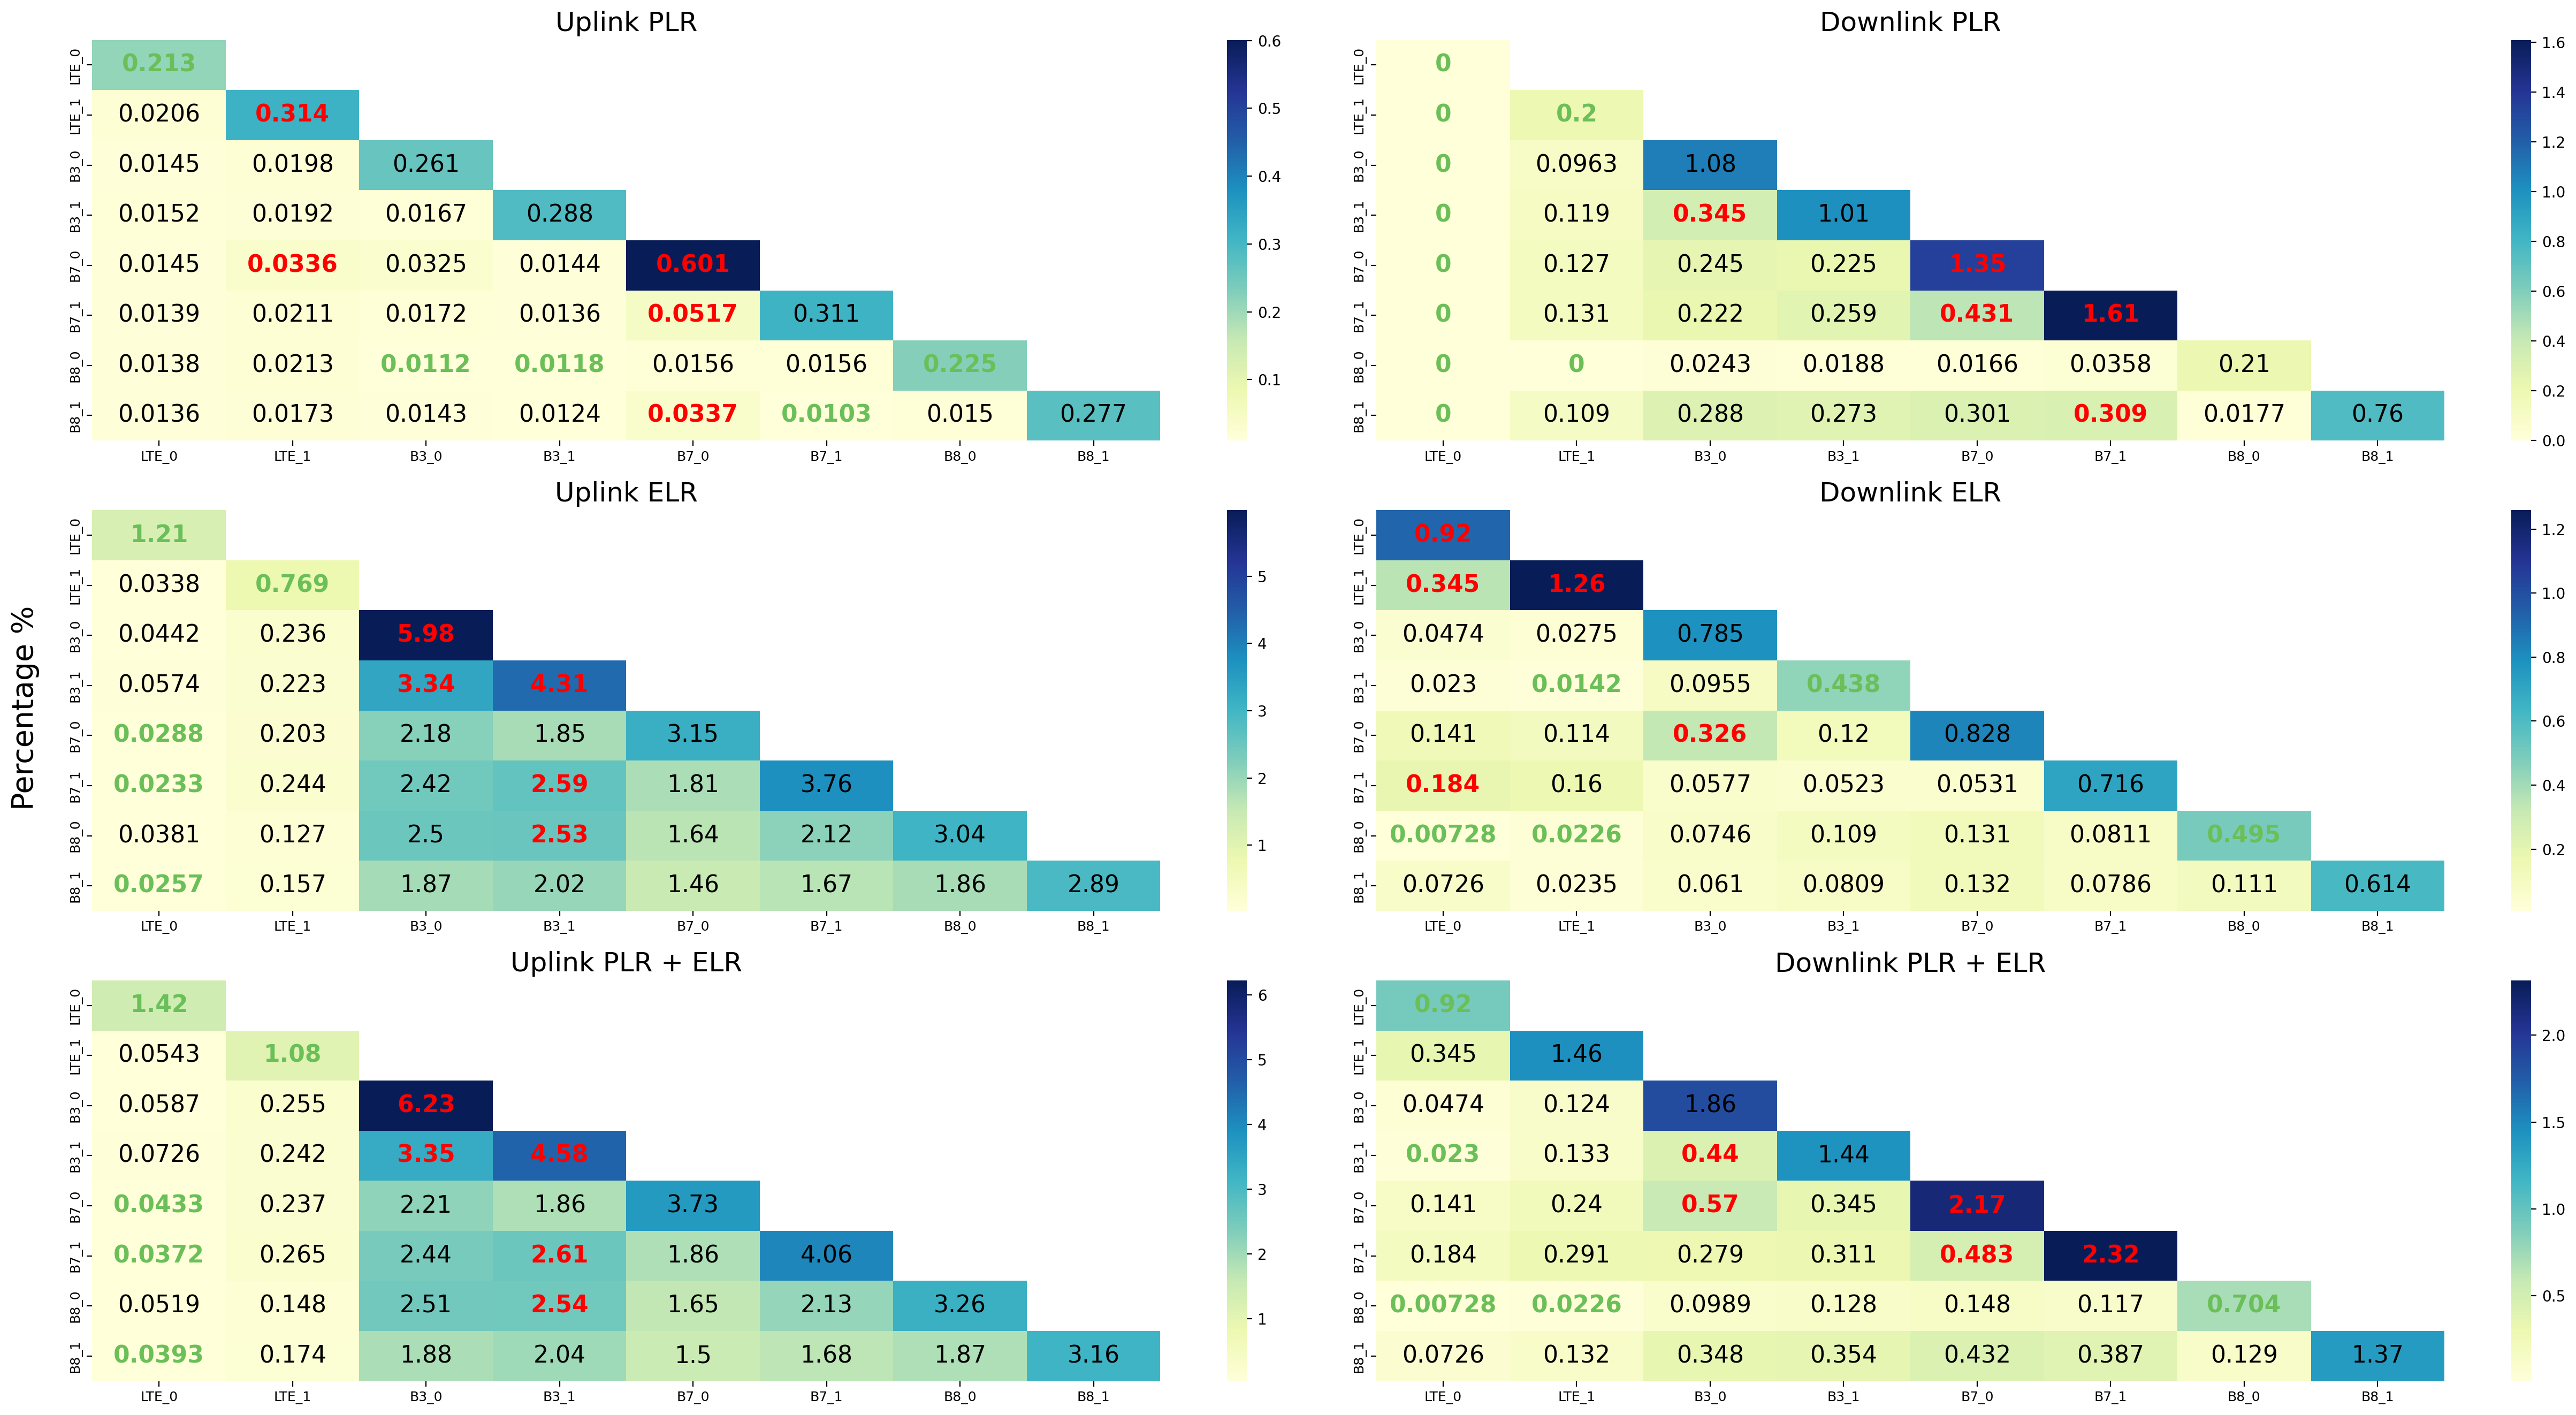

In [19]:
for expr, metrics_dict in zip(exp_list, dual_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata.iloc[:, :-4])
    display(expr.metadata_dual.iloc[:, :-4])
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl', 'ul_loss_excl', 'dl_loss_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR']
    
    # 建立表格方便製圖
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    combinations = ['+'.join(s) if s[0] != s[1] else s[0] for s in it.product(schemes, repeat=2)]
    
    size = len(expr.setting)
    comb_mapping = np.array(combinations).reshape(size, size).T
    
    # Average
    for ndiag in [False]:
        fig, axes = plt.subplots(3, 2, figsize=(25, 13.33))
        for pos, (tag, title) in enumerate(zip(tags, titles)):
            i = pos // 2; j = pos % 2
            
            data = [np.nanmean([num if num >= 0 else np.nan for num in metrics_dict[comb][tag]]) if comb in metrics_dict else -1 for comb in combinations]
            reshaped_data = np.array(data).reshape(size, size)
            
            axes[i][j].set_title(title, fontsize=18)
            # sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=True, fmt='.3g', mask=mask(size, diag=not ndiag), annot_kws={"size": 15.83}, cmap="YlGnBu")
            sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=False, mask=mask(size, diag=not ndiag), cmap="YlGnBu")
            axes[i][j].set_xticklabels(schemes, fontsize=9)
            axes[i][j].set_yticklabels(schemes, fontsize=9)
            
            # 在相应位置上标注"N/A"
            _mask = mask(size, diag=not ndiag)
            rows, cols = reshaped_data.shape
            for k in range(rows):
                for l in range(cols):
                    if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                        axes[i][j].text(l + 0.5, k + 0.5, "N/A", ha='center', va='center', color='red', fontweight='bold', fontsize=15.83)
            
            # Find the smallest and largest values excluding -1 and np.nan
            valid_values = reshaped_data[(reshaped_data != -1) & (~np.isnan(reshaped_data))]
            smallest_values_valid = np.partition(valid_values, 3)[:3]
            largest_values_valid = np.partition(valid_values, -3)[-3:]

            # Find the smallest and largest values excluding -1, np.nan, and diagonal elements
            mask_diag = np.eye(size, dtype=bool)
            valid_values_no_diag = reshaped_data[~mask_diag & (reshaped_data != -1) & (~np.isnan(reshaped_data))]
            smallest_values_valid_no_diag = np.partition(valid_values_no_diag, 3)[:3]
            largest_values_valid_no_diag = np.partition(valid_values_no_diag, -3)[-3:]

            # Find the smallest and largest values in the main diagonal excluding -1 and np.nan
            valid_diag_values = np.diagonal(reshaped_data)[(np.diagonal(reshaped_data) != -1) & (~np.isnan(np.diagonal(reshaped_data)))]
            smallest_diag_values_valid = np.partition(valid_diag_values, 2)[:2]
            largest_diag_values_valid = np.partition(valid_diag_values, -2)[-2:]
            
            # display(reshaped_data)
            # print(smallest_values_valid)
            # print(largest_values_valid)
            # print(smallest_values_valid_no_diag)
            # print(largest_values_valid_no_diag)
            # print(smallest_diag_values_valid)
            # print(largest_diag_values_valid)
            
            sr_best_settings = []
            dr_best_settings = []
            sr_worst_settings = []
            dr_worst_settings = []
            
            font_colors = np.empty_like(reshaped_data, dtype=object)
            for k in range(rows):
                for l in range(cols):
                    if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                        font_colors[k, l] = 'red'
                    elif np.isnan(reshaped_data.T[k][l]):
                        font_colors[k, l] = 'black'
                    elif reshaped_data.T[k][l] in smallest_values_valid_no_diag:
                        font_colors[k, l] = 'green'
                        dr_best_settings.append(comb_mapping[k][l])
                    elif reshaped_data.T[k][l] in smallest_diag_values_valid:
                        font_colors[k, l] = 'green'
                        sr_best_settings.append(comb_mapping[k][l])
                    elif reshaped_data.T[k][l] in largest_values_valid_no_diag:
                        font_colors[k, l] = 'red'
                        dr_worst_settings.append(comb_mapping[k][l])
                    elif reshaped_data.T[k][l] in largest_diag_values_valid:
                        font_colors[k, l] = 'red'
                        sr_worst_settings.append(comb_mapping[k][l])
                    else:
                        font_colors[k, l] = 'black'
            
            print(title)
            print('sr_best_settings', sr_best_settings)
            print('sr_worst_settings', sr_worst_settings)
            print('dr_best_settings', dr_best_settings)
            print('dr_worst_settings', dr_worst_settings)
            print()

            annotate_heatmap(reshaped_data.T, axes[i][j], font_colors, show_diag=not ndiag)
        
        fig.text(-0.01, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=20)
        
        plt.tight_layout()
        plt.show()
        

## Heatmap: Per Round

In [15]:
for expr, metrics_dict in zip(exp_list, dual_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata.iloc[:, :-4])
    display(expr.metadata_dual.iloc[:, :-4])
    
    tags = ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl', 'ul_loss_excl', 'dl_loss_excl']
    titles = ['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR']
    
    # 建立表格方便製圖
    metrics_table = {}
    
    # 根據字典建立好閱讀的表格
    for tag, title in zip(tags, titles):
        data = {k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}
        metrics_table[tag] = pd.DataFrame(data, index=expr.traces).reset_index().rename(columns={'index': 'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    size = len(expr.setting)
    schemes = metrics_table[tag].columns[1:size+1]
    schm_list = metrics_table[tag].columns[size+1:]
    for i, (tag, title) in enumerate(zip(tags, titles)):
        print(f'{title} Ranking:')
        
        # Single Radio Ranking
        display(expr.ranking[tag])
        
        # Dual Radio Ranking
        ranking_dict = {}
        data_dict = {k: v[tag] for k, v in metrics_dict.items()}
        score_dict = {k: [] for k in schm_list}
        for i, tr in enumerate(expr.traces):
            
            # print(i, tr)
            data = [v[i] for v in data_dict.values()][size:]
            data = [num if num >= 0 else np.inf for num in data]
            na_indices = [i for i, num in enumerate(data) if np.isinf(num)]
            
            ranking = np.argsort(np.argsort(data)) + 1
            ranking[na_indices] = -1
            ranking_dict[tr] = {k: v for k, v in zip(schm_list, ranking)}
            
            _ranking = [num for num in ranking if num != -1]
            _max = max(_ranking); _min = min(_ranking)
            for k, rank in zip(schm_list, ranking):
                if rank == _min: score_dict[k].append(3)
                elif rank == _min + 1: score_dict[k].append(2)
                elif rank == _min + 2: score_dict[k].append(1)
                elif rank == _max - 1: score_dict[k].append(-1)
                elif rank == _max - 2: score_dict[k].append(-2)
                elif rank == _max: score_dict[k].append(-3)
                else: score_dict[k].append(0)
        
        
        score = [sum(v) for v in score_dict.values()]
        ranking_dict['Score'] = {k: v for k, v in zip(schm_list, score)}
        
        # 降冪排列
        score_ranking = np.argsort(np.argsort(score)[::-1]) + 1
        ranking_dict['Ranking'] = {k: round(v) for k, v in zip(schm_list, score_ranking)}
        ranking_table = pd.DataFrame.from_dict(ranking_dict, orient='index')
        
        # 將 -1 改成 pd.NA
        rows_to_check = ranking_table.index[:-2]
        ranking_table.loc[rows_to_check] = ranking_table.loc[rows_to_check].applymap(lambda x: pd.NA if x == -1 else x)
        
        expr.ranking_dual[tag] = ranking_table
        display(ranking_table)
        
        print('sr_best_settings', expr.ranking[tag].columns[np.argsort(expr.ranking[tag].iloc[-1].array)[:2]])
        print('sr_worst_settings', expr.ranking[tag].columns[np.argsort(expr.ranking[tag].iloc[-1].array)[::-1][:2]])
        print('dr_best_settings', expr.ranking_dual[tag].columns[np.argsort(expr.ranking_dual[tag].iloc[-1].array)[:3]])
        print('dr_worst_settings', expr.ranking_dual[tag].columns[np.argsort(expr.ranking_dual[tag].iloc[-1].array)[::-1][:3]])
        print()
    
    ### Plotting: Per Round
    size = len(expr.setting)
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    combinations = ['+'.join(s) if s[0] != s[1] else s[0] for s in it.product(schemes, repeat=2)]
    comb_mapping = np.array(combinations).reshape(size, size).T
    for idx, tr in enumerate(expr.traces):
        print(f'{expr.date} | {expr.name} -> {tr}')
        
        for ndiag in [False]:
            fig, axes = plt.subplots(3, 2, figsize=(25, 13.33))
            for pos, (tag, title) in enumerate(zip(tags, titles)):
                i = pos // 2; j = pos % 2
                
                data = [metrics_dict[comb][tag][idx] if comb in metrics_dict else -1 for comb in combinations]
                data = [num if num >= 0 else np.nan for num in data]
                reshaped_data = np.array(data).reshape(size, size)
                
                axes[i][j].set_title(title, fontsize=18)
                # sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=True, fmt='.3g', mask=mask(size, diag=not ndiag), annot_kws={"size": 15.83}, cmap="YlGnBu")
                sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=False, mask=mask(size, diag=not ndiag), cmap="YlGnBu")
                axes[i][j].set_xticklabels(schemes, fontsize=9)
                axes[i][j].set_yticklabels(schemes, fontsize=9)
                
                # 在相应位置上标注"N/A"
                _mask = mask(size, diag=not ndiag)
                rows, cols = reshaped_data.shape
                for k in range(rows):
                    for l in range(cols):
                        if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                            axes[i][j].text(l + 0.5, k + 0.5, "N/A", ha='center', va='center', color='red', fontweight='bold', fontsize=15.83)
                
                # Find the smallest and largest values excluding -1 and np.nan
                valid_values = reshaped_data[(reshaped_data != -1) & (~np.isnan(reshaped_data))]
                smallest_values_valid = np.partition(valid_values, 3)[:3]
                largest_values_valid = np.partition(valid_values, -3)[-3:]

                # Find the smallest and largest values excluding -1, np.nan, and diagonal elements
                mask_diag = np.eye(size, dtype=bool)
                valid_values_no_diag = reshaped_data[~mask_diag & (reshaped_data != -1) & (~np.isnan(reshaped_data))]
                smallest_values_valid_no_diag = np.partition(valid_values_no_diag, 3)[:3]
                largest_values_valid_no_diag = np.partition(valid_values_no_diag, -3)[-3:]

                # Find the smallest and largest values in the main diagonal excluding -1 and np.nan
                valid_diag_values = np.diagonal(reshaped_data)[(np.diagonal(reshaped_data) != -1) & (~np.isnan(np.diagonal(reshaped_data)))]
                smallest_diag_values_valid = np.partition(valid_diag_values, 2)[:2]
                largest_diag_values_valid = np.partition(valid_diag_values, -2)[-2:]
                
                # display(reshaped_data)
                # print(smallest_values_valid)
                # print(largest_values_valid)
                # print(smallest_values_valid_no_diag)
                # print(largest_values_valid_no_diag)
                # print(smallest_diag_values_valid)
                # print(largest_diag_values_valid)
                
                sr_best_settings = []
                dr_best_settings = []
                sr_worst_settings = []
                dr_worst_settings = []
                
                font_colors = np.empty_like(reshaped_data, dtype=object)
                for k in range(rows):
                    for l in range(cols):
                        if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                            font_colors[k, l] = 'red'
                        elif np.isnan(reshaped_data.T[k][l]):
                            font_colors[k, l] = 'black'
                        elif reshaped_data.T[k][l] in smallest_values_valid_no_diag:
                            font_colors[k, l] = 'green'
                            dr_best_settings.append(comb_mapping[k][l])
                        elif reshaped_data.T[k][l] in smallest_diag_values_valid:
                            font_colors[k, l] = 'green'
                            sr_best_settings.append(comb_mapping[k][l])
                        elif reshaped_data.T[k][l] in largest_values_valid_no_diag:
                            font_colors[k, l] = 'red'
                            dr_worst_settings.append(comb_mapping[k][l])
                        elif reshaped_data.T[k][l] in largest_diag_values_valid:
                            font_colors[k, l] = 'red'
                            sr_worst_settings.append(comb_mapping[k][l])
                        else:
                            font_colors[k, l] = 'black'

                annotate_heatmap(reshaped_data.T, axes[i][j], font_colors, show_diag=not ndiag)
                
                print(title)
                print('sr_best_settings', sr_best_settings)
                print('sr_worst_settings', sr_worst_settings)
                print('dr_best_settings', dr_best_settings)
                print('dr_worst_settings', dr_worst_settings)
                print()
            
            fig.text(-0.01, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=20)
            
            plt.tight_layout()
            plt.show()

NameError: name 'dual_metrics_list' is not defined

# Trace Inspector

(1) 2個radio 的 packet loss 不同顏色疊在一起

(2) 兩者的 Latency （100ms 為閾值）

(3) 2個radio 的 handover 的發生時間，上為 radio 1，下為 radio 2，數字標間隔時間

(4) 兩者的 serving RSRP (PCI, band 變化，上為 radio 1) 最強的兩個 neighboring RSRP

(5) 兩者的 serving NR RSRP (PCI, band 變化，下為 radio 2) 最強的兩個 neighboring RSRP

(PCI1, EARFCN1, NRPCI1) -> (PCI2, EARFCN2, NRPCI2)

In [414]:
all_path = namedtuple('all_path', ['rrc_path', 'lte_path', 'nr_path', 'ul_path', 'dl_path'])

def find_selected_filepath(id, tr, dev):
    try:
        index = look_up_table[id]
        # print(f'Exp ({id}, {dev}, {tr}) look up succeed!')
    except:
        id_not_found = 1
        for i, expr in enumerate(exp_list):
            if "{:02d}".format(id) == expr.id:
                id_not_found = 0
                look_up_table[id] = i
                index = i
                break
        if id_not_found:
            print(f'Exp id: {id} not found!')
            return '','','','',''
            
    if isinstance(tr, str):
        tr_index = exp_list[index].traces.index(tr)
    else:
        tr_index = tr
    
    rrc_path = exp_list[index].rrc_paths[dev][tr_index]
    lte_path = exp_list[index].lte_paths[dev][tr_index]
    nr_path = exp_list[index].nr_paths[dev][tr_index]
    ul_path = exp_list[index].ul_paths[dev][tr_index]
    dl_path = exp_list[index].dl_paths[dev][tr_index]
    
    return all_path(rrc_path, lte_path, nr_path, ul_path, dl_path)

def find_expr_instance(id):
    try:
        index = look_up_table[id]
        # print(f'Exp ({id}, {dev}, {tr}) look up succeed!')
    except:
        id_not_found = 1
        for i, expr in enumerate(exp_list):
            if "{:02d}".format(id) == expr.id:
                id_not_found = 0
                look_up_table[id] = i
                index = i
                break
        if id_not_found:
            print(f'Exp id: {id} not found!')
            return '','','','',''
    
    return exp_list[index]

def check_scheme(id, dev):
    try:
        index = look_up_table[id]
        # print(f'Exp ({id}, {dev}, {tr}) look up succeed!')
    except:
        id_not_found = 1
        for i, expr in enumerate(exp_list):
            if "{:02d}".format(id) == expr.id:
                id_not_found = 0
                look_up_table[id] = i
                index = i
                break
        if id_not_found:
            print(f'Exp id: {id} not found!')
            return '','','','',''
    
    my_dict = {k: v for k, v in zip(exp_list[index].setting.keys(), add_suffix_to_duplicate_category(exp_list[index].setting.values()))}
    
    return my_dict[dev]

## Dual Radio

In [7]:
for expr in exp_list:
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata.iloc[:, :-4])

Experiment 18: 2023-06-12 | Bandlock_8_Schemes_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06', '#07', '#08', '#09', '#10']


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7]

In [8]:
# TODO: Select Traces
expr_id = 22; expr_tr = '#06'; expr = find_expr_instance(expr_id)
dev1 = 'sm07'; schm1 = check_scheme(expr_id, dev1)
dev2 = 'sm06'; schm2 = check_scheme(expr_id, dev2)

# dev1 = 'sm00'; schm1 = check_scheme(expr_id, dev1)
# dev2 = 'sm06'; schm2 = check_scheme(expr_id, dev2)

print(expr)
print(expr_tr)
print(dev1, schm1)
print(dev2, schm2)

NameError: name 'find_expr_instance' is not defined

In [9]:
dfs = {'ho': [], 'lte': [], 'nr': [], 'ul': [], 'dl': []}
filepath1 = find_selected_filepath(expr_id, expr_tr, dev1)
filepath2 = find_selected_filepath(expr_id, expr_tr, dev2)

file_not_exist = False
for path1, path2, key in zip(filepath1, filepath2, dfs.keys()):
    print(key)
    print(dev1, expr_tr, path1)
    print(dev2, expr_tr, path2)
    if not (os.path.isfile(path1) and os.path.isfile(path2)):
        file_not_exist = True
        dfs[key].append(pd.DataFrame())
        dfs[key].append(pd.DataFrame())
    else:
        df1 = pd.read_pickle(path1) if path1.endswith('.pkl') else pd.read_csv(path1)
        df2 = pd.read_pickle(path2) if path2.endswith('.pkl') else pd.read_csv(path2)
        if key in ['ho']:
            df1, _, _ = mi_parse_ho(df1, tz=8)
            df2, _, _ = mi_parse_ho(df2, tz=8)
            df1['ho_type0'] = df1['ho_type'].astype('string')
            df2['ho_type0'] = df2['ho_type'].astype('string')
            df1.loc[df1['cause'].notna(), 'ho_type0'] = df1['ho_type'].astype('string') + '_' + df1['cause'].astype('string')
            df2.loc[df2['cause'].notna(), 'ho_type0'] = df2['ho_type'].astype('string') + '_' + df2['cause'].astype('string')
            df1['ho_type0'] = df1['ho_type0'].astype('category')
            df2['ho_type0'] = df2['ho_type0'].astype('category')
        elif key in ['lte', 'nr']:
            df1 = set_data(df1, mode=key, tz=8)
            df2 = set_data(df2, mode=key, tz=8)
        else:
            df1 = set_data(df1)
            df2 = set_data(df2)

        dfs[key].append(df1)
        dfs[key].append(df2)

if file_not_exist:
    print('\nFile not exist!!')
    
else:
    for key in ['ul', 'dl']:
        st_seq = max([dfs[key][0]['seq'].array[0], dfs[key][1]['seq'].array[0]])
        ed_seq = min([dfs[key][0]['seq'].array[-1], dfs[key][1]['seq'].array[-1]])
        dfs[key][0] = dfs[key][0][(dfs[key][0]['seq'] >= st_seq) & (dfs[key][0]['seq'] <= ed_seq)].reset_index(drop=True)
        dfs[key][1] = dfs[key][1][(dfs[key][1]['seq'] >= st_seq) & (dfs[key][1]['seq'] <= ed_seq)].reset_index(drop=True)

    st_time = min(dfs['ul'][0]['Timestamp'].array[0], dfs['ul'][1]['Timestamp'].array[0], dfs['dl'][0]['Timestamp'].array[0], dfs['dl'][1]['Timestamp'].array[0])
    ed_time = min(dfs['ul'][0]['Timestamp'].array[-1], dfs['ul'][1]['Timestamp'].array[-1], dfs['dl'][0]['Timestamp'].array[-1], dfs['dl'][1]['Timestamp'].array[-1])
    for key in ['ho', 'lte', 'nr']:
        dfs[key][0] = dfs[key][0][(dfs[key][0]['Timestamp'] > st_time) & (dfs[key][0]['Timestamp'] < ed_time)].reset_index(drop=True)
        dfs[key][1] = dfs[key][1][(dfs[key][1]['Timestamp'] > st_time) & (dfs[key][1]['Timestamp'] < ed_time)].reset_index(drop=True)

NameError: name 'find_selected_filepath' is not defined

### Uplink Downlink

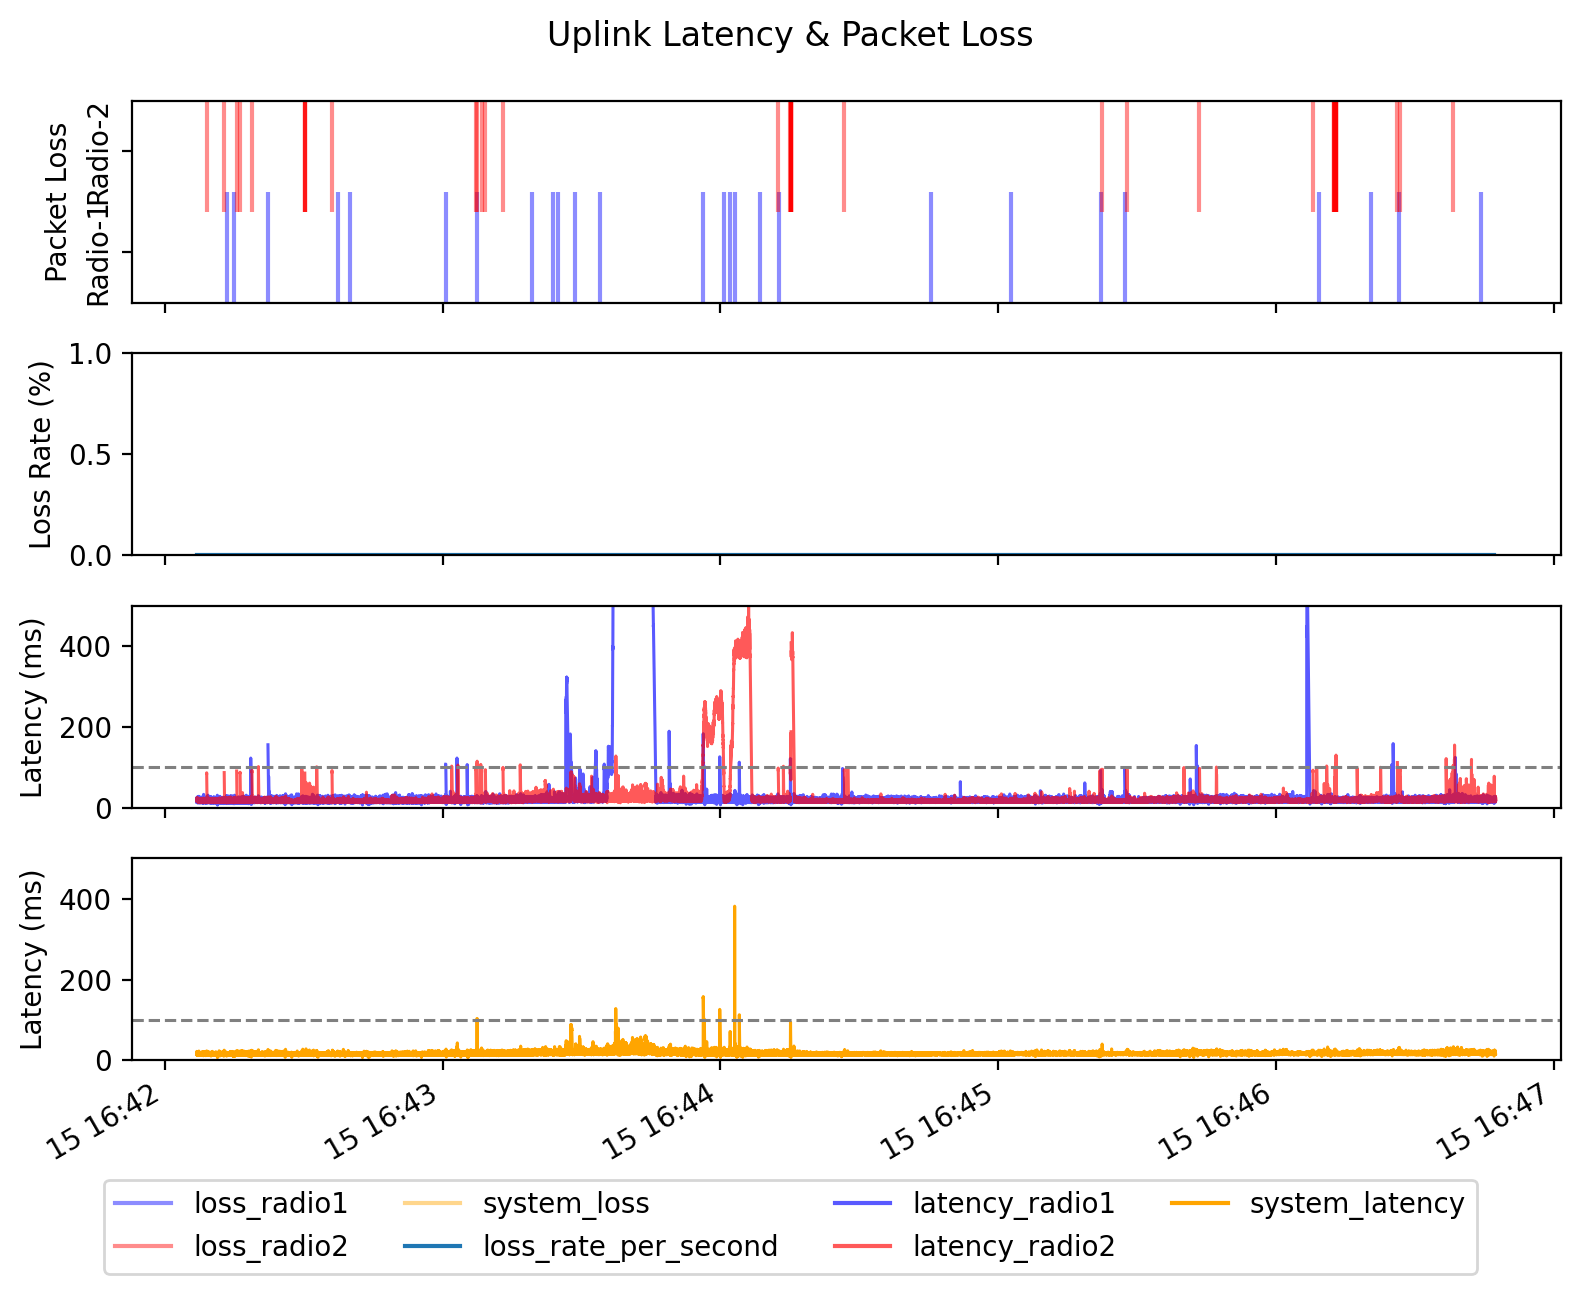

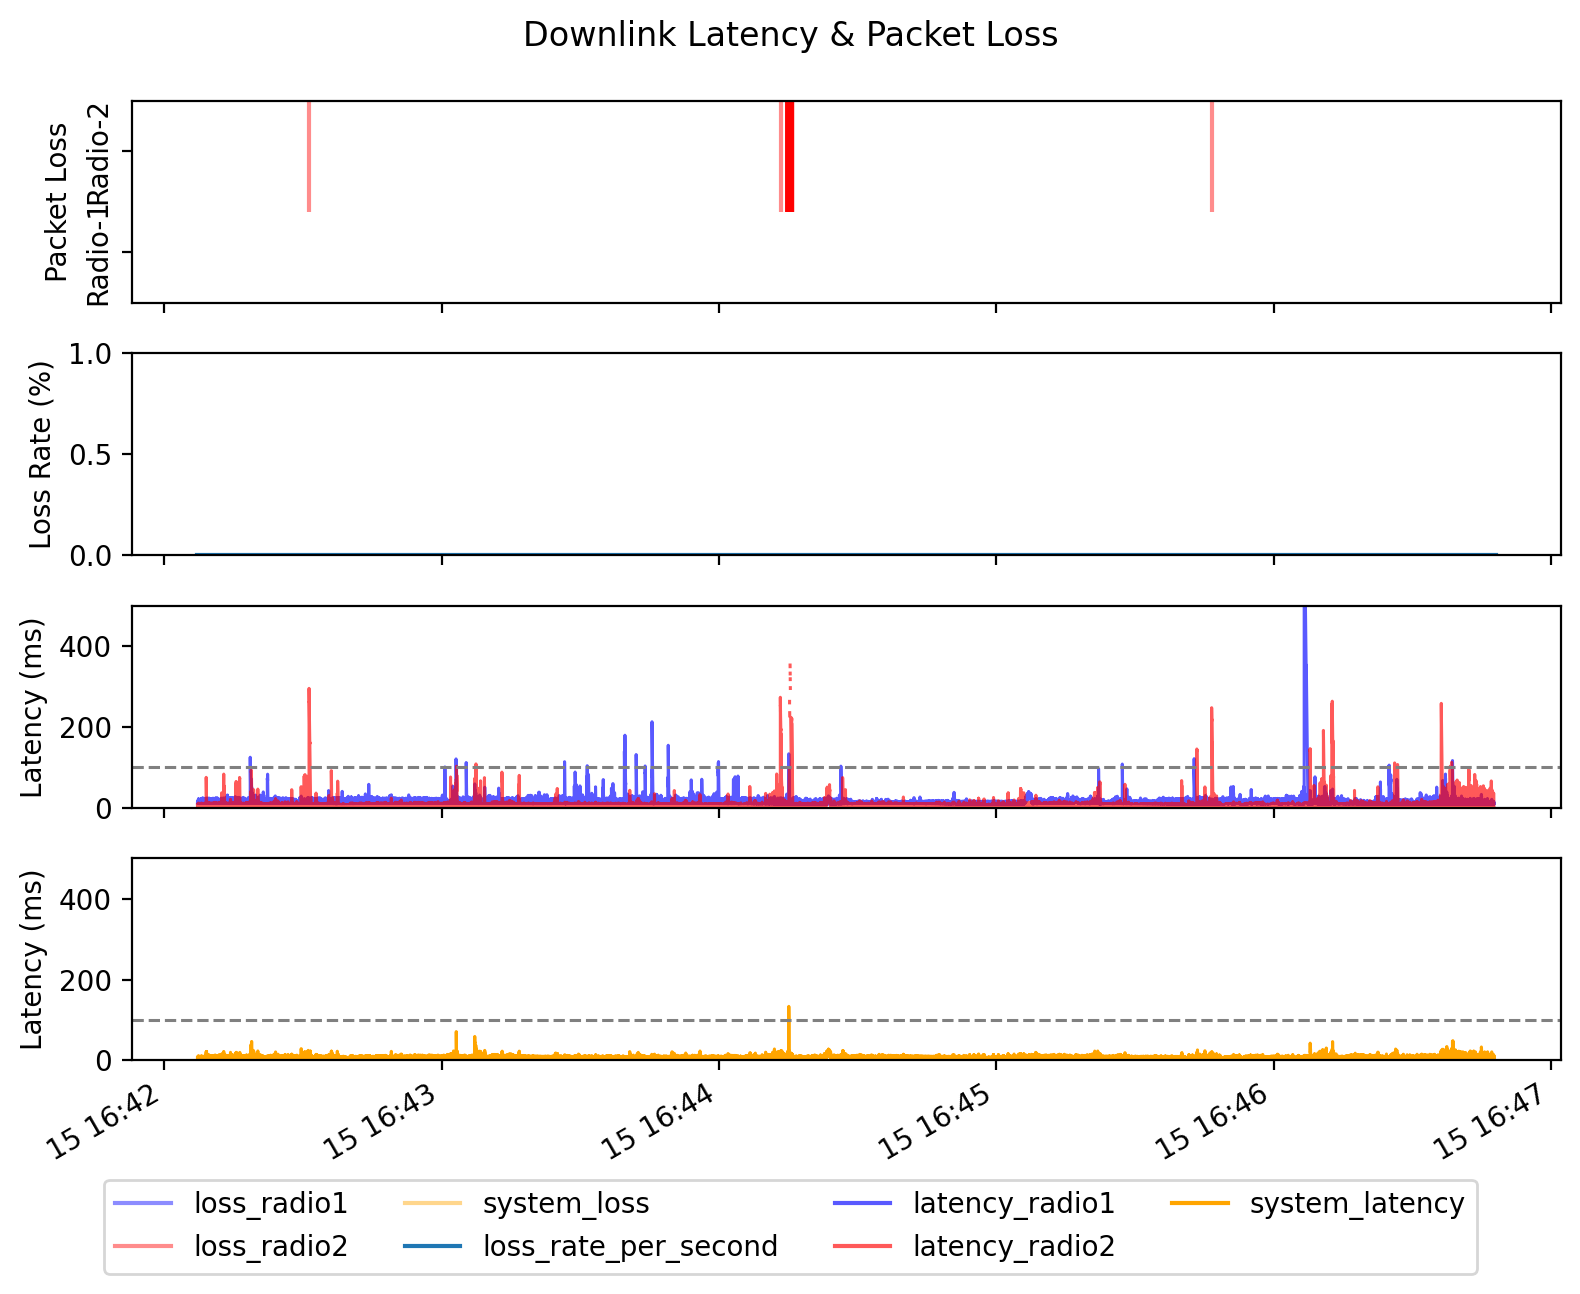

In [512]:
def plot_latency_loss(df1, df2, excl_threshold, title):
    fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    legend_lines = []
    legend_labels = []

    def add_legend_lines(ax, label, color, alpha=1):
        line = ax.plot([], [], color=color, alpha=alpha)[0]
        legend_lines.append(line)
        legend_labels.append(label)

    ### Packet Loss
    loss1 = df1.loc[df1['lost'], "Timestamp"].iloc[:]
    loss2 = df2.loc[df2['lost'], "Timestamp"].iloc[:]
    loss = df1.loc[df1['lost'] & df2['lost'], "Timestamp"].iloc[:]

    axes[0].vlines(loss1, ymin=0, ymax=0.55, color='b', alpha=0.45)
    axes[0].vlines(loss2, ymin=0.45, ymax=1, color='r', alpha=0.45)
    axes[0].set_ylim(0, 1)
    axes[0].set_yticks([0.25, 0.75])
    axes[0].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')
    axes[0].set_ylabel('Packet Loss')

    df = df1.merge(df2, on='seq').rename(columns={'Timestamp_x': 'Timestamp'}).reset_index(drop=True).copy()
    df['lost'] = df['lost_x'] & df['lost_y']
    df = df[['Timestamp', 'lost']]
    df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('1s')

    lost_rate_per_second = (df.groupby('Timestamp')['lost'].mean() * 100).reset_index()
    timestamp = lost_rate_per_second['Timestamp'].iloc[:]
    lost_rate = lost_rate_per_second['lost'].iloc[:]

    axes[1].vlines(loss, ymin=0, ymax=100, color='orange', alpha=0.45)
    axes[1].plot(timestamp, lost_rate)
    axes[1].set_ylim(0, max(min(max(lost_rate) * 1.05, 100), 1))
    axes[1].set_ylabel('Loss Rate (%)')
    
    add_legend_lines(axes[0], 'loss_radio1', 'b', 0.45)
    add_legend_lines(axes[0], 'loss_radio2', 'r', 0.45)
    add_legend_lines(axes[1], 'system_loss', 'orange', 0.45)
    add_legend_lines(axes[1], 'loss_rate_per_second', 'tab:blue')

    ### Latency
    timestamp1 = df1["Timestamp"].iloc[:]
    latency1 = df1["latency"].iloc[:].astype(float) * 1e3
    timestamp2 = df2["Timestamp"].iloc[:]
    latency2 = df2["latency"].iloc[:].astype(float) * 1e3

    latency_min = np.minimum(latency1, latency2)

    axes[2].plot(timestamp1, latency1, linewidth=1.1, color='b', alpha=0.65)
    axes[2].plot(timestamp2, latency2, linewidth=1.1, color='r', alpha=0.65)
    axes[3].plot(timestamp1, latency_min, linewidth=1.1, color='orange')
        
    for ax in [axes[2], axes[3]]:
        ax.set_ylim(0, 500)
        ax.axhline(y=excl_threshold, color='gray', linestyle='--', linewidth=1.1)
    
    add_legend_lines(axes[2], 'latency_radio1', 'b', 0.65)
    add_legend_lines(axes[2], 'latency_radio2', 'r', 0.65)
    add_legend_lines(axes[3], 'system_latency', 'orange')

    axes[2].set_ylabel('Latency (ms)')
    axes[3].set_ylabel('Latency (ms)')
    # fig.text(0, (axes[2].get_position().y1 + axes[3].get_position().y0) / 2, \
    #     'milliseconds', ha='center', va='center', rotation='vertical', fontsize=10)

    fig.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.025), fancybox=True, ncol=4)
    fig.suptitle(title)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Call the function for uplink and downlink
plot_latency_loss(dfs['ul'][0].copy(), dfs['ul'][1].copy(), 100, 'Uplink Latency & Packet Loss')
plot_latency_loss(dfs['dl'][0].copy(), dfs['dl'][1].copy(), 100, 'Downlink Latency & Packet Loss')

### LTE Handover

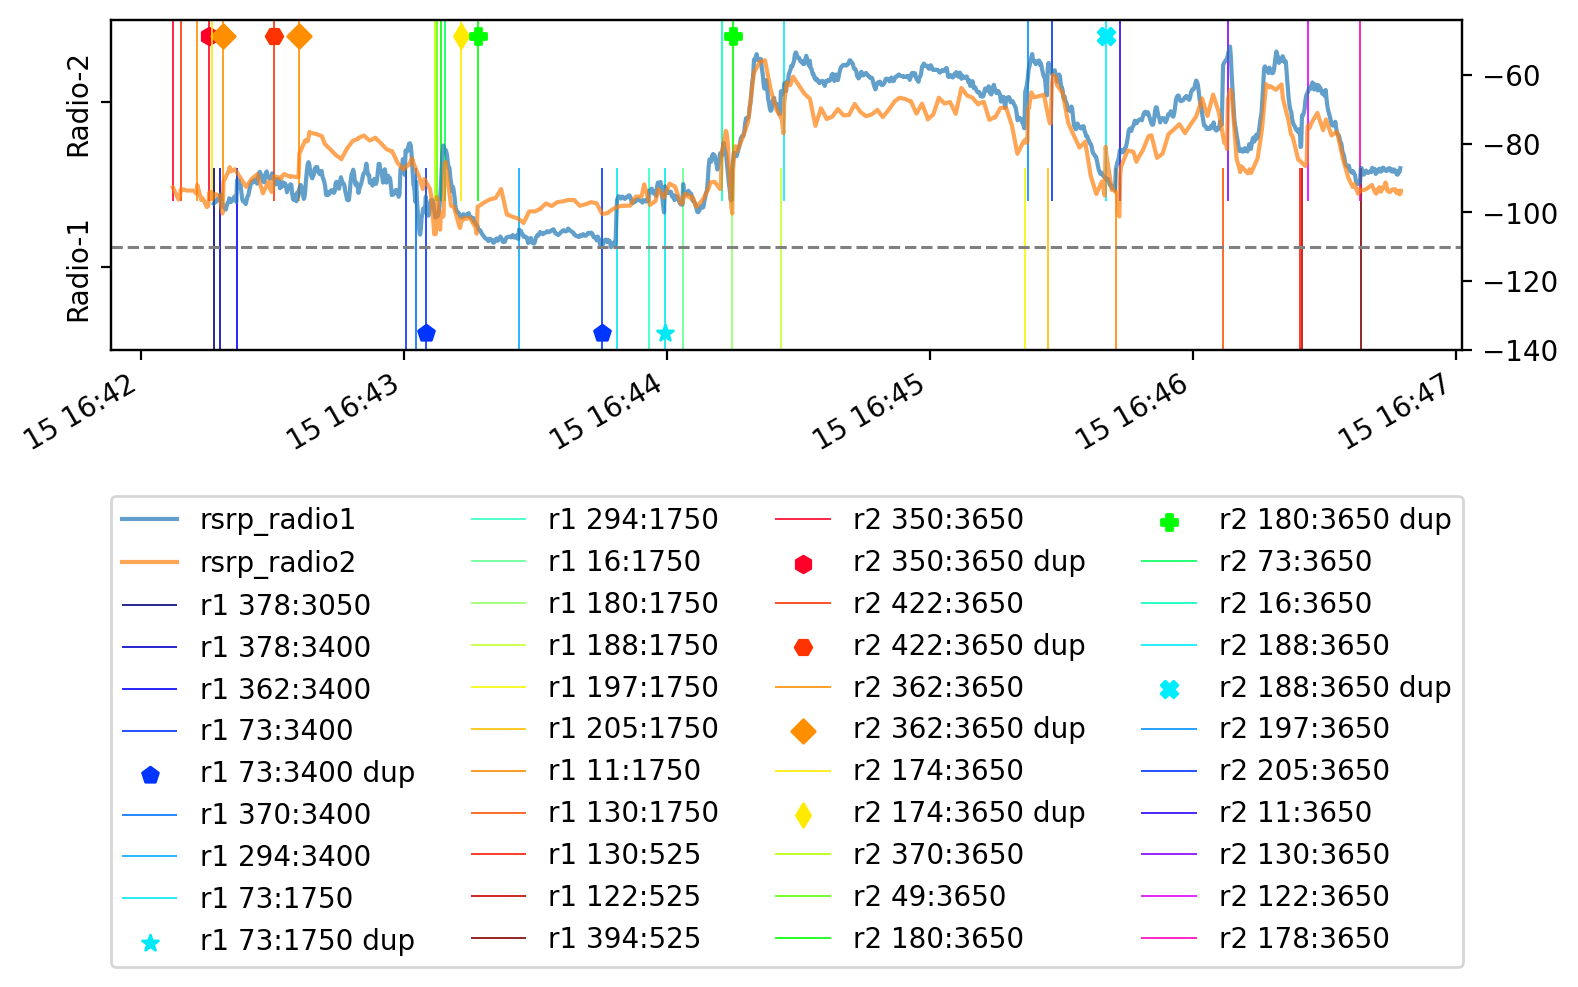

In [513]:
df1 = dfs['lte'][0].copy()
df2 = dfs['lte'][1].copy()

df1 = df1[df1['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([], [], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax.plot([], [], color='tab:orange', alpha=0.7, label='rsrp_radio2')

ax_twinx = ax.twinx()
ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')
ax_twinx.set_ylim(-140, -44)
ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

def drop_unchanged(df):
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_EARFCN'] = df['EARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['EARFCN'] != df['prev_EARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_EARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'EARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='Timestamp').reset_index(drop=True)
pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}  

ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.75])
ax.set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df1.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup')
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df2.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup')
        k += 1

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)

# fig.text(0, (ax.get_position().y0 + ax.get_position().y1) / 2, \
#         'radio 1', ha='center', va='center', rotation='vertical', fontsize=10)

# Show the plot
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### NR Handover

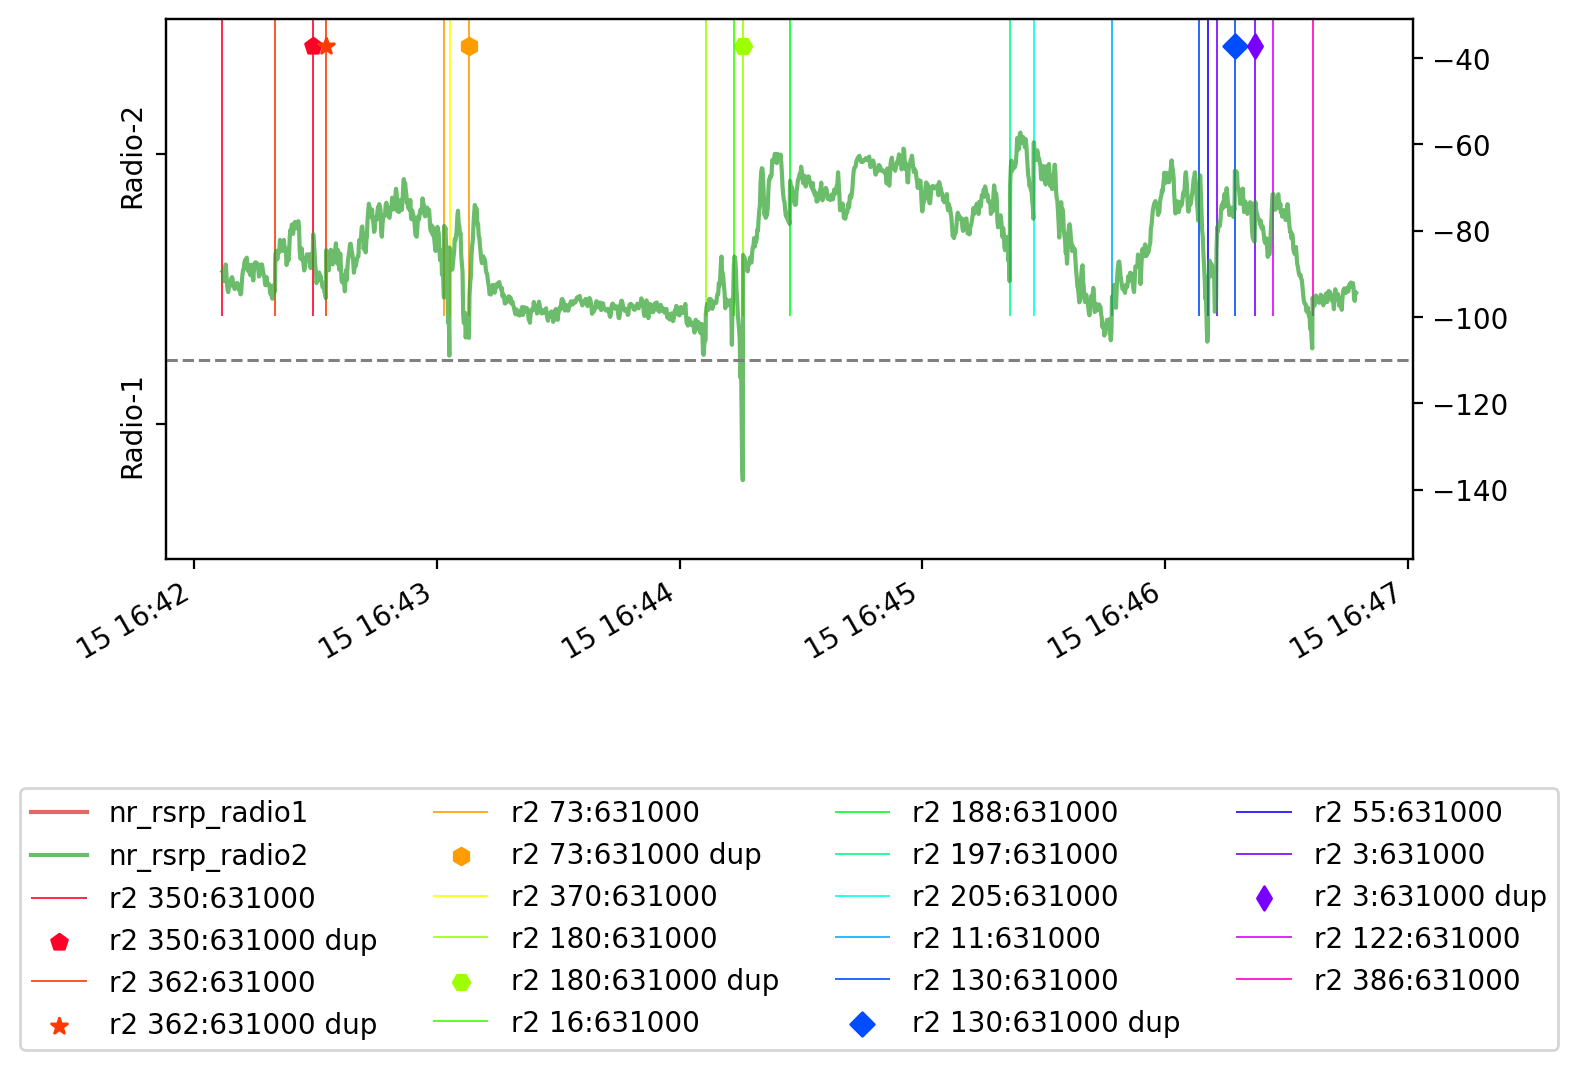

In [514]:
df1 = dfs['nr'][0].copy()
df2 = dfs['nr'][1].copy()

df1 = df1[df1['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([], [], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
ax.plot([], [], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')

ax_twinx = ax.twinx()
ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')
ax_twinx.set_ylim(-156, -31)
ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

def drop_unchanged(df):
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_NR_ARFCN'] = df['NR_ARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['NR_ARFCN'] != df['prev_NR_ARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_NR_ARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'NR_ARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['NR_ARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='Timestamp').reset_index(drop=True)
pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['NR_ARFCN'].array)]

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}  

ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.75])
ax.set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df1.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['NR_ARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0]) if not tmp.empty else pd.DataFrame()
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup')
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df2.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['NR_ARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0]) if not tmp.empty else pd.DataFrame()
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup')
        k += 1

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=4)

# fig.text(0, (ax.get_position().y0 + ax.get_position().y1) / 2, \
#         'radio 1', ha='center', va='center', rotation='vertical', fontsize=10)

# Show the plot
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### Handover Policy

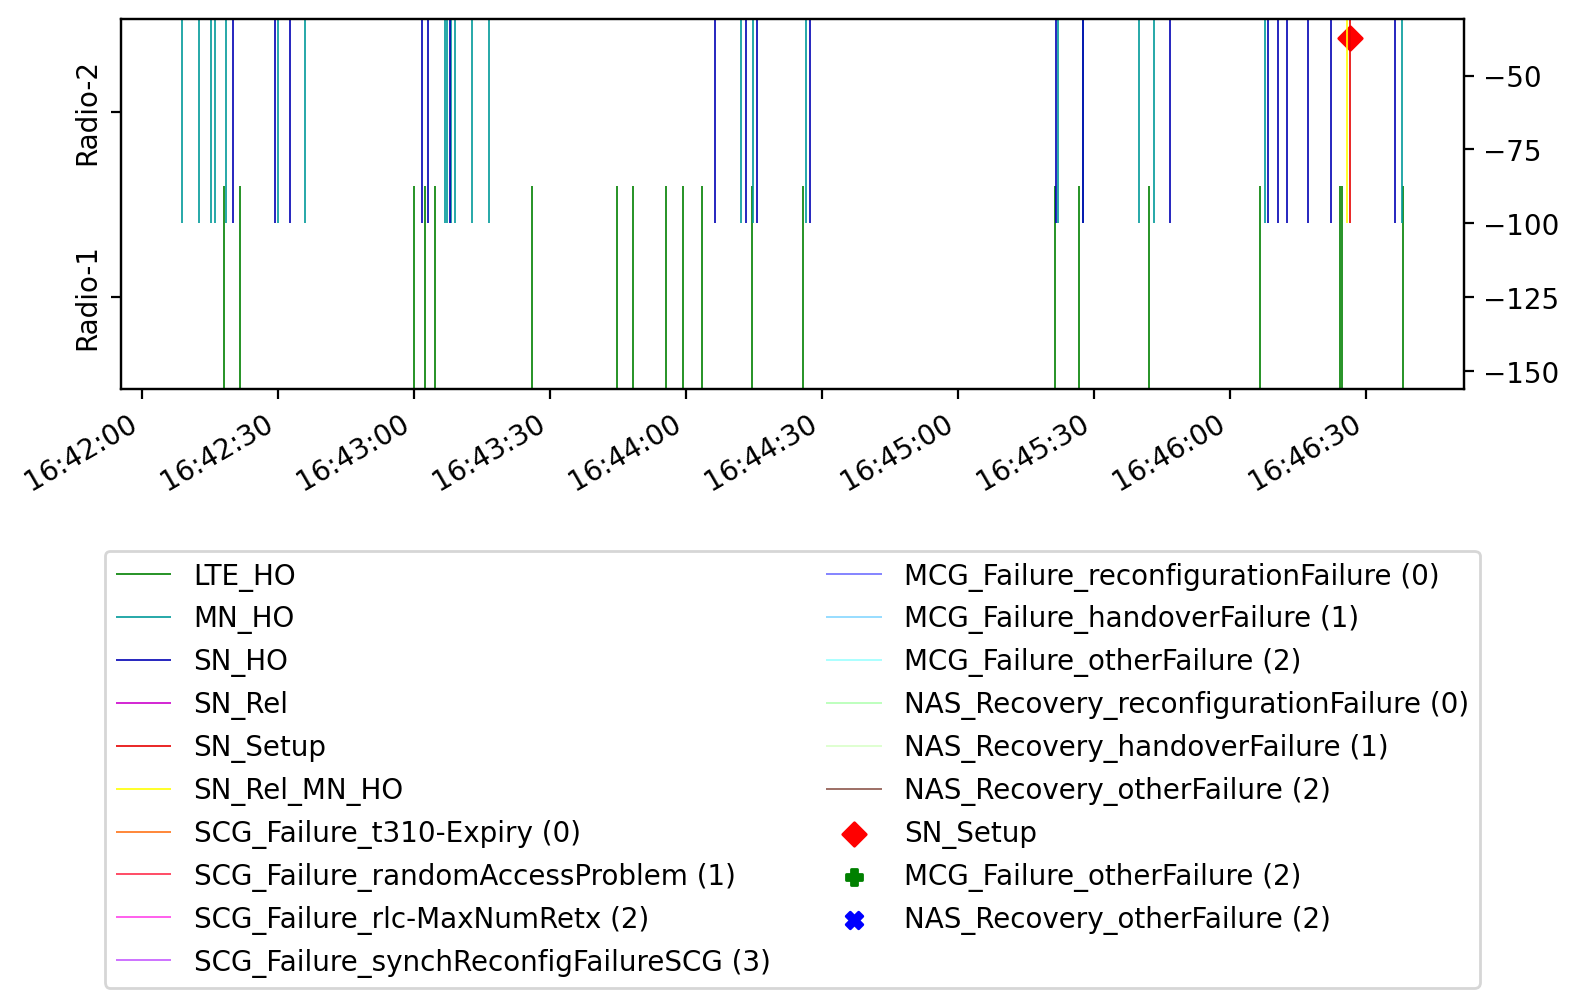

In [515]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

ax_twinx = ax.twinx()
ax_twinx.set_ylim(-156, -31)

# ax.plot([], [], color='tab:blue', alpha=0.7, label='rsrp_radio1')
# ax.plot([], [], color='tab:orange', alpha=0.7, label='rsrp_radio2')
# ax.plot([], [], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
# ax.plot([], [], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')

# df1 = dfs['lte'][0].copy()
# df2 = dfs['lte'][1].copy()

# df1 = df1[df1['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
# df2 = df2[df2['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
# ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')
# ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

# df1 = dfs['nr'][0].copy()
# df2 = dfs['nr'][1].copy()

# df1 = df1[df1['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
# df2 = df2[df2['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
# ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')
# ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

df1 = dfs['ho'][0].copy()
df2 = dfs['ho'][1].copy()

handovers = ['LTE_HO','MN_HO','SN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

colors = ['#008000', '#009999', '#0000B3', '#CC00CC', '#E60000', '#FFFF02', '#FF7216', '#FF2C4B', '#FF43EA', '#C459FF', '#6F6FFF', '#85D6FF', '#9BFFFF', '#B2FFB2', '#D9FFC8', 'tab:brown']
cdict3 = {handover: color for handover, color in zip(handovers, colors)}

ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.75])
ax.set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

for handover in handovers:
    ax.vlines([], [], [], color=cdict3[handover], linewidth=0.7, alpha=0.85, label=handover)

for handover in handovers:

    df = df1.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict3[handover], linewidth=0.7, alpha=0.85)
    
    df = df2.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        ax.vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict3[handover], linewidth=0.7, alpha=0.85)


handovers_subset = [
    'SN_Setup','MCG_Failure_otherFailure (2)','NAS_Recovery_otherFailure (2)'
]

colors = ['r', 'g', 'b']
cdict4 = {handover: color for handover, color in zip(handovers_subset, colors)}

markers = ['D', 'P', 'X']
mdict = {handover: marker for handover, marker in zip(handovers_subset, markers)}

for handover in handovers_subset:
    ax.scatter([], [], c=cdict4[handover], marker=mdict[handover], label=handover)

for handover in handovers_subset:

    df = df1.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict4[handover], marker=mdict[handover])
    
    df = df2.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        ax.scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict4[handover], marker=mdict[handover])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), fancybox=True, ncol=2)

# fig.text(0, (ax.get_position().y0 + ax.get_position().y1) / 2, \
#         'radio 1', ha='center', va='center', rotation='vertical', fontsize=10)

# Show the plot
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### All Plots # Uplink

Uplink PLR  Uplink ELR  Uplink PLR + ELR
Radio1       0.019       4.404             4.422
Radio2       0.034       3.572             3.604
System       0.000       0.068             0.068

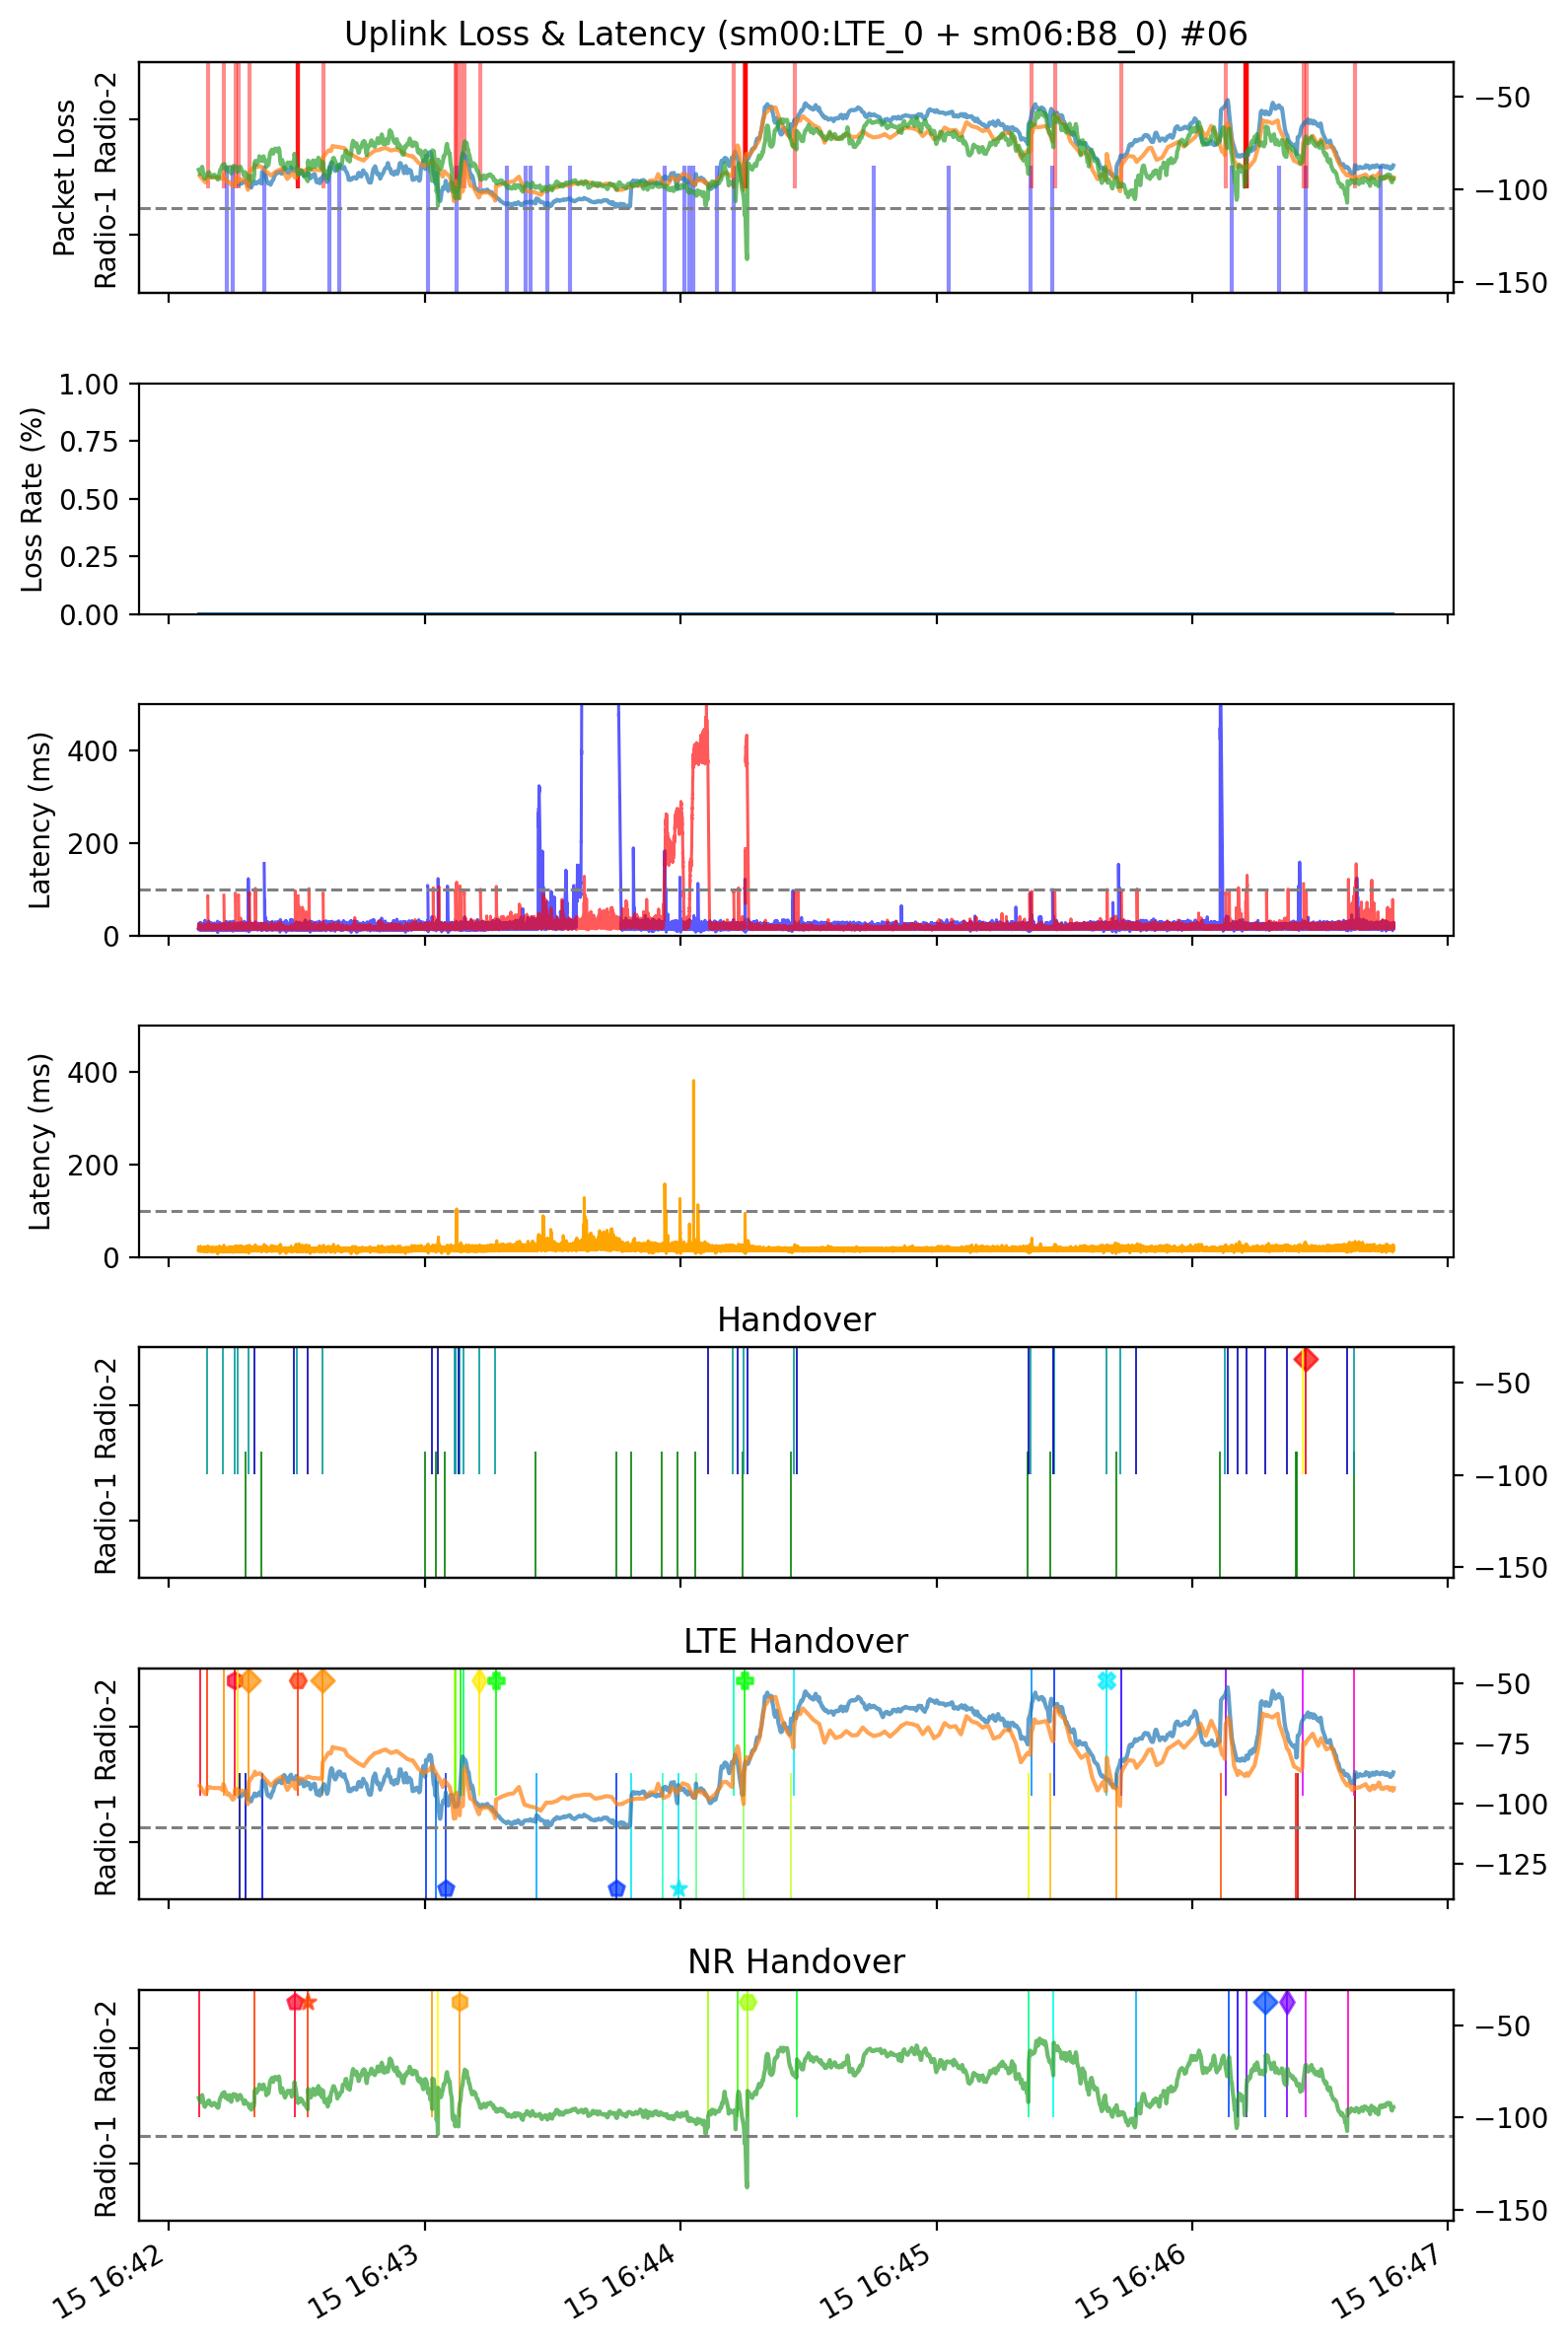

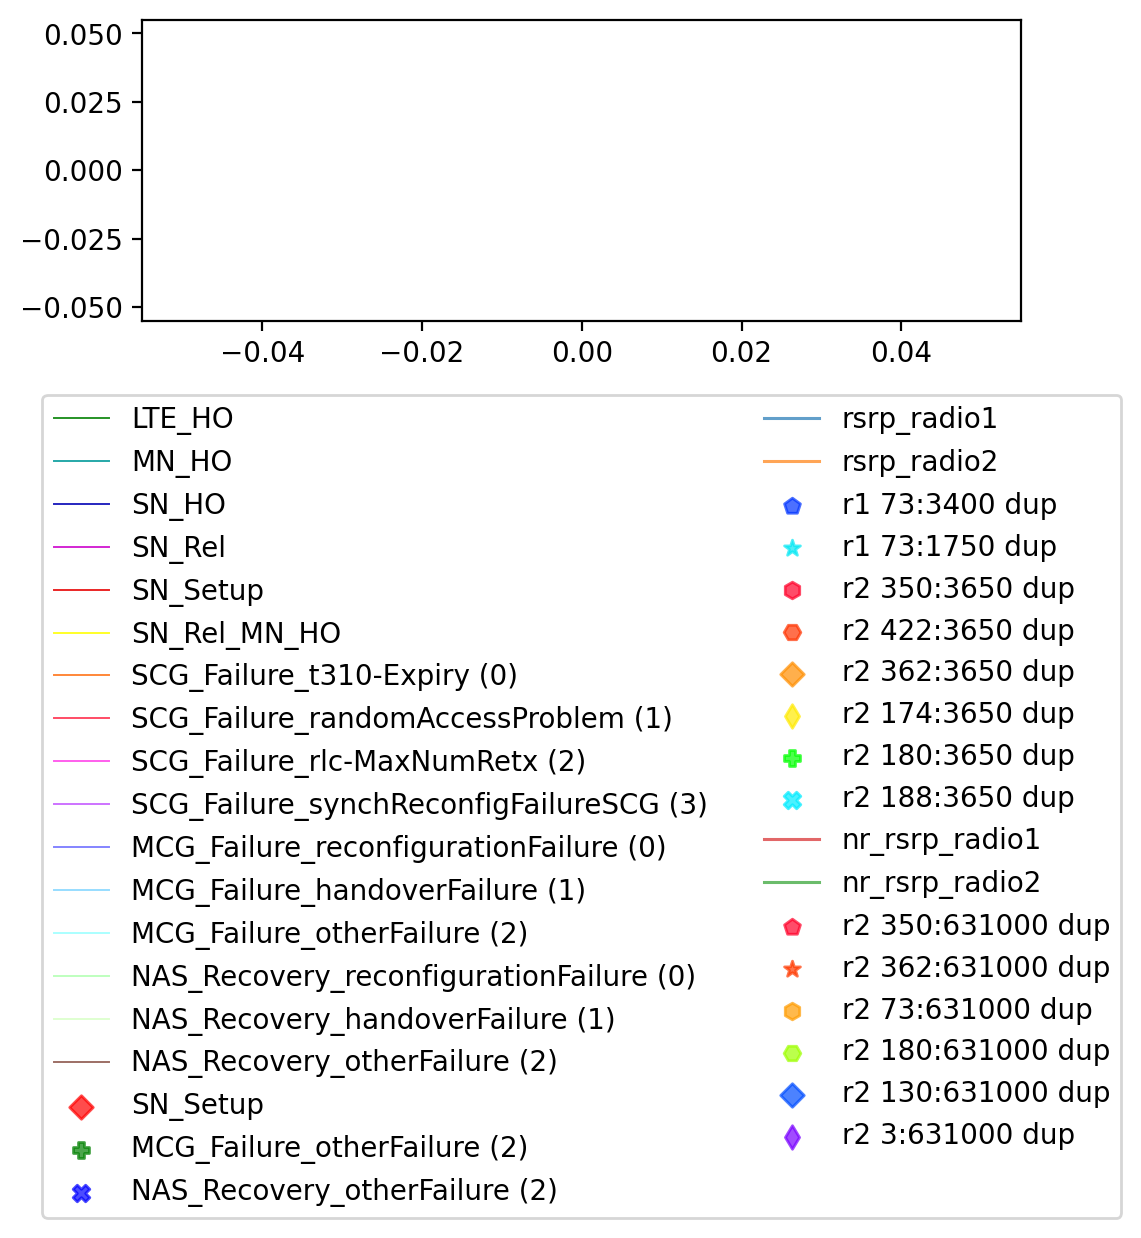

In [516]:
# table = pd.DataFrame(columns=['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR'])
table = pd.DataFrame(columns=['Uplink PLR', 'Uplink ELR', 'Uplink PLR + ELR'])

ul_loss, ul_excl, ul_loss_excl = calc_loss_excl_rate(dfs['ul'][0].copy())
dl_loss, dl_excl, dl_loss_excl = calc_loss_excl_rate(dfs['dl'][0].copy())
ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl = round(ul_loss, 3), round(ul_excl, 3), round(ul_loss_excl, 3), round(dl_loss, 3), round(dl_excl, 3), round(dl_loss_excl, 3)
# print('radio1 - ul loss, ul excl, ul loss + excl, dl loss, dl excl, dl loss + excl:', ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl)
# table.loc['Radio1'] = [ul_loss, dl_loss, ul_excl, dl_excl, dl_loss_excl, ul_loss_excl]
table.loc['Radio1'] = [ul_loss, ul_excl, ul_loss_excl]

ul_loss, ul_excl, ul_loss_excl = calc_loss_excl_rate(dfs['ul'][1].copy())
dl_loss, dl_excl, dl_loss_excl = calc_loss_excl_rate(dfs['dl'][1].copy())
ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl = round(ul_loss, 3), round(ul_excl, 3), round(ul_loss_excl, 3), round(dl_loss, 3), round(dl_excl, 3), round(dl_loss_excl, 3)
# print('radio2 - ul loss, ul excl, ul loss + excl, dl loss, dl excl, dl loss + excl:', ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl)
# table.loc['Radio2'] = [ul_loss, dl_loss, ul_excl, dl_excl, dl_loss_excl, ul_loss_excl]
table.loc['Radio2'] = [ul_loss, ul_excl, ul_loss_excl]

ul_loss, ul_excl, ul_loss_excl = calc_dual_loss_excl_rate(dfs['ul'][0].copy(), dfs['ul'][1].copy())
dl_loss, dl_excl, dl_loss_excl = calc_dual_loss_excl_rate(dfs['dl'][0].copy(), dfs['dl'][1].copy())
ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl = round(ul_loss, 3), round(ul_excl, 3), round(ul_loss_excl, 3), round(dl_loss, 3), round(dl_excl, 3), round(dl_loss_excl, 3)
# print('system - ul loss, ul excl, ul loss + excl, dl loss, dl excl, dl loss + excl:', ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl)
# table.loc['System'] = [ul_loss, dl_loss, ul_excl, dl_excl, dl_loss_excl, ul_loss_excl]
table.loc['System'] = [ul_loss, ul_excl, ul_loss_excl]

display(table)


######################## Uplink Loss & Latency (4 plots)
fig, axes = plt.subplots(7, 1, figsize=(8, 12), sharex=True)

df1 = dfs['ul'][0].copy()
df2 = dfs['ul'][1].copy()

excl_threshold = 100

### Packet Loss
loss1 = df1.loc[df1['lost'], "Timestamp"].iloc[:]
loss2 = df2.loc[df2['lost'], "Timestamp"].iloc[:]
loss = df1.loc[df1['lost'] & df2['lost'], "Timestamp"].iloc[:]

axes[0].vlines(loss1, ymin=0, ymax=0.55, color='b', alpha=0.45)
axes[0].vlines(loss2, ymin=0.45, ymax=1, color='r', alpha=0.45)
axes[0].set_ylim(0, 1)
axes[0].set_yticks([0.25, 0.75])
axes[0].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')
axes[0].set_ylabel('Packet Loss')

df = df1.merge(df2, on='seq').rename(columns={'Timestamp_x': 'Timestamp'}).reset_index(drop=True).copy()
df['lost'] = df['lost_x'] & df['lost_y']
df = df[['Timestamp', 'lost']]
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('1s')

lost_rate_per_second = (df.groupby('Timestamp')['lost'].mean() * 100).reset_index()
timestamp = lost_rate_per_second['Timestamp'].iloc[:]
lost_rate = lost_rate_per_second['lost'].iloc[:]

axes[1].vlines(loss, ymin=0, ymax=100, color='orange', alpha=0.45)
axes[1].plot(timestamp, lost_rate)
axes[1].set_ylim(0, max(min(max(lost_rate) * 1.05, 100), 1))
axes[1].set_ylabel('Loss Rate (%)')

### Latency
timestamp1 = df1["Timestamp"].iloc[:]
latency1 = df1["latency"].iloc[:].astype(float) * 1e3
timestamp2 = df2["Timestamp"].iloc[:]
latency2 = df2["latency"].iloc[:].astype(float) * 1e3

latency_min = np.minimum(latency1, latency2)

axes[2].plot(timestamp1, latency1, linewidth=1.1, color='b', alpha=0.65)
axes[2].plot(timestamp2, latency2, linewidth=1.1, color='r', alpha=0.65)
axes[3].plot(timestamp1, latency_min, linewidth=1.1, color='orange')
    
for ax in [axes[2], axes[3]]:
    ax.set_ylim(0, 500)
    ax.axhline(y=excl_threshold, color='gray', linestyle='--', linewidth=1.1)

axes[2].set_ylabel('Latency (ms)')
axes[3].set_ylabel('Latency (ms)')
# fig.text(0, (axes[2].get_position().y1 + axes[3].get_position().y0) / 2, \
#     'milliseconds', ha='center', va='center', rotation='vertical', fontsize=10)

axes[0].set_title(f'Uplink Loss & Latency ({dev1}:{schm1} + {dev2}:{schm2}) {expr_tr}')

ax_twinx = axes[0].twinx()
ax_twinx.set_ylim(-156, -31)

df1 = dfs['lte'][0].copy()
df2 = dfs['lte'][1].copy()
df1 = df1[df1['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')

df1 = dfs['nr'][0].copy()
df2 = dfs['nr'][1].copy()
df1 = df1[df1['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')

ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

# plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.show()


# ######################## Downlink Loss & Latency (4 plots)
# fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# df1 = dfs['dl'][0].copy()
# df2 = dfs['dl'][1].copy()

# excl_threshold = 100

# ### Packet Loss
# loss1 = df1.loc[df1['lost'], "Timestamp"].iloc[:]
# loss2 = df2.loc[df2['lost'], "Timestamp"].iloc[:]
# loss = df1.loc[df1['lost'] & df2['lost'], "Timestamp"].iloc[:]

# axes[0].vlines(loss1, ymin=0, ymax=0.55, color='b', alpha=0.45)
# axes[0].vlines(loss2, ymin=0.45, ymax=1, color='r', alpha=0.45)
# axes[0].set_ylim(0, 1)
# axes[0].set_yticks([0.25, 0.75])
# axes[0].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')
# axes[0].set_ylabel('Packet Loss')

# df = df1.merge(df2, on='seq').rename(columns={'Timestamp_x': 'Timestamp'}).reset_index(drop=True).copy()
# df['lost'] = df['lost_x'] & df['lost_y']
# df = df[['Timestamp', 'lost']]
# df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('1s')

# lost_rate_per_second = (df.groupby('Timestamp')['lost'].mean() * 100).reset_index()
# timestamp = lost_rate_per_second['Timestamp'].iloc[:]
# lost_rate = lost_rate_per_second['lost'].iloc[:]

# axes[1].vlines(loss, ymin=0, ymax=100, color='orange', alpha=0.45)
# axes[1].plot(timestamp, lost_rate)
# axes[1].set_ylim(0, max(min(max(lost_rate) * 1.05, 100), 1))
# axes[1].set_ylabel('Loss Rate (%)')

# ### Latency
# timestamp1 = df1["Timestamp"].iloc[:]
# latency1 = df1["latency"].iloc[:].astype(float) * 1e3
# timestamp2 = df2["Timestamp"].iloc[:]
# latency2 = df2["latency"].iloc[:].astype(float) * 1e3

# latency_min = np.minimum(latency1, latency2)

# axes[2].plot(timestamp1, latency1, linewidth=1.1, color='b', alpha=0.65)
# axes[2].plot(timestamp2, latency2, linewidth=1.1, color='r', alpha=0.65)
# axes[3].plot(timestamp1, latency_min, linewidth=1.1, color='orange')
    
# for ax in [axes[2], axes[3]]:
#     ax.set_ylim(0, 500)
#     ax.axhline(y=excl_threshold, color='gray', linestyle='--', linewidth=1.1)

# axes[2].set_ylabel('Latency (ms)')
# axes[3].set_ylabel('Latency (ms)')
# # fig.text(0, (axes[6].get_position().y1 + axes[7].get_position().y0) / 2, \
# #     'milliseconds', ha='center', va='center', rotation='vertical', fontsize=10)

# axes[0].set_title('Downlink Loss & Latency')

# plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.show()


legend_list = []

######################## Handover Policy (1 plot)
# fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ax_twinx = axes[4].twinx()
ax_twinx.set_ylim(-156, -31)

df1 = dfs['ho'][0].copy()
df2 = dfs['ho'][1].copy()

handovers = ['LTE_HO','MN_HO','SN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

colors = ['#008000', '#009999', '#0000B3', '#CC00CC', '#E60000', '#FFFF02', '#FF7216', '#FF2C4B', '#FF43EA', '#C459FF', '#6F6FFF', '#85D6FF', '#9BFFFF', '#B2FFB2', '#D9FFC8', 'tab:brown']
cdict3 = {handover: color for handover, color in zip(handovers, colors)}

for handover in handovers:
    legend_list.append(('line', handover, cdict3[handover], 0.85, None, 0.7))

axes[4].set_ylim(0, 1)
axes[4].set_yticks([0.25, 0.75])
axes[4].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

for handover in handovers:

    df = df1.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict3[handover], linewidth=0.7, alpha=0.85)
    
    df = df2.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict3[handover], linewidth=0.7, alpha=0.85)


handovers_subset = [
    'SN_Setup','MCG_Failure_otherFailure (2)','NAS_Recovery_otherFailure (2)'
]

colors = ['r', 'g', 'b']
cdict4 = {handover: color for handover, color in zip(handovers_subset, colors)}

markers = ['D', 'P', 'X']
mdict = {handover: marker for handover, marker in zip(handovers_subset, markers)}

for handover in handovers_subset:
    legend_list.append(('scatter', handover, cdict4[handover], 0.7, mdict[handover], 1.1))

for handover in handovers_subset:

    df = df1.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict4[handover], marker=mdict[handover], alpha=0.7)
    
    df = df2.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict4[handover], marker=mdict[handover], alpha=0.7)

axes[4].set_title('Handover')


######################## LTE Handover (1 plot)

df1 = dfs['lte'][0].copy()
df2 = dfs['lte'][1].copy()

df1 = df1[df1['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# axes[1].plot([], [], color='tab:blue', alpha=0.7, label='rsrp_radio1')
# axes[1].plot([], [], color='tab:orange', alpha=0.7, label='rsrp_radio2')

legend_list.append(('line', 'rsrp_radio1', 'tab:blue', 0.7, None, 1.1))
legend_list.append(('line', 'rsrp_radio2', 'tab:orange', 0.7, None, 1.1))

ax_twinx = axes[5].twinx()
ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')
ax_twinx.set_ylim(-140, -44)
ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

def drop_unchanged(df):
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_EARFCN'] = df['EARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['EARFCN'] != df['prev_EARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_EARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'EARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='Timestamp').reset_index(drop=True)
pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}  

axes[5].set_ylim(0, 1)
axes[5].set_yticks([0.25, 0.75])
axes[5].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df1.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[5].vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        axes[5].scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r1 {pci_earfcn} dup', cdict1[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df2.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[5].vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        axes[5].scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r2 {pci_earfcn} dup', cdict2[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1

axes[5].set_title('LTE Handover')


######################## NR Handover (1 plot)

df1 = dfs['nr'][0].copy()
df2 = dfs['nr'][1].copy()

df1 = df1[df1['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# axes[2].plot([], [], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
# axes[2].plot([], [], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')
legend_list.append(('line', 'nr_rsrp_radio1', 'tab:red', 0.7, None, 1.1))
legend_list.append(('line', 'nr_rsrp_radio2', 'tab:green', 0.7, None, 1.1))

ax_twinx = axes[6].twinx()
ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')
ax_twinx.set_ylim(-156, -31)
ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

def drop_unchanged(df):
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_NR_ARFCN'] = df['NR_ARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['NR_ARFCN'] != df['prev_NR_ARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_NR_ARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'NR_ARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['NR_ARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='Timestamp').reset_index(drop=True)
pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['NR_ARFCN'].array)]

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}  

axes[6].set_ylim(0, 1)
axes[6].set_yticks([0.25, 0.75])
axes[6].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df1.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['NR_ARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[6].vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0]) if not tmp.empty else pd.DataFrame()
    if not tmp.empty:
        axes[6].scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r1 {pci_earfcn} dup', cdict1[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df2.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['NR_ARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[6].vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0]) if not tmp.empty else pd.DataFrame()
    if not tmp.empty:
        axes[6].scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r2 {pci_earfcn} dup', cdict2[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1
        
axes[6].set_title('NR Handover')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


######################## Legends Show
def add_legend(ax, style, label, color, alpha=1, marker=None, linewidth=1.1):
    if style == 'line':
        plot = ax.plot([], [], color=color, alpha=alpha, linewidth=linewidth)[0]
    else:
        plot = ax.scatter([], [], c=color, alpha=alpha, marker=marker)
        
    legend_lines.append(plot)
    legend_labels.append(label)

fig, ax = plt.subplots(figsize=(5.7, 7), sharex=True)

legend_lines, legend_labels = [], []

for item in legend_list:
    # print(item)
    add_legend(ax, *item)

ax.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=2)
plt.tight_layout()
plt.show()

### All Plots # Downlink

Downlink PLR  Downlink ELR  Downlink PLR + ELR
Radio1         0.000         0.523               0.523
Radio2         0.167         0.639               0.804
System         0.000         0.014               0.014

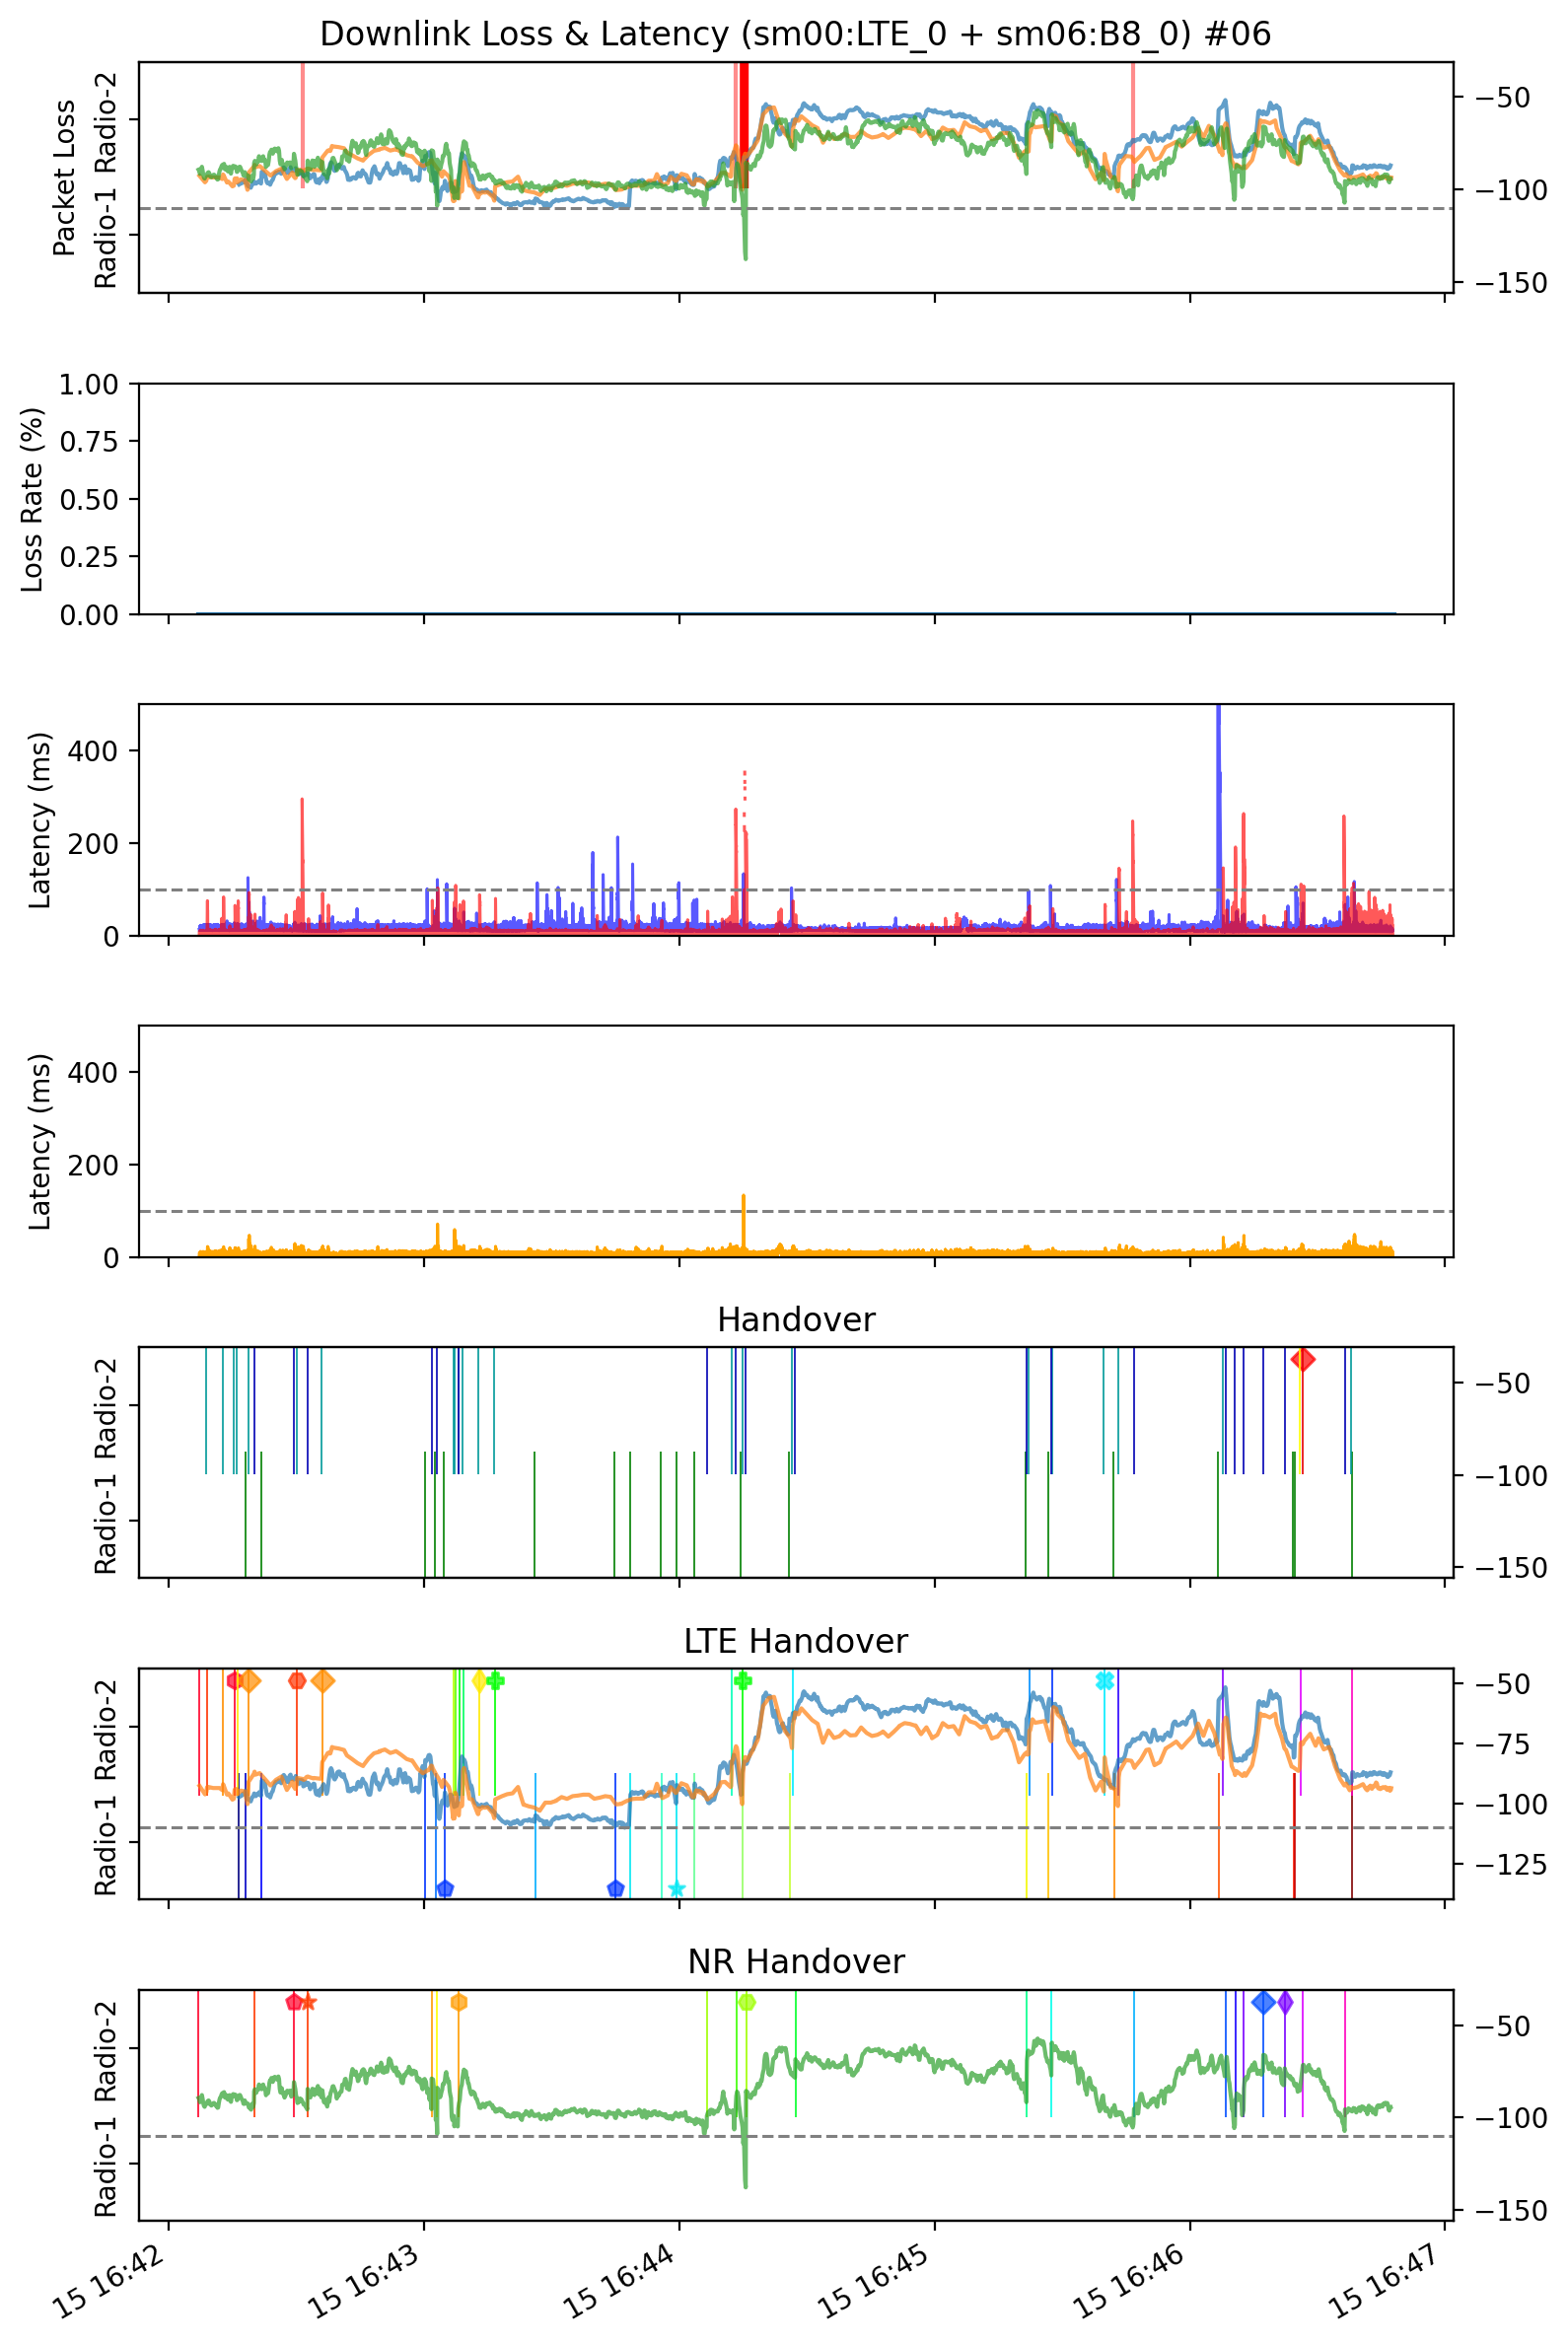

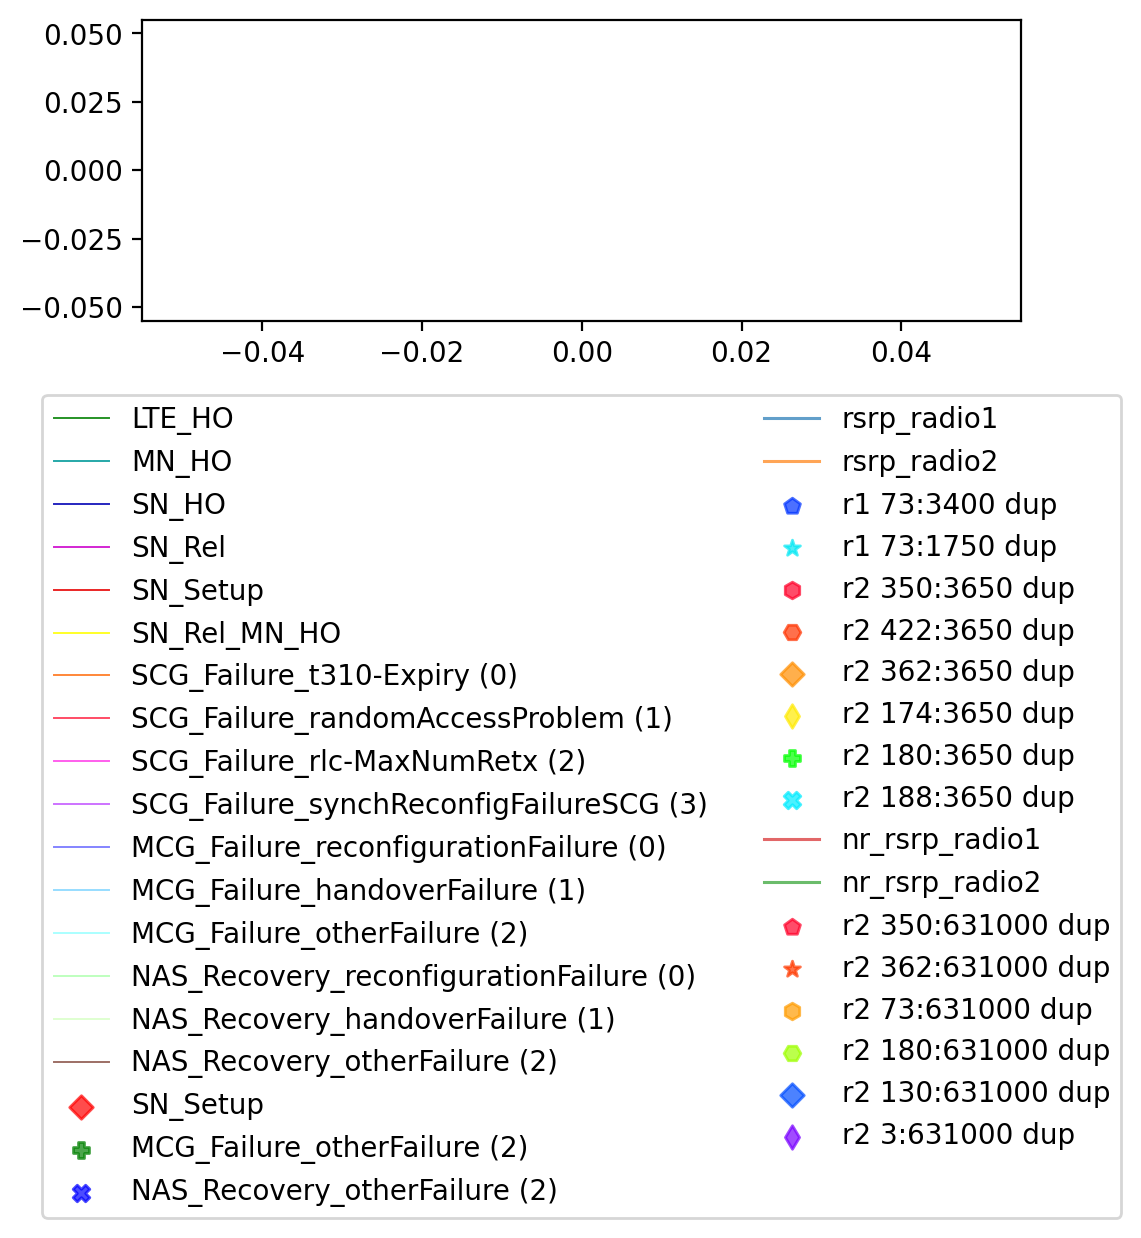

In [517]:
# table = pd.DataFrame(columns=['Uplink PLR', 'Downlink PLR', 'Uplink ELR', 'Downlink ELR', 'Uplink PLR + ELR', 'Downlink PLR + ELR'])
table = pd.DataFrame(columns=['Downlink PLR', 'Downlink ELR', 'Downlink PLR + ELR'])

ul_loss, ul_excl, ul_loss_excl = calc_loss_excl_rate(dfs['ul'][0].copy())
dl_loss, dl_excl, dl_loss_excl = calc_loss_excl_rate(dfs['dl'][0].copy())
ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl = round(ul_loss, 3), round(ul_excl, 3), round(ul_loss_excl, 3), round(dl_loss, 3), round(dl_excl, 3), round(dl_loss_excl, 3)
# print('radio1 - ul loss, ul excl, ul loss + excl, dl loss, dl excl, dl loss + excl:', ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl)
# table.loc['Radio1'] = [ul_loss, dl_loss, ul_excl, dl_excl, dl_loss_excl, ul_loss_excl]
table.loc['Radio1'] = [dl_loss, dl_excl, dl_loss_excl]

ul_loss, ul_excl, ul_loss_excl = calc_loss_excl_rate(dfs['ul'][1].copy())
dl_loss, dl_excl, dl_loss_excl = calc_loss_excl_rate(dfs['dl'][1].copy())
ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl = round(ul_loss, 3), round(ul_excl, 3), round(ul_loss_excl, 3), round(dl_loss, 3), round(dl_excl, 3), round(dl_loss_excl, 3)
# print('radio2 - ul loss, ul excl, ul loss + excl, dl loss, dl excl, dl loss + excl:', ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl)
# table.loc['Radio2'] = [ul_loss, dl_loss, ul_excl, dl_excl, dl_loss_excl, ul_loss_excl]
table.loc['Radio2'] = [dl_loss, dl_excl, dl_loss_excl]

ul_loss, ul_excl, ul_loss_excl = calc_dual_loss_excl_rate(dfs['ul'][0].copy(), dfs['ul'][1].copy())
dl_loss, dl_excl, dl_loss_excl = calc_dual_loss_excl_rate(dfs['dl'][0].copy(), dfs['dl'][1].copy())
ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl = round(ul_loss, 3), round(ul_excl, 3), round(ul_loss_excl, 3), round(dl_loss, 3), round(dl_excl, 3), round(dl_loss_excl, 3)
# print('system - ul loss, ul excl, ul loss + excl, dl loss, dl excl, dl loss + excl:', ul_loss, ul_excl, ul_loss_excl, dl_loss, dl_excl, dl_loss_excl)
# table.loc['System'] = [ul_loss, dl_loss, ul_excl, dl_excl, dl_loss_excl, ul_loss_excl]
table.loc['System'] = [dl_loss, dl_excl, dl_loss_excl]

display(table)


# ######################## Uplink Loss & Latency (4 plots)
# fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# df1 = dfs['ul'][0].copy()
# df2 = dfs['ul'][1].copy()

# excl_threshold = 100

# ### Packet Loss
# loss1 = df1.loc[df1['lost'], "Timestamp"].iloc[:]
# loss2 = df2.loc[df2['lost'], "Timestamp"].iloc[:]
# loss = df1.loc[df1['lost'] & df2['lost'], "Timestamp"].iloc[:]

# axes[0].vlines(loss1, ymin=0, ymax=0.55, color='b', alpha=0.45)
# axes[0].vlines(loss2, ymin=0.45, ymax=1, color='r', alpha=0.45)
# axes[0].set_ylim(0, 1)
# axes[0].set_yticks([0.25, 0.75])
# axes[0].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')
# axes[0].set_ylabel('Packet Loss')

# df = df1.merge(df2, on='seq').rename(columns={'Timestamp_x': 'Timestamp'}).reset_index(drop=True).copy()
# df['lost'] = df['lost_x'] & df['lost_y']
# df = df[['Timestamp', 'lost']]
# df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('1s')

# lost_rate_per_second = (df.groupby('Timestamp')['lost'].mean() * 100).reset_index()
# timestamp = lost_rate_per_second['Timestamp'].iloc[:]
# lost_rate = lost_rate_per_second['lost'].iloc[:]

# axes[1].vlines(loss, ymin=0, ymax=100, color='orange', alpha=0.45)
# axes[1].plot(timestamp, lost_rate)
# axes[1].set_ylim(0, max(min(max(lost_rate) * 1.05, 100), 1))
# axes[1].set_ylabel('Loss Rate (%)')

# ### Latency
# timestamp1 = df1["Timestamp"].iloc[:]
# latency1 = df1["latency"].iloc[:].astype(float) * 1e3
# timestamp2 = df2["Timestamp"].iloc[:]
# latency2 = df2["latency"].iloc[:].astype(float) * 1e3

# latency_min = np.minimum(latency1, latency2)

# axes[2].plot(timestamp1, latency1, linewidth=1.1, color='b', alpha=0.65)
# axes[2].plot(timestamp2, latency2, linewidth=1.1, color='r', alpha=0.65)
# axes[3].plot(timestamp1, latency_min, linewidth=1.1, color='orange')
    
# for ax in [axes[2], axes[3]]:
#     ax.set_ylim(0, 500)
#     ax.axhline(y=excl_threshold, color='gray', linestyle='--', linewidth=1.1)

# axes[2].set_ylabel('Latency (ms)')
# axes[3].set_ylabel('Latency (ms)')
# # fig.text(0, (axes[2].get_position().y1 + axes[3].get_position().y0) / 2, \
# #     'milliseconds', ha='center', va='center', rotation='vertical', fontsize=10)

# axes[0].set_title('Uplink Loss & Latency')

# plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.show()


######################## Downlink Loss & Latency (4 plots)
fig, axes = plt.subplots(7, 1, figsize=(8, 12), sharex=True)

df1 = dfs['dl'][0].copy()
df2 = dfs['dl'][1].copy()

excl_threshold = 100

### Packet Loss
loss1 = df1.loc[df1['lost'], "Timestamp"].iloc[:]
loss2 = df2.loc[df2['lost'], "Timestamp"].iloc[:]
loss = df1.loc[df1['lost'] & df2['lost'], "Timestamp"].iloc[:]

axes[0].vlines(loss1, ymin=0, ymax=0.55, color='b', alpha=0.45)
axes[0].vlines(loss2, ymin=0.45, ymax=1, color='r', alpha=0.45)
axes[0].set_ylim(0, 1)
axes[0].set_yticks([0.25, 0.75])
axes[0].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')
axes[0].set_ylabel('Packet Loss')

df = df1.merge(df2, on='seq').rename(columns={'Timestamp_x': 'Timestamp'}).reset_index(drop=True).copy()
df['lost'] = df['lost_x'] & df['lost_y']
df = df[['Timestamp', 'lost']]
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.round('1s')

lost_rate_per_second = (df.groupby('Timestamp')['lost'].mean() * 100).reset_index()
timestamp = lost_rate_per_second['Timestamp'].iloc[:]
lost_rate = lost_rate_per_second['lost'].iloc[:]

axes[1].vlines(loss, ymin=0, ymax=100, color='orange', alpha=0.45)
axes[1].plot(timestamp, lost_rate)
axes[1].set_ylim(0, max(min(max(lost_rate) * 1.05, 100), 1))
axes[1].set_ylabel('Loss Rate (%)')

### Latency
timestamp1 = df1["Timestamp"].iloc[:]
latency1 = df1["latency"].iloc[:].astype(float) * 1e3
timestamp2 = df2["Timestamp"].iloc[:]
latency2 = df2["latency"].iloc[:].astype(float) * 1e3

latency_min = np.minimum(latency1, latency2)

axes[2].plot(timestamp1, latency1, linewidth=1.1, color='b', alpha=0.65)
axes[2].plot(timestamp2, latency2, linewidth=1.1, color='r', alpha=0.65)
axes[3].plot(timestamp1, latency_min, linewidth=1.1, color='orange')
    
for ax in [axes[2], axes[3]]:
    ax.set_ylim(0, 500)
    ax.axhline(y=excl_threshold, color='gray', linestyle='--', linewidth=1.1)

axes[2].set_ylabel('Latency (ms)')
axes[3].set_ylabel('Latency (ms)')
# fig.text(0, (axes[6].get_position().y1 + axes[7].get_position().y0) / 2, \
#     'milliseconds', ha='center', va='center', rotation='vertical', fontsize=10)

axes[0].set_title(f'Downlink Loss & Latency ({dev1}:{schm1} + {dev2}:{schm2}) {expr_tr}')

ax_twinx = axes[0].twinx()
ax_twinx.set_ylim(-156, -31)

df1 = dfs['lte'][0].copy()
df2 = dfs['lte'][1].copy()
df1 = df1[df1['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')

df1 = dfs['nr'][0].copy()
df2 = dfs['nr'][1].copy()
df1 = df1[df1['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')

ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

# plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.show()


legend_list = []

######################## Handover Policy (1 plot)
# fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ax_twinx = axes[4].twinx()
ax_twinx.set_ylim(-156, -31)

df1 = dfs['ho'][0].copy()
df2 = dfs['ho'][1].copy()

handovers = ['LTE_HO','MN_HO','SN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

colors = ['#008000', '#009999', '#0000B3', '#CC00CC', '#E60000', '#FFFF02', '#FF7216', '#FF2C4B', '#FF43EA', '#C459FF', '#6F6FFF', '#85D6FF', '#9BFFFF', '#B2FFB2', '#D9FFC8', 'tab:brown']
cdict3 = {handover: color for handover, color in zip(handovers, colors)}

for handover in handovers:
    legend_list.append(('line', handover, cdict3[handover], 0.85, None, 0.7))

axes[4].set_ylim(0, 1)
axes[4].set_yticks([0.25, 0.75])
axes[4].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

for handover in handovers:

    df = df1.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict3[handover], linewidth=0.7, alpha=0.85)
    
    df = df2.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict3[handover], linewidth=0.7, alpha=0.85)


handovers_subset = [
    'SN_Setup','MCG_Failure_otherFailure (2)','NAS_Recovery_otherFailure (2)'
]

colors = ['r', 'g', 'b']
cdict4 = {handover: color for handover, color in zip(handovers_subset, colors)}

markers = ['D', 'P', 'X']
mdict = {handover: marker for handover, marker in zip(handovers_subset, markers)}

for handover in handovers_subset:
    legend_list.append(('scatter', handover, cdict4[handover], 0.7, mdict[handover], 1.1))

for handover in handovers_subset:

    df = df1.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict4[handover], marker=mdict[handover], alpha=0.7)
    
    df = df2.copy()
    tmp = df[df['ho_type0'] == handover].reset_index(drop=True)
    if not tmp.empty:
        axes[4].scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict4[handover], marker=mdict[handover], alpha=0.7)

axes[4].set_title('Handover')


######################## LTE Handover (1 plot)

df1 = dfs['lte'][0].copy()
df2 = dfs['lte'][1].copy()

df1 = df1[df1['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PCell'][['Timestamp', 'PCI', 'EARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# axes[1].plot([], [], color='tab:blue', alpha=0.7, label='rsrp_radio1')
# axes[1].plot([], [], color='tab:orange', alpha=0.7, label='rsrp_radio2')

legend_list.append(('line', 'rsrp_radio1', 'tab:blue', 0.7, None, 1.1))
legend_list.append(('line', 'rsrp_radio2', 'tab:orange', 0.7, None, 1.1))

ax_twinx = axes[5].twinx()
ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:blue', alpha=0.7, label='rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:orange', alpha=0.7, label='rsrp_radio2')
ax_twinx.set_ylim(-140, -44)
ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

def drop_unchanged(df):
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_EARFCN'] = df['EARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['EARFCN'] != df['prev_EARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_EARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'EARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='Timestamp').reset_index(drop=True)
pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['EARFCN'].array)]

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}  

axes[5].set_ylim(0, 1)
axes[5].set_yticks([0.25, 0.75])
axes[5].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df1.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[5].vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        axes[5].scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r1 {pci_earfcn} dup', cdict1[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df2.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['EARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[5].vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0])
    if not tmp.empty:
        axes[5].scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r2 {pci_earfcn} dup', cdict2[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1

axes[5].set_title('LTE Handover')


######################## NR Handover (1 plot)

df1 = dfs['nr'][0].copy()
df2 = dfs['nr'][1].copy()

df1 = df1[df1['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)
df2 = df2[df2['serv_cel_index'] == 'PSCell'][['Timestamp', 'PCI', 'NR_ARFCN', 'RSRP', 'RSRQ']].reset_index(drop=True)

# axes[2].plot([], [], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
# axes[2].plot([], [], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')
legend_list.append(('line', 'nr_rsrp_radio1', 'tab:red', 0.7, None, 1.1))
legend_list.append(('line', 'nr_rsrp_radio2', 'tab:green', 0.7, None, 1.1))

ax_twinx = axes[6].twinx()
ax_twinx.plot(df1['Timestamp'], df1['RSRP'], color='tab:red', alpha=0.7, label='nr_rsrp_radio1')
ax_twinx.plot(df2['Timestamp'], df2['RSRP'], color='tab:green', alpha=0.7, label='nr_rsrp_radio2')
ax_twinx.set_ylim(-156, -31)
ax_twinx.axhline(y=-110, color='gray', linestyle='--', linewidth=1.1)

def drop_unchanged(df):
    
    df['prev_PCI'] = df['PCI'].shift(1)
    df['prev_NR_ARFCN'] = df['NR_ARFCN'].shift(1)
    df['handover'] = (df['PCI'] != df['prev_PCI']) | (df['NR_ARFCN'] != df['prev_NR_ARFCN'])
    df.loc[0, 'handover'] = True
    
    df = df[df['handover']].reset_index(drop=True).drop(['prev_PCI', 'prev_NR_ARFCN'], axis=1)
    df['duplicate'] = df.duplicated(subset=['PCI', 'NR_ARFCN'])
    
    pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['NR_ARFCN'].array)]
    
    return df, pairs

def drop_duplicate(my_list):
    unique_list = []
    seen = set()
    
    for item in my_list:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)

    return unique_list

df1, pairs1 = drop_unchanged(df1)
df2, pairs2 = drop_unchanged(df2)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='Timestamp').reset_index(drop=True)
pairs = [(pci, earfcn) for pci, earfcn in zip(df[~df['duplicate']]['PCI'].array, df[~df['duplicate']]['NR_ARFCN'].array)]

cmap = plt.get_cmap('jet', len(pairs1))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict1 = {pair: color for pair, color in zip(pairs1, colors)}

cmap = plt.get_cmap('gist_rainbow', len(pairs2))
colors = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict2 = {pair: color for pair, color in zip(pairs2, colors)}

markers = ['p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
mdict = {}  

axes[6].set_ylim(0, 1)
axes[6].set_yticks([0.25, 0.75])
axes[6].set_yticklabels(["Radio-1", "Radio-2"], rotation='vertical', va='center')

k = 0       
for pair in pairs1:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df1.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['NR_ARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[6].vlines(tmp.Timestamp, ymin=0, ymax=0.55, color=cdict1[pair], linewidth=0.7, alpha=0.85, label=f'r1 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0]) if not tmp.empty else pd.DataFrame()
    if not tmp.empty:
        axes[6].scatter(tmp.Timestamp, [0.05]*len(tmp), c=cdict1[pair], marker=markers[k % len(markers)], label=f'r1 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r1 {pci_earfcn} dup', cdict1[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1

for pair in pairs2:
    pci_earfcn = f'{pair[0]}:{pair[1]}'
    
    df = df2.copy()
    tmp = df[(df['PCI'] == pair[0]) & (df['NR_ARFCN'] == pair[1])].reset_index(drop=True)
    if not tmp.empty:
        axes[6].vlines(tmp.Timestamp, ymin=0.45, ymax=1, color=cdict2[pair], linewidth=0.7, alpha=0.85, label=f'r2 {pci_earfcn}')
    
    tmp = tmp.drop(df.index[0]) if not tmp.empty else pd.DataFrame()
    if not tmp.empty:
        axes[6].scatter(tmp.Timestamp, [0.95]*len(tmp), c=cdict2[pair], marker=markers[k % len(markers)], label=f'r2 {pci_earfcn} dup', alpha=0.7)
        legend_list.append(('scatter', f'r2 {pci_earfcn} dup', cdict2[pair], 0.7, markers[k % len(markers)], 1.1))
        k += 1
        
axes[6].set_title('NR Handover')

plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


######################## Legends Show
def add_legend(ax, style, label, color, alpha=1, marker=None, linewidth=1.1):
    if style == 'line':
        plot = ax.plot([], [], color=color, alpha=alpha, linewidth=linewidth)[0]
    else:
        plot = ax.scatter([], [], c=color, alpha=alpha, marker=marker)
        
    legend_lines.append(plot)
    legend_labels.append(label)

fig, ax = plt.subplots(figsize=(5.7, 7), sharex=True)

legend_lines, legend_labels = [], []

for item in legend_list:
    # print(item)
    add_legend(ax, *item)

ax.legend(legend_lines, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=2)
plt.tight_layout()
plt.show()